In [ ]:
!pip install SoundFile transformers scikit-learn
from transformers import AutoFeatureExtractor, WhisperModel, WhisperProcessor
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoFeatureExtractor, WhisperForAudioClassification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import os
import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
from sklearn.model_selection import train_test_split
import re
from collections import Counter
from sklearn.metrics import classification_report


In [ ]:
class DysarthriaDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, feature_extractor, max_length=100000):
        self.data = data
        self.labels = labels
        self.max_length = max_length
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
          wav_data, _ = sf.read(self.data[idx])
        except:
          print(f"Error opening file: {self.data[idx]}. Skipping...")
          return self.__getitem__((idx + 1) % len(self.data))

        inputs = self.feature_extractor(wav_data, sampling_rate=16000, return_tensors="pt")
        inputs_val = inputs.input_features.squeeze(0)  # Squeeze the batch dimension
        # if self.max_length - input_values.shape[-1] > 0:
        #     input_values = torch.cat([input_values, torch.zeros((self.max_length - input_values.shape[-1],))], dim=-1)
        # else:
        #     input_values = input_values[:self.max_length]
        return {"input_features":inputs_val}, self.labels[idx]

In [ ]:
def train(model, dataloader, criterion, optimizer, device, loss_vals, epochs, current_epoch):
    model.train()
    running_loss = 0

    for i, (inputs, labels) in enumerate(dataloader):
        inputs = {key: value.to(device) for key, value in inputs.items()}
        labels = labels.to(device)

        batch_size = labels.size(0)  # Get batch size from labels tensor
        decoder_input_ids = torch.tensor([[1] * batch_size]).to(device) * model.config.decoder_start_token_id

        optimizer.zero_grad()
        outputs = model(**inputs, decoder_input_ids=decoder_input_ids, output_hidden_states=True)
        last_hidden_state = outputs.last_hidden_state
        pooled_output = torch.mean(last_hidden_state, dim=1, keepdim=False)  # Ensure batch size is maintained

        logits = classifier(pooled_output)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        loss_vals.append(loss.item())
        running_loss += loss.item()

        if i % 10 == 0:
            plt.clf()
            plt.plot(loss_vals)
            plt.xlim([0, len(dataloader)*epochs])
            plt.ylim([0, max(loss_vals) + 2])
            plt.xlabel('Training Iterations')
            plt.ylabel('Loss')
            plt.title(f"Training Loss at Epoch {current_epoch + 1}")
            plt.pause(0.001)

    avg_loss = running_loss / len(dataloader)
    print(f"Average Loss after Epoch {current_epoch + 1}: {avg_loss}\n")
    return avg_loss


In [ ]:

def predict(model, file_path, processor, device, max_length=100000): ### CHANGES: added max_length as an argument.
    model.eval()
    with torch.no_grad():
        wav_data, _ = sf.read(file_path)
        inputs = processor(wav_data, sampling_rate=16000, return_tensors="pt", padding=True)
        # inputs = {key: value.squeeze().to(device) for key, value in inputs.items()}

        ### NEW CODES HERE
        input_values = inputs.input_values.squeeze(0)  # Squeeze the batch dimension
        if max_length - input_values.shape[-1] > 0:
            input_values = torch.cat([input_values, torch.zeros((max_length - input_values.shape[-1],))], dim=-1)
        else:
            input_values = input_values[:max_length]
        input_values = input_values.unsqueeze(0).to(device)
        inputs = {"input_values": input_values}
        ###

        logits = model(**inputs).logits
        # _, predicted = torch.max(logits, dim=0)

        ### NEW CODES HERE
        # Remove the batch dimension.
        logits = logits.squeeze()
        predicted_class_id = torch.argmax(logits, dim=-1).item()
        ###

    # return predicted.item()
    return predicted_class_id


In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0
    correct_predictions = 0
    total_predictions = 0
    wrong_files = []
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = {key: value.to(device) for key, value in inputs.items()}  # Note: squeeze() removed
            labels = labels.to(device)
            decoder_input_ids = torch.tensor([[1, 1]]) * model.config.decoder_start_token_id
            decoder_input_ids = decoder_input_ids.to(device)

            # Adjusted the forward call to include decoder_input_ids
            outputs = model(**inputs, decoder_input_ids=decoder_input_ids, output_hidden_states = True)
            last_hidden_state = outputs.last_hidden_state
            pooled_output = torch.mean(last_hidden_state, dim=1)  # Change to whatever pooling you prefer

            # Get class logits
            logits = classifier(pooled_output)
            loss = criterion(logits, labels)
            running_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            wrong_idx = (predicted != labels).nonzero().squeeze().cpu().numpy()
            if wrong_idx.ndim > 0:
                for idx in wrong_idx:
                    wrong_files.append(dataloader.dataset.data[idx])
            elif wrong_idx.size > 0:
                wrong_files.append(dataloader.dataset.data[wrong_idx])

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_loss = running_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions

    return avg_loss, accuracy, wrong_files, np.array(all_labels), np.array(all_predictions)


#getfiles

In [ ]:
def get_wav_files(base_path):
    wav_files = []
    for subject_folder in os.listdir(base_path):
        subject_path = os.path.join(base_path, subject_folder)
        if os.path.isdir(subject_path):
            for wav_file in os.listdir(subject_path):
                if wav_file.endswith('.wav'):
                    wav_files.append(os.path.join(subject_path, wav_file))

    return wav_files

In [ ]:
def get_torgo_data(dysarthria_path, non_dysarthria_path):
    dysarthria_files = [os.path.join(dysarthria_path, f) for f in os.listdir(dysarthria_path) if f.endswith('.wav')]
    non_dysarthria_files = [os.path.join(non_dysarthria_path, f) for f in os.listdir(non_dysarthria_path) if f.endswith('.wav')]

    data = dysarthria_files + non_dysarthria_files
    labels = [1] * len(dysarthria_files) + [0] * len(non_dysarthria_files)

    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, stratify=labels)
    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, stratify=train_labels) # 0.25 x 0.8 = 0.2

    return train_data, val_data, test_data, train_labels, val_labels, test_labels

#setup

In [ ]:
dysarthria_path = "/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS"
non_dysarthria_path = "/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS"

# get your data
dysarthria_files = get_wav_files(dysarthria_path)
non_dysarthria_files = get_wav_files(non_dysarthria_path)

data = dysarthria_files + non_dysarthria_files
labels = [1] * len(dysarthria_files) + [0] * len(non_dysarthria_files)

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, stratify=labels)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, stratify=train_labels) # 0.25 x 0.8 = 0.2

# instantiate the feature extractor
feature_extractor = WhisperProcessor.from_pretrained("openai/whisper-tiny")

# create your datasets
train_dataset = DysarthriaDataset(train_data, train_labels, feature_extractor)
test_dataset = DysarthriaDataset(test_data, test_labels, feature_extractor)
val_dataset = DysarthriaDataset(val_data, val_labels, feature_extractor)

# create your data loaders
train_loader = DataLoader(train_dataset, batch_size=1, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=1, drop_last=False)
validation_loader = DataLoader(val_dataset, batch_size=1, drop_last=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = WhisperModel.from_pretrained("openai/whisper-tiny")
model.load_state_dict(torch.load('dysarthria_classifier1.pth'))
model.to(device)


# training configurations
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


#sched

In [ ]:
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

#train

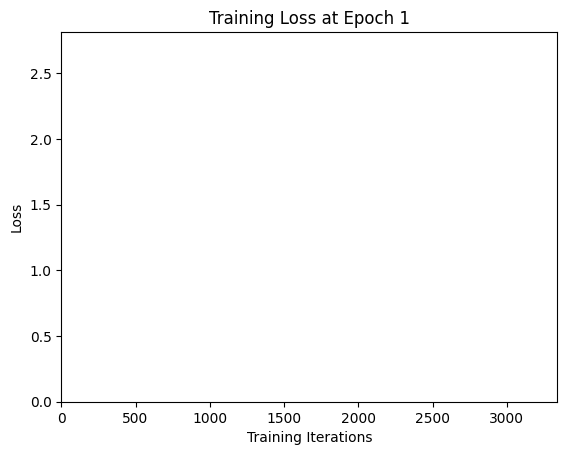

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...


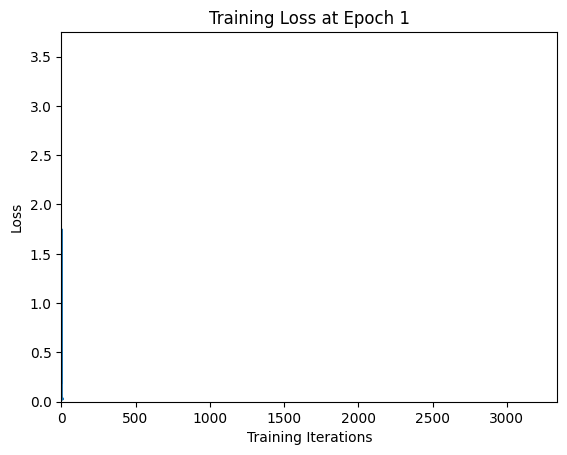

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...


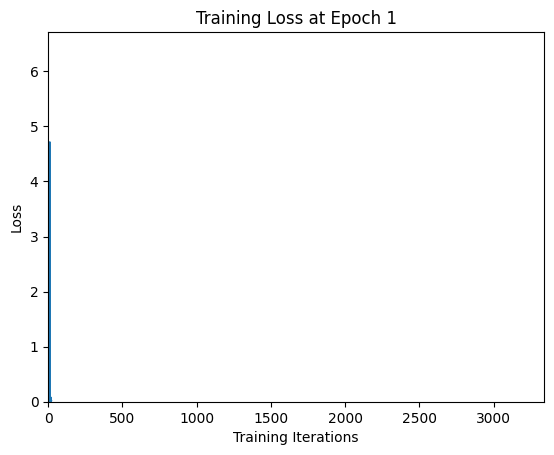

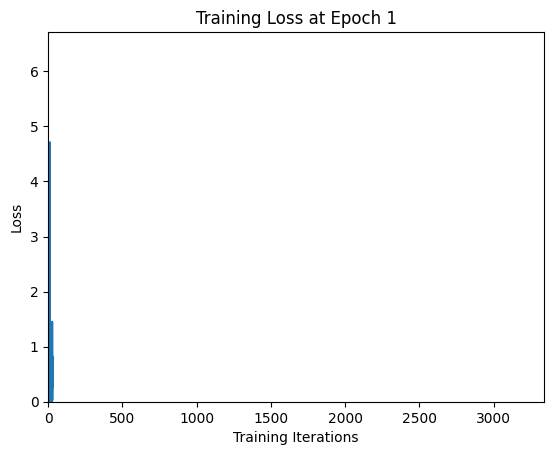

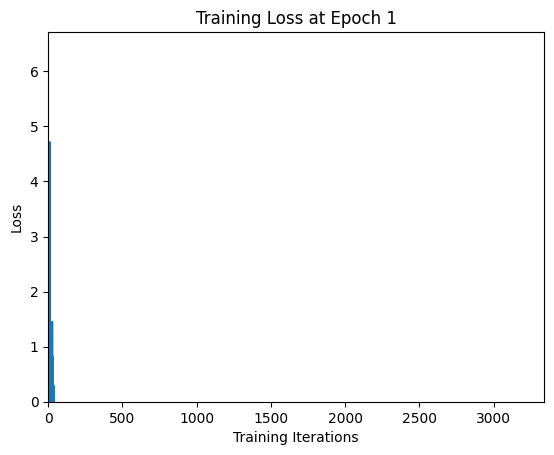

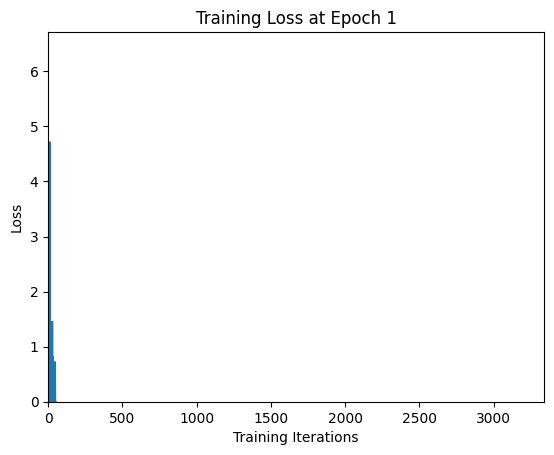

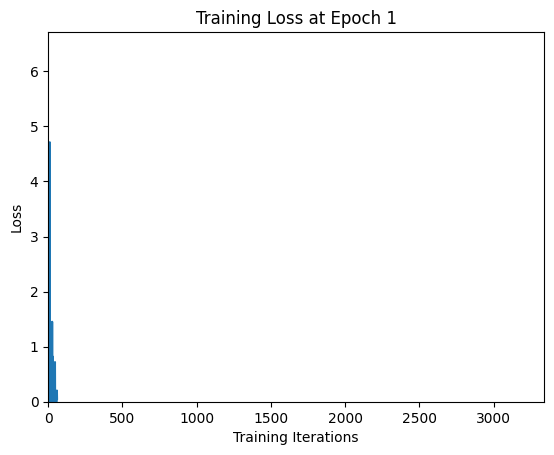

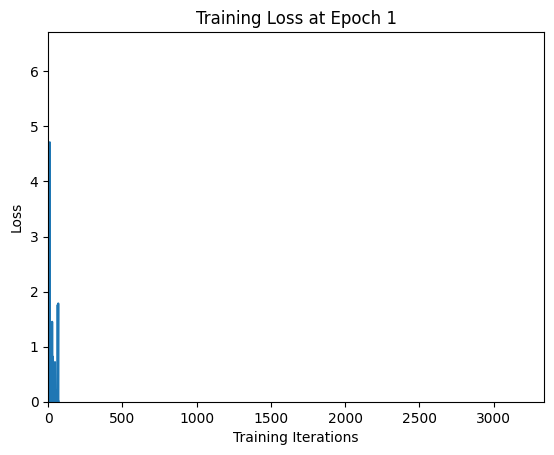

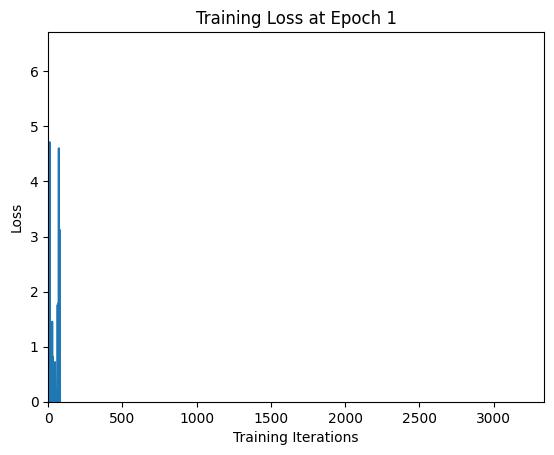

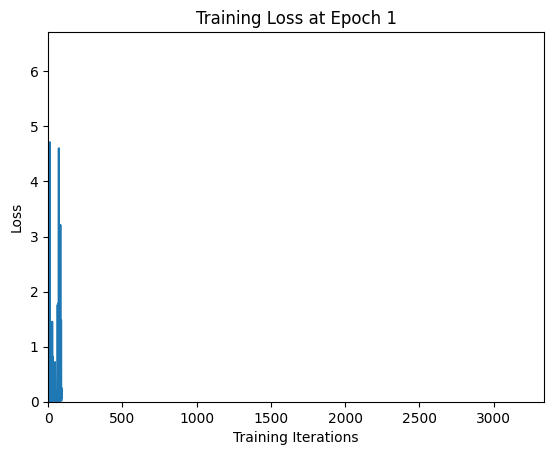

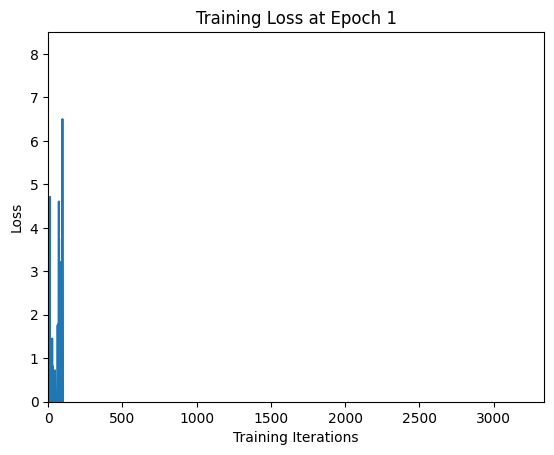

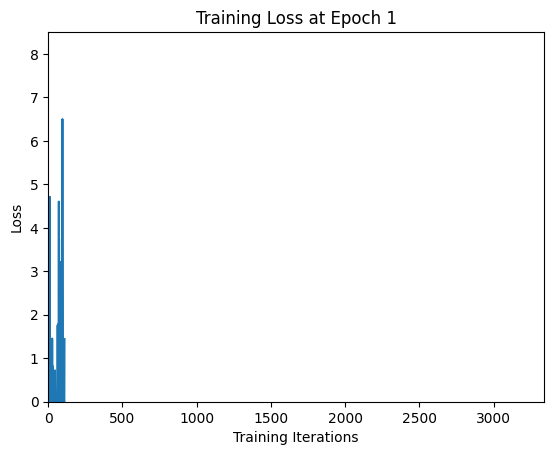

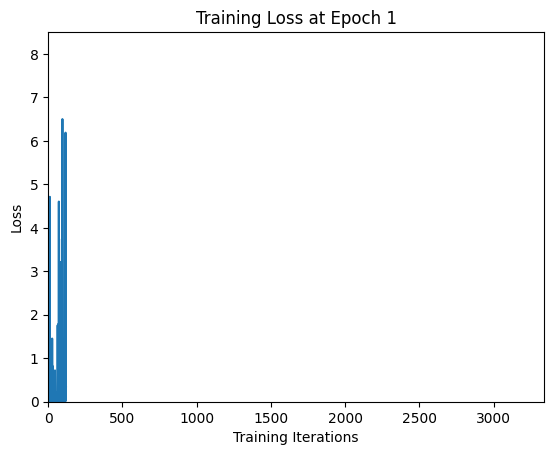

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT037_ANALYSIS/CT037_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_5.wav. Skipping...


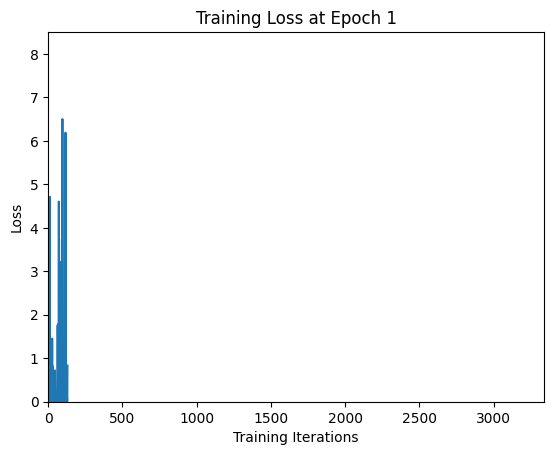

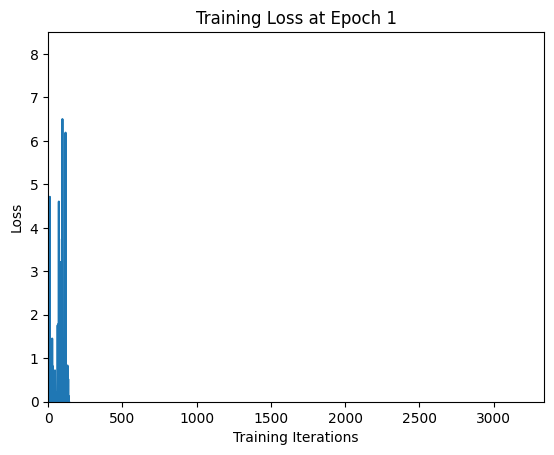

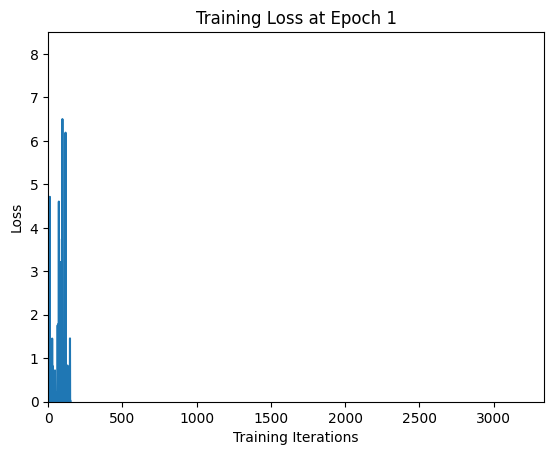

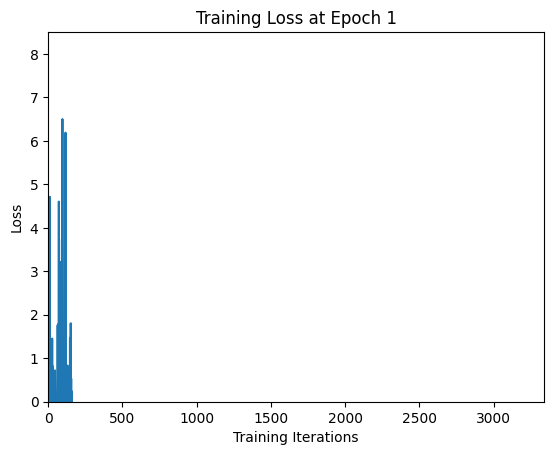

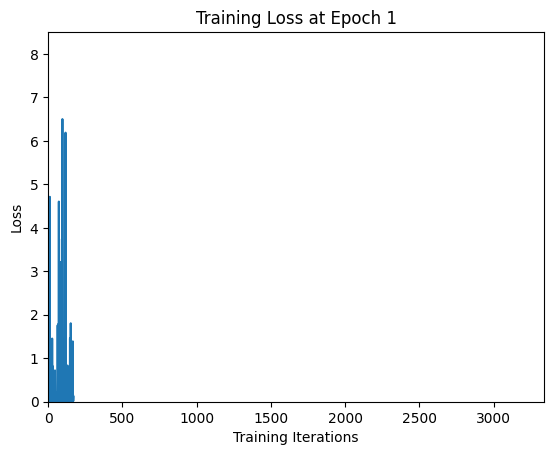

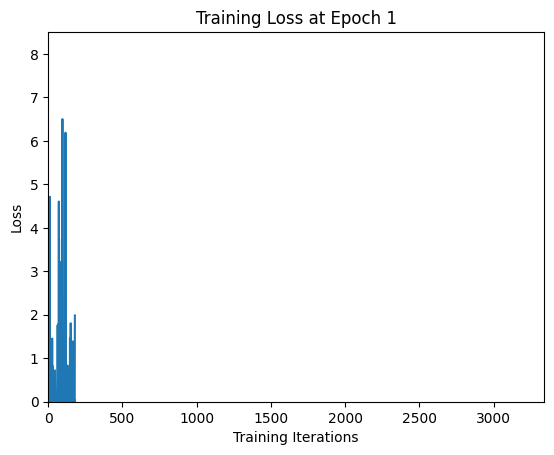

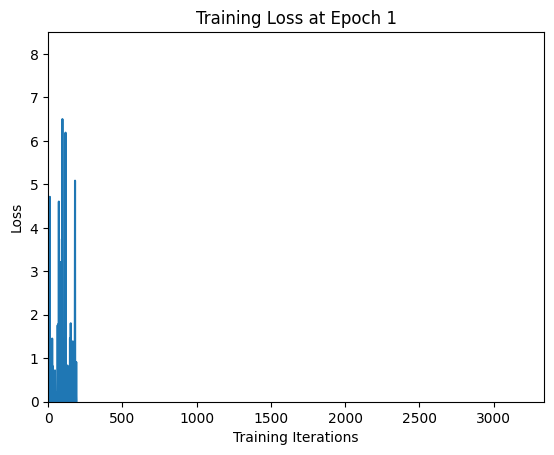

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_5.wav. Skipping...


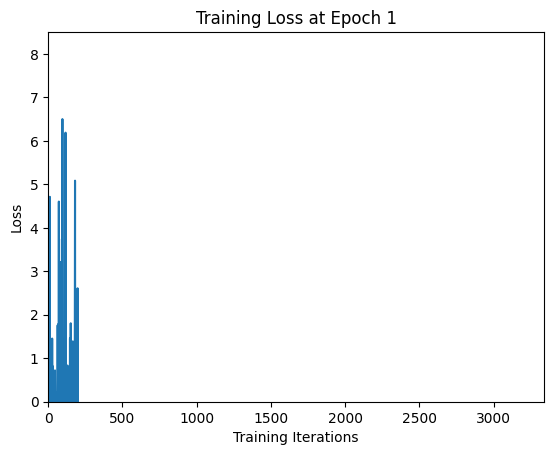

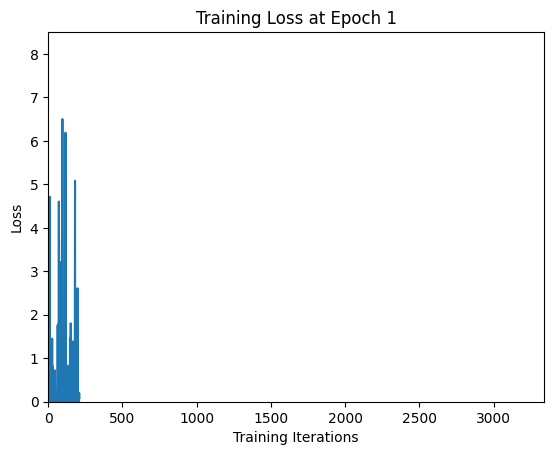

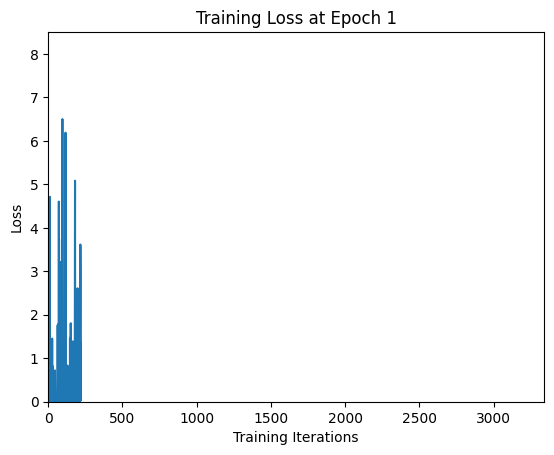

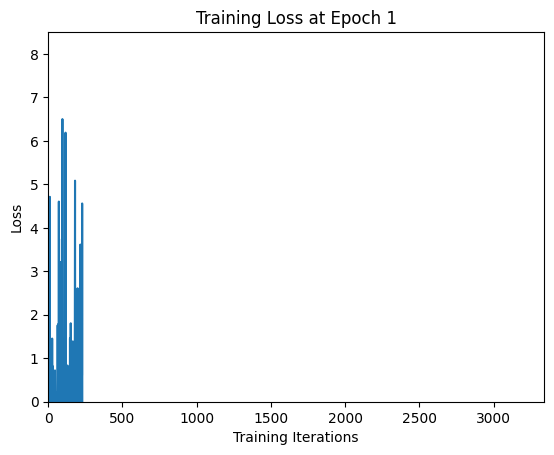

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...


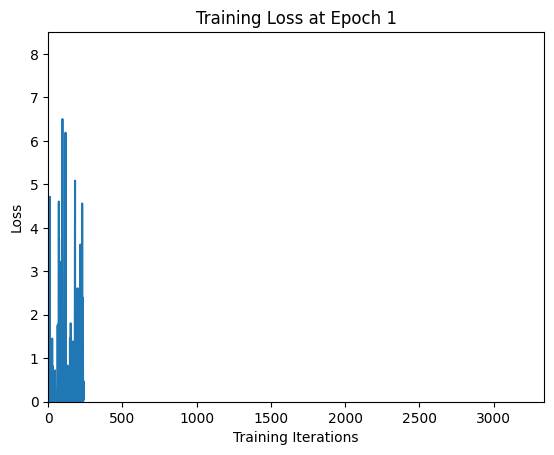

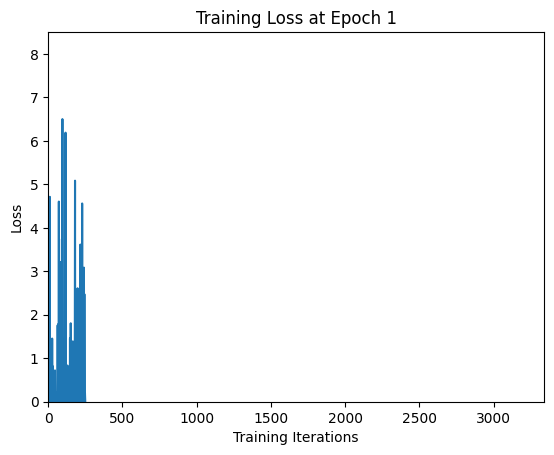

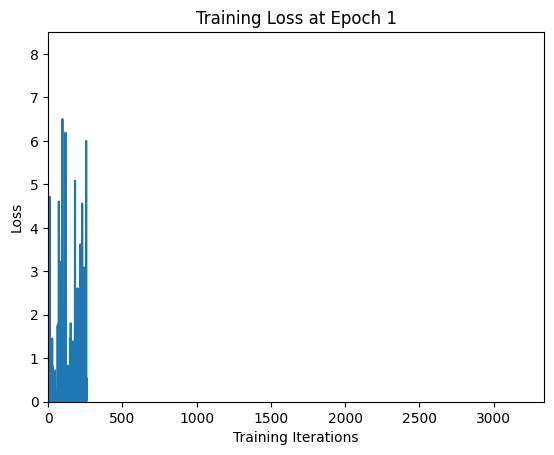

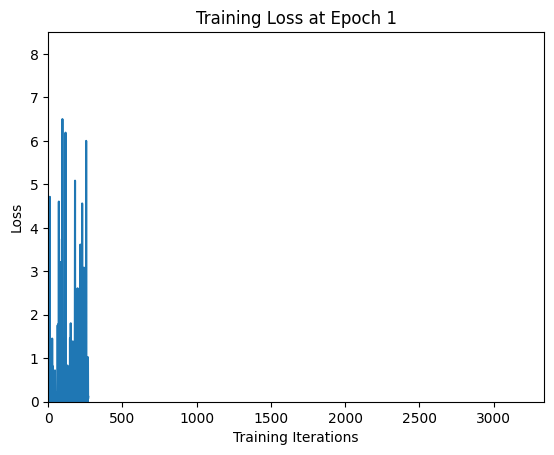

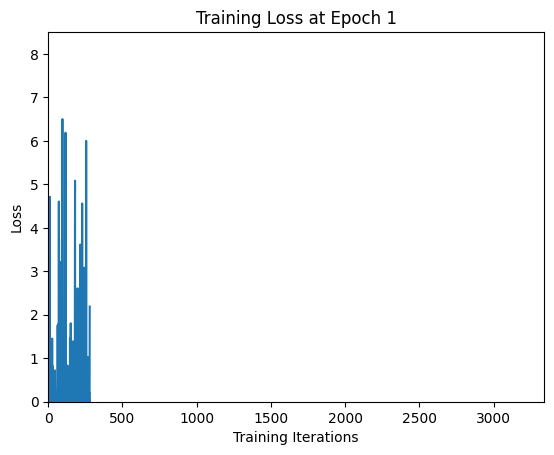

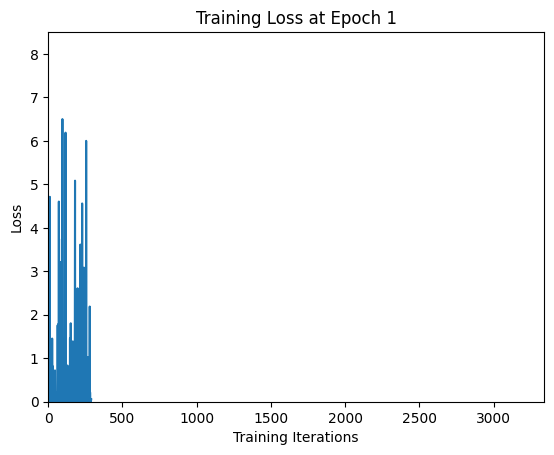

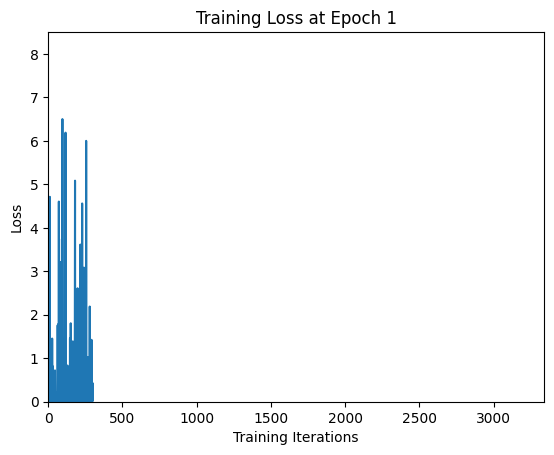

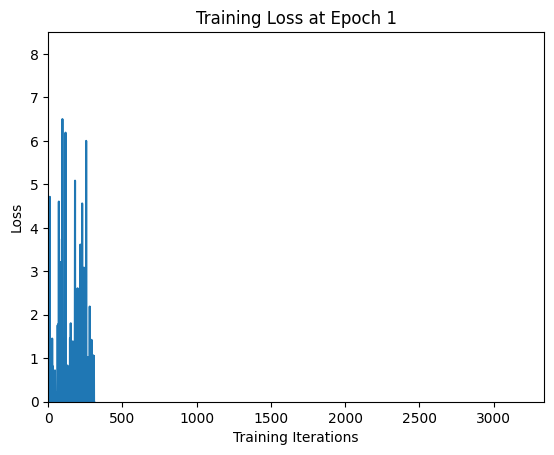

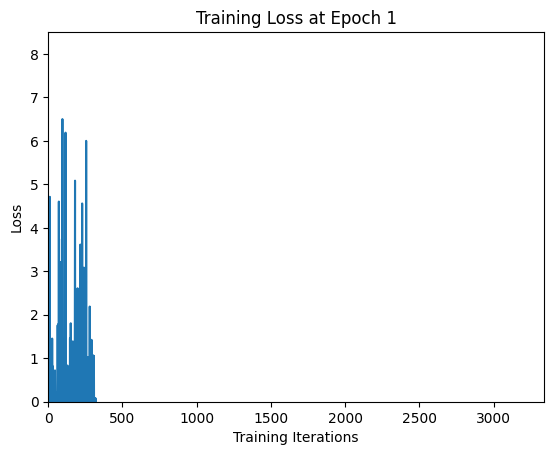

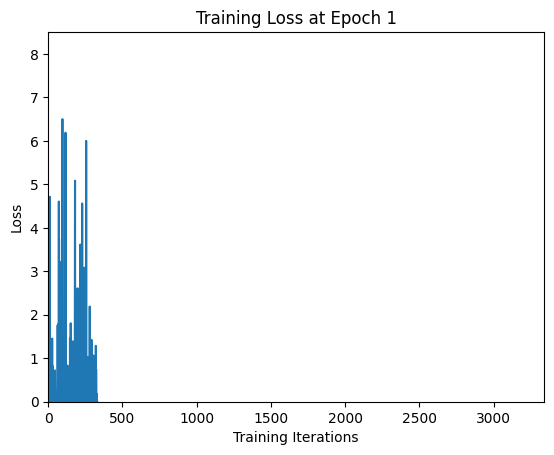

Average Loss after Epoch 1: 0.4013551652827317

Epoch 1, Train Loss: 0.4013551652827317
Epoch 1, Validation Loss: 1.043595106338403, Validation Accuracy: 0.76
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/

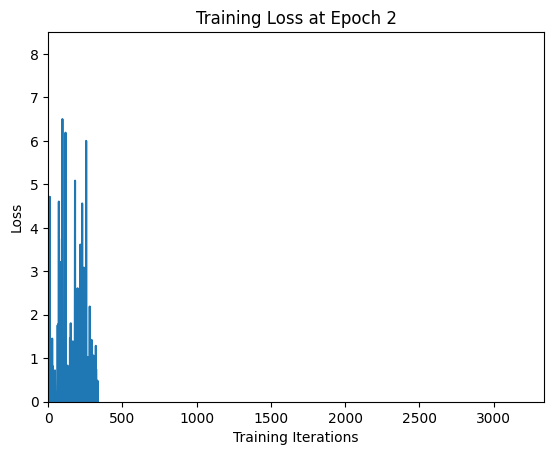

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...


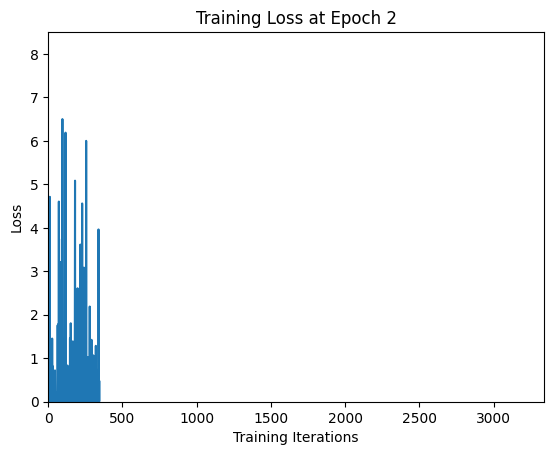

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...


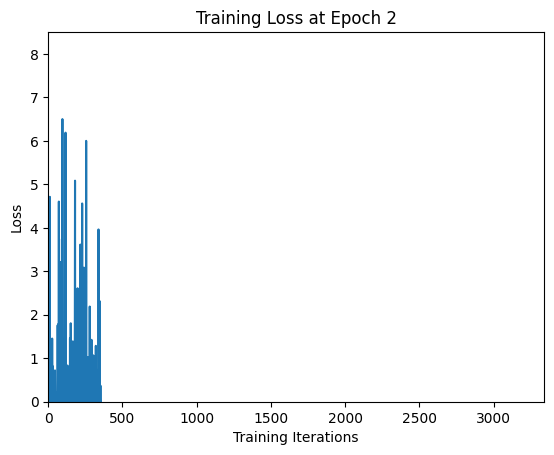

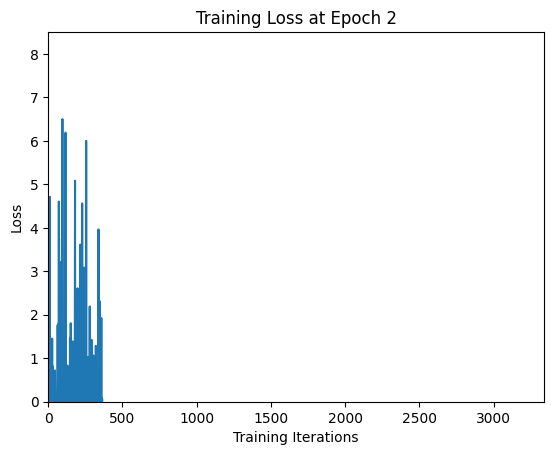

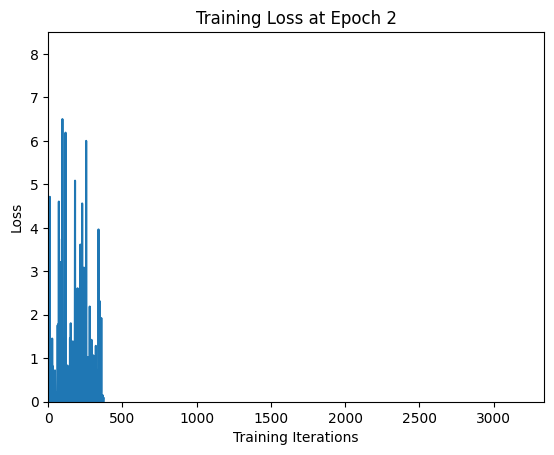

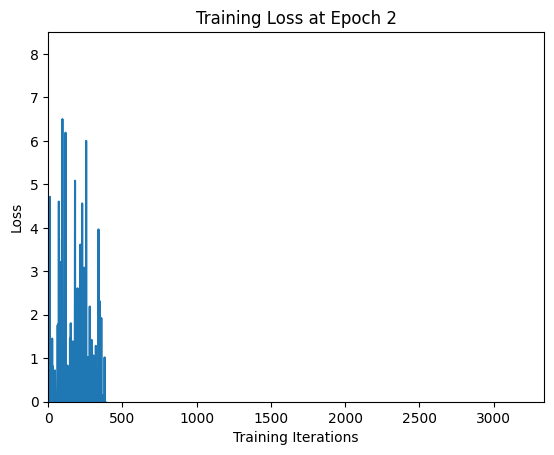

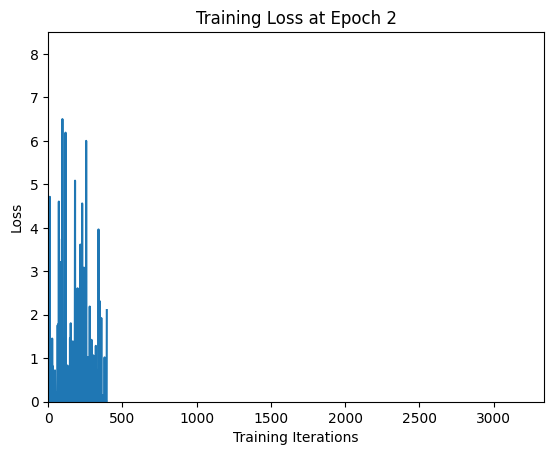

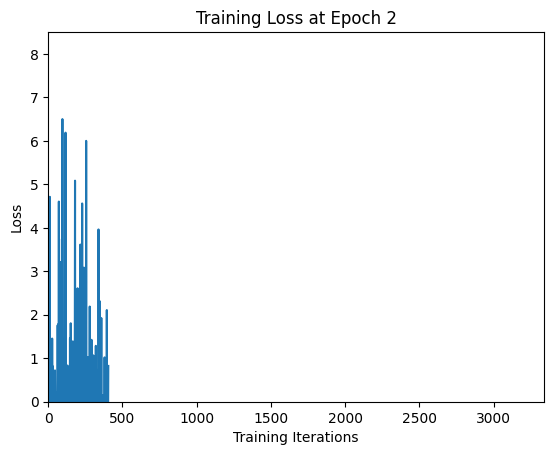

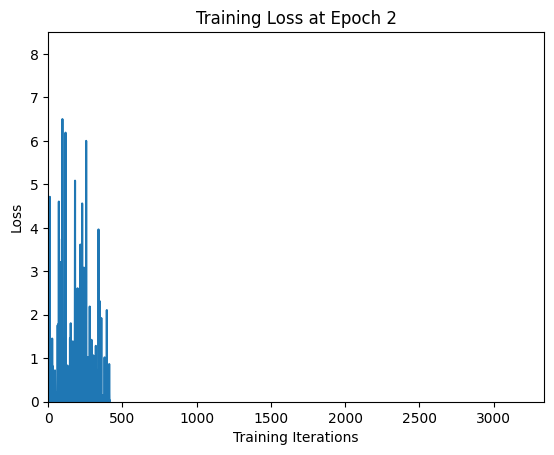

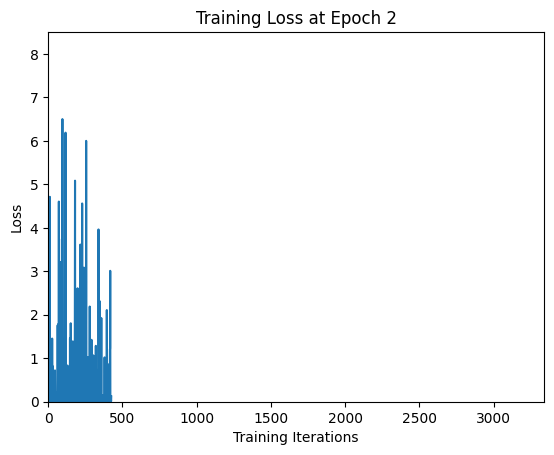

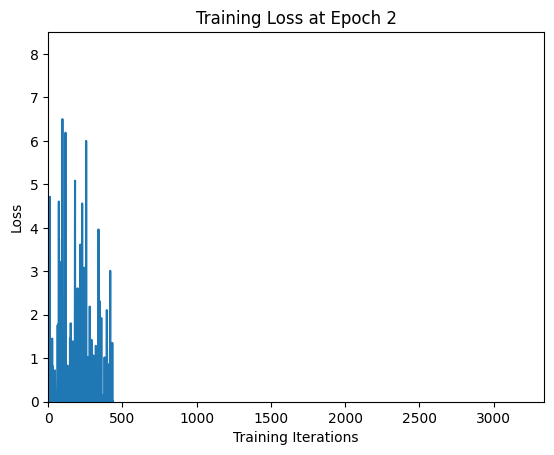

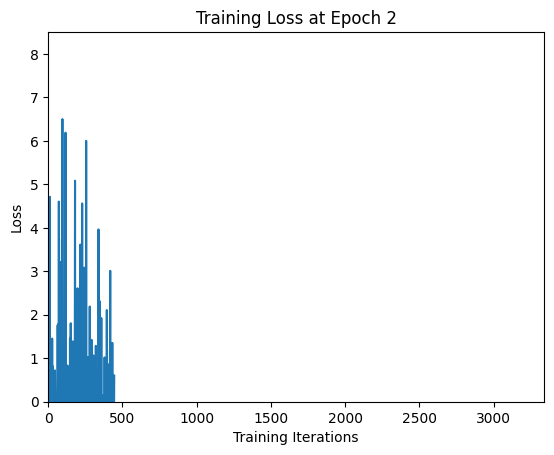

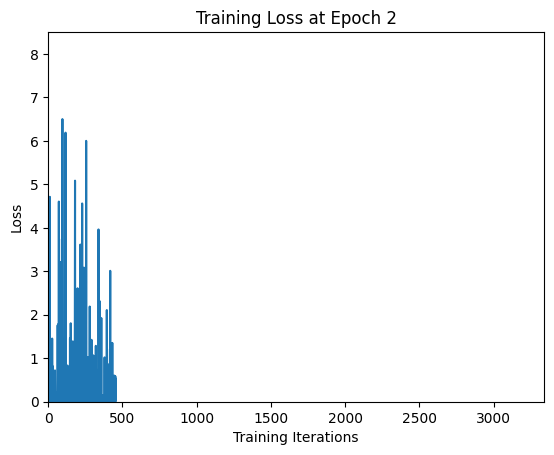

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT037_ANALYSIS/CT037_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_5.wav. Skipping...


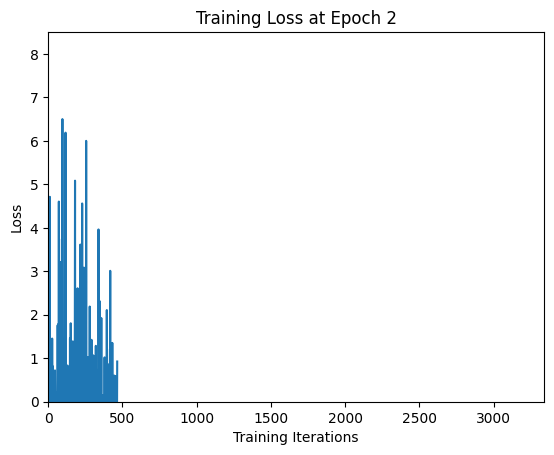

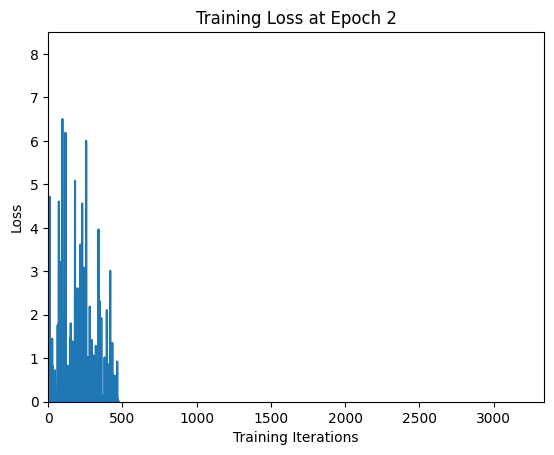

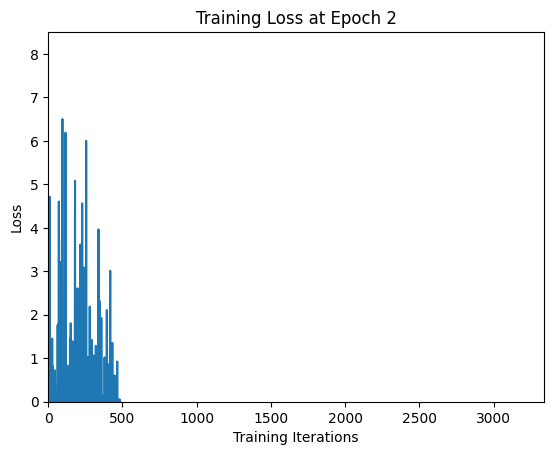

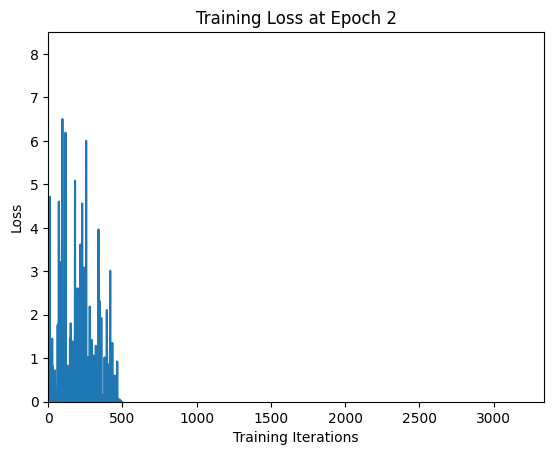

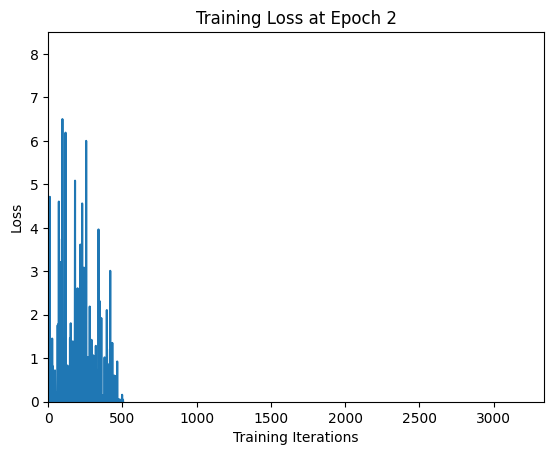

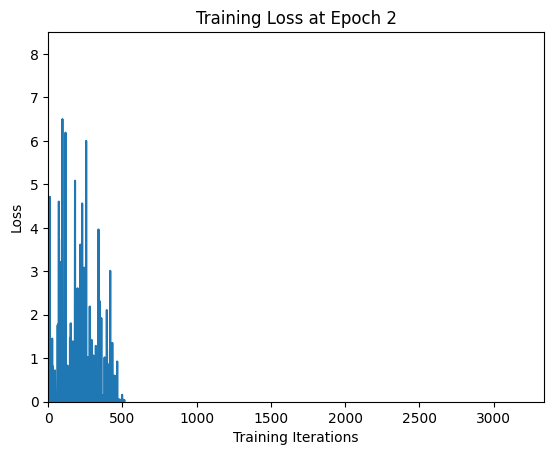

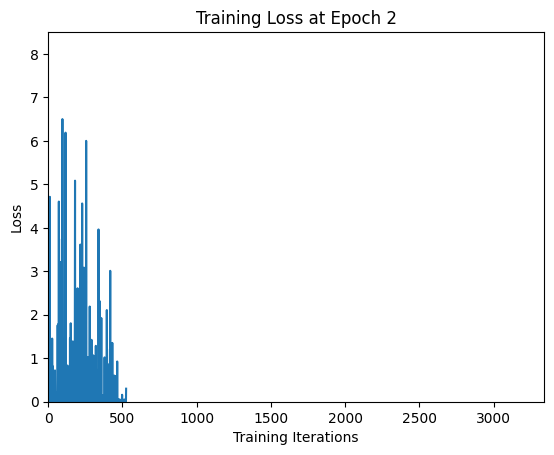

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_5.wav. Skipping...


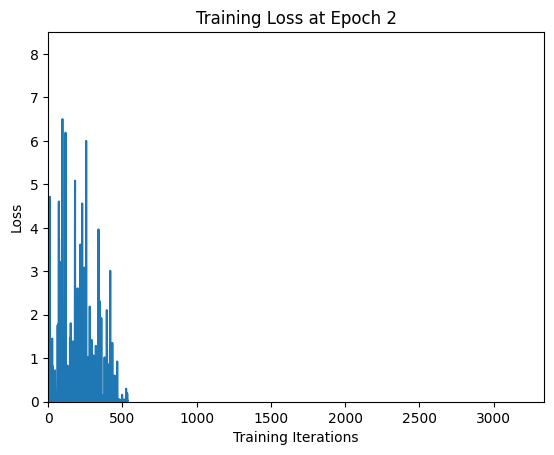

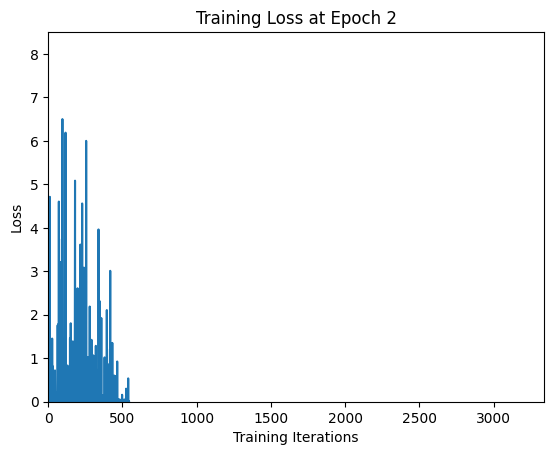

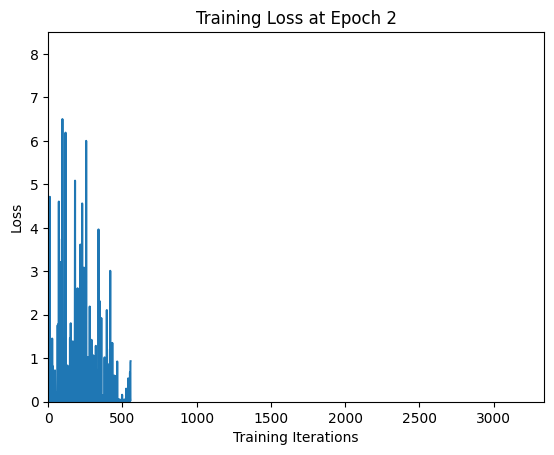

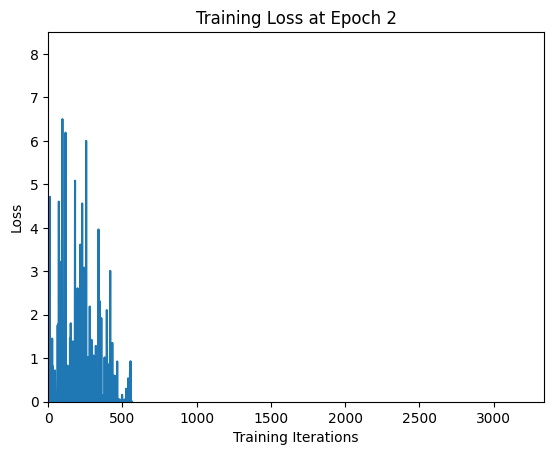

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...


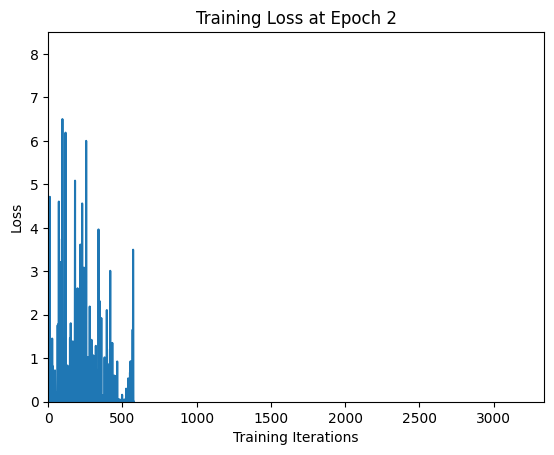

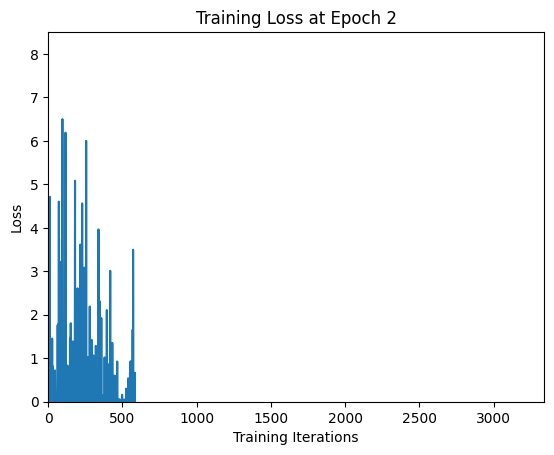

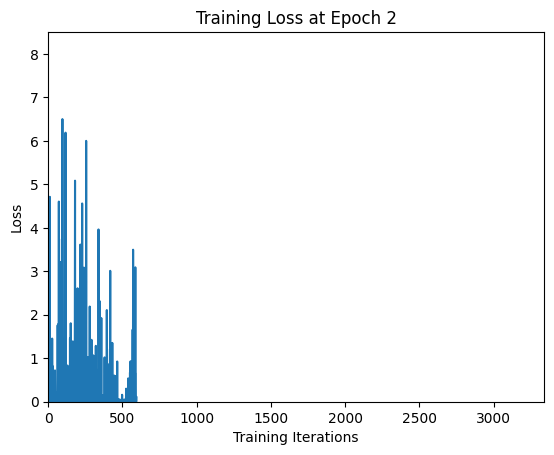

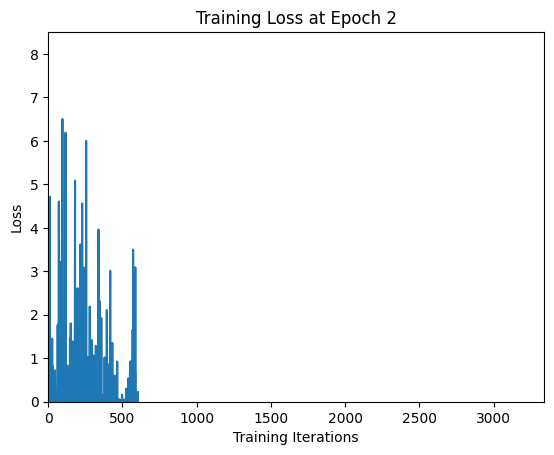

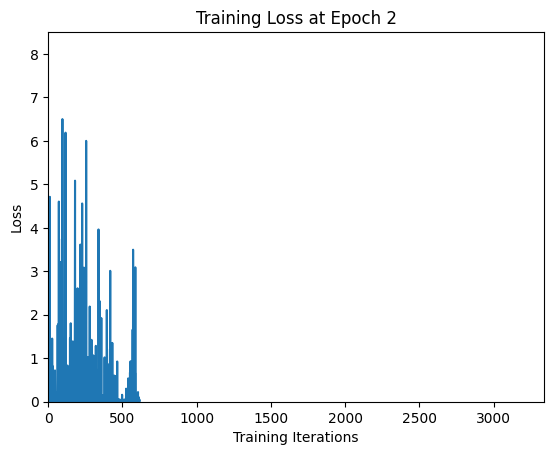

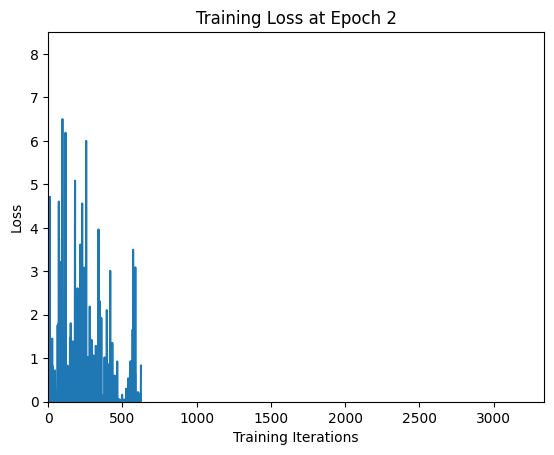

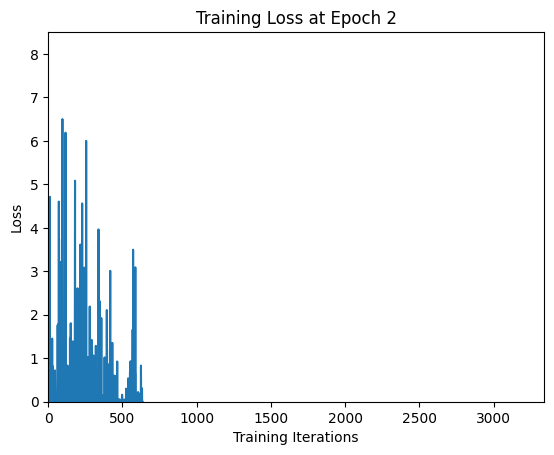

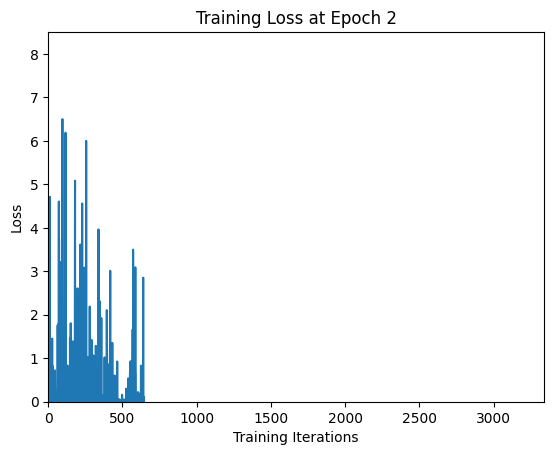

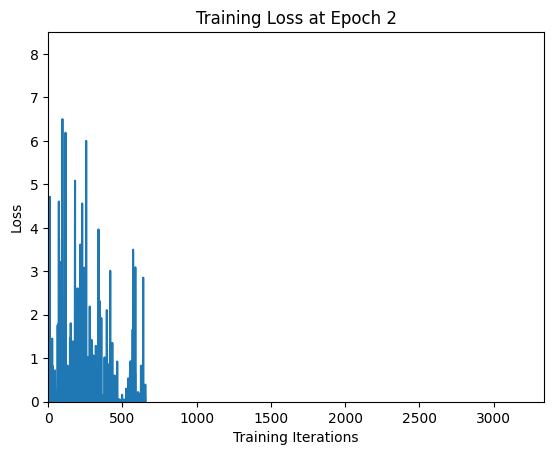

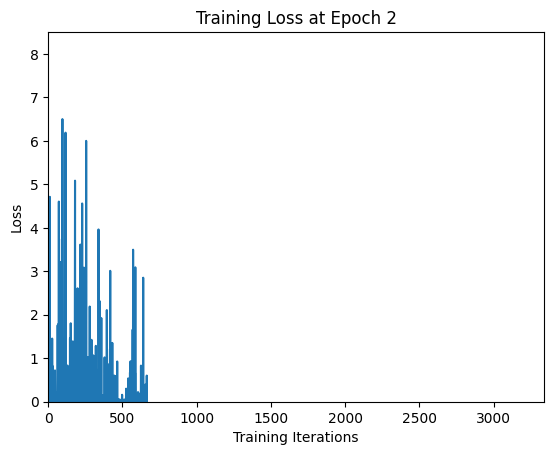

Average Loss after Epoch 2: 0.1602489381541102

Epoch 2, Train Loss: 0.1602489381541102
Epoch 2, Validation Loss: 0.5659594494633454, Validation Accuracy: 0.84
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav


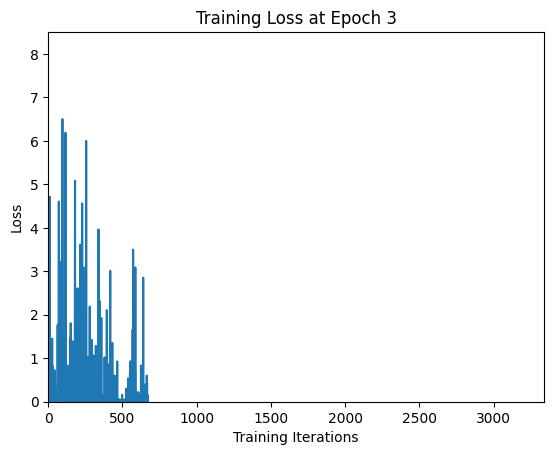

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...


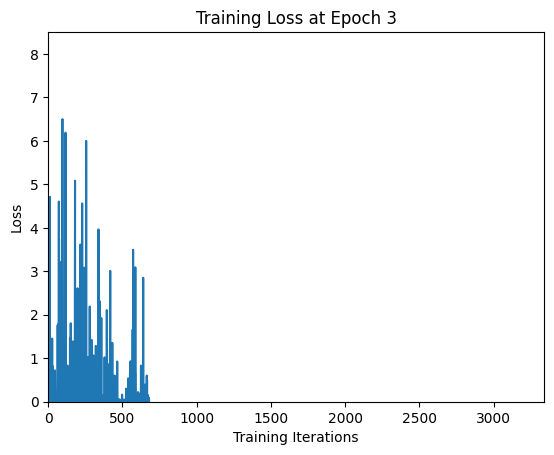

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...


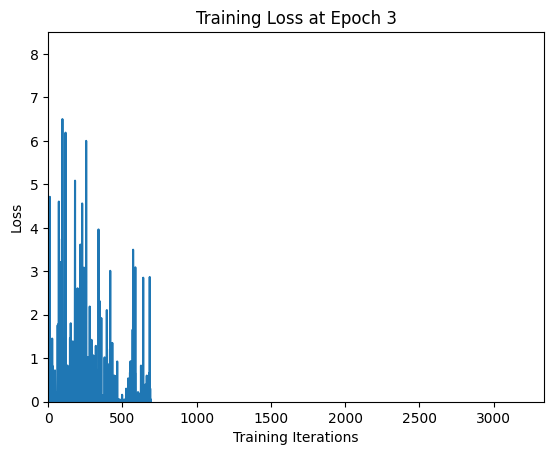

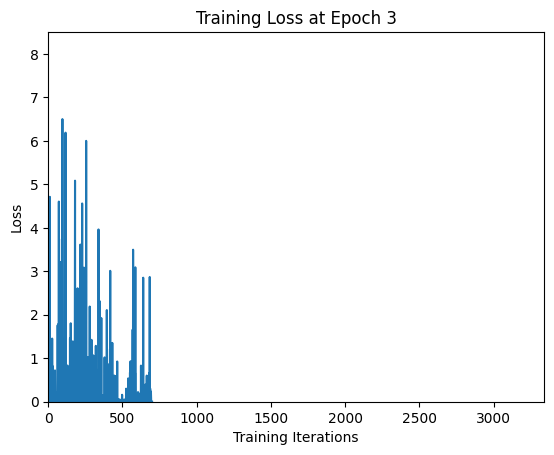

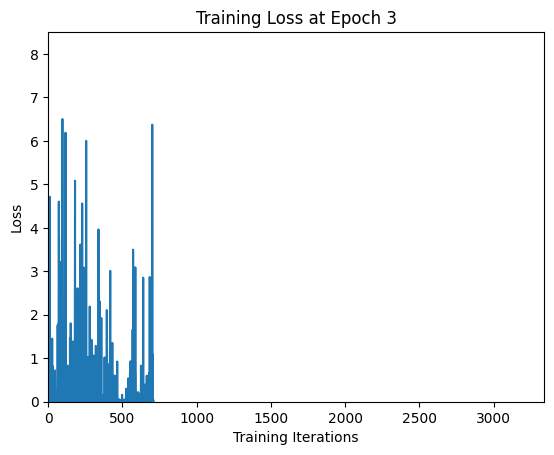

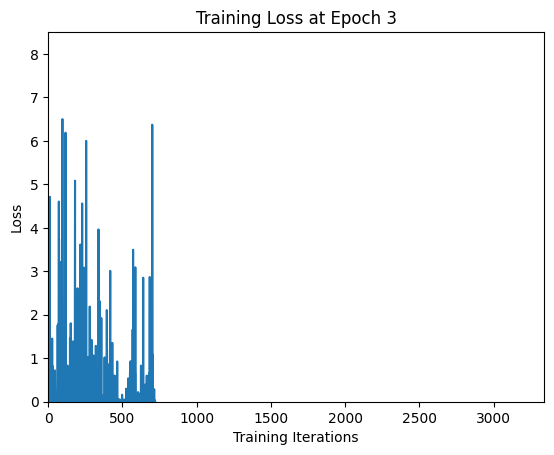

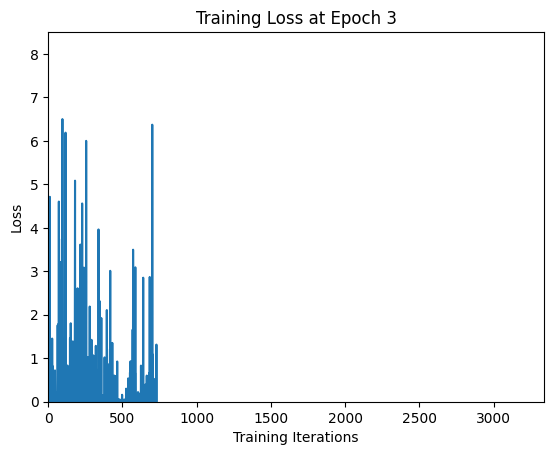

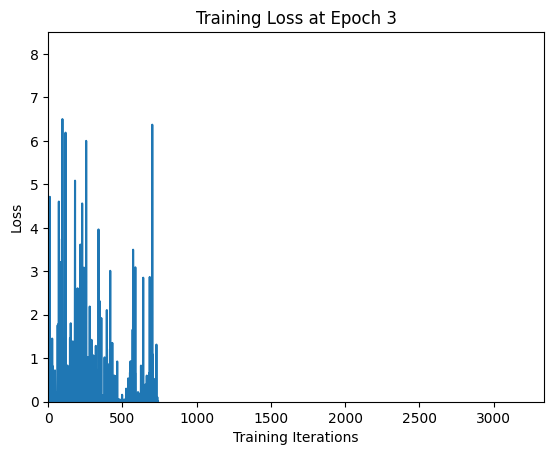

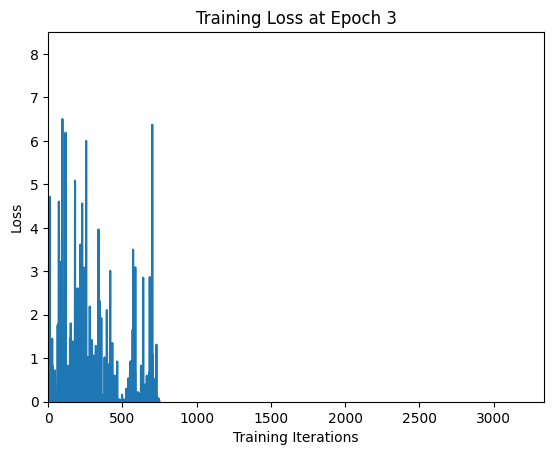

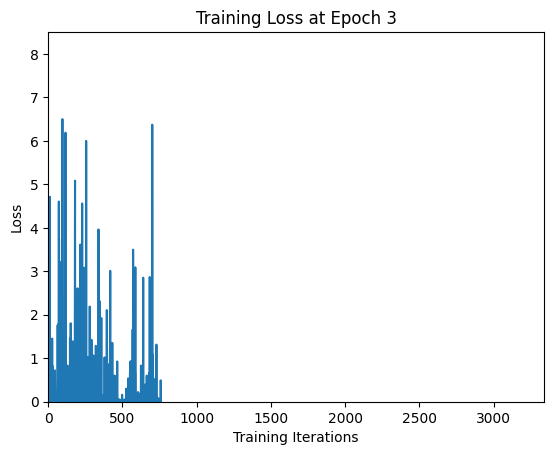

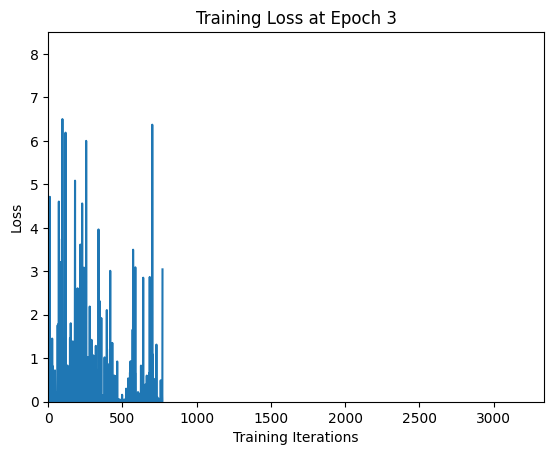

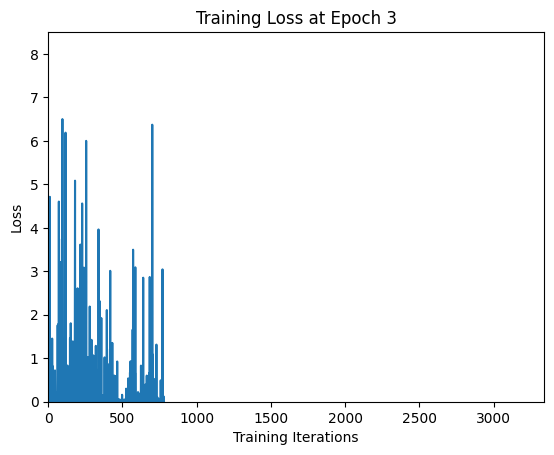

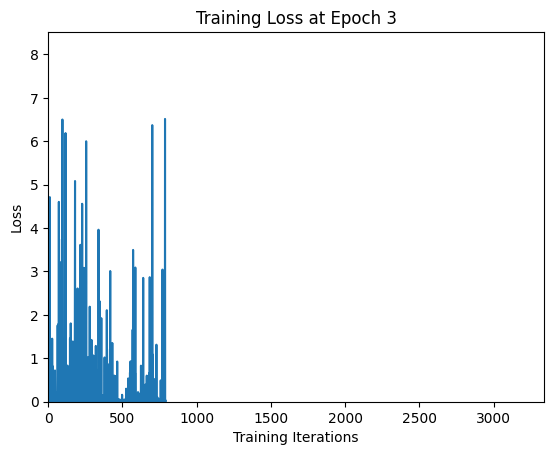

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT037_ANALYSIS/CT037_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_5.wav. Skipping...


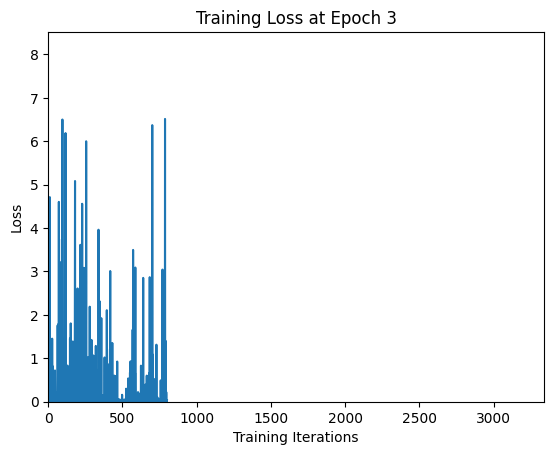

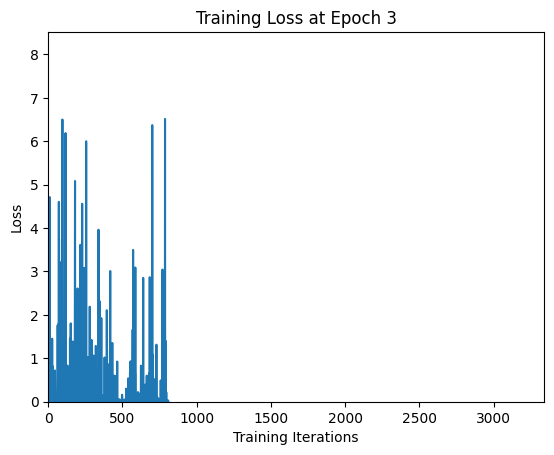

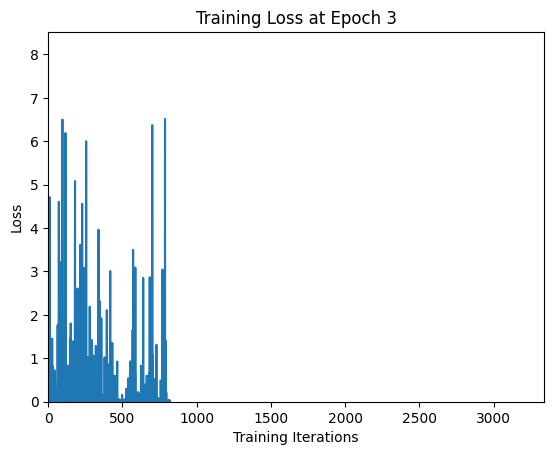

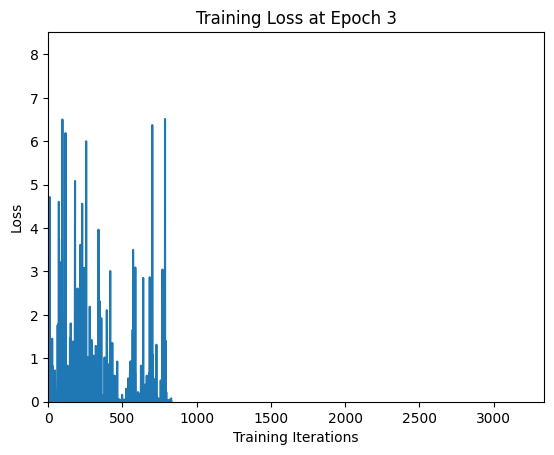

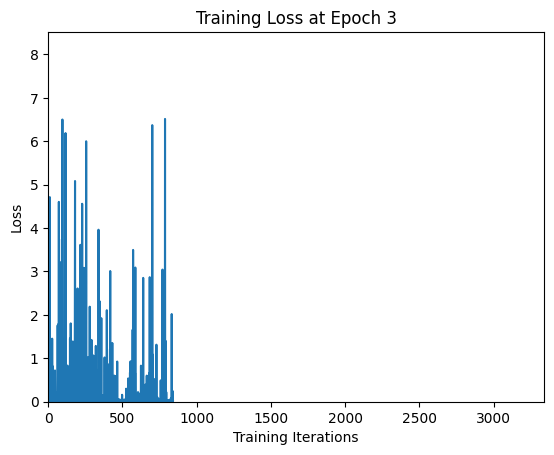

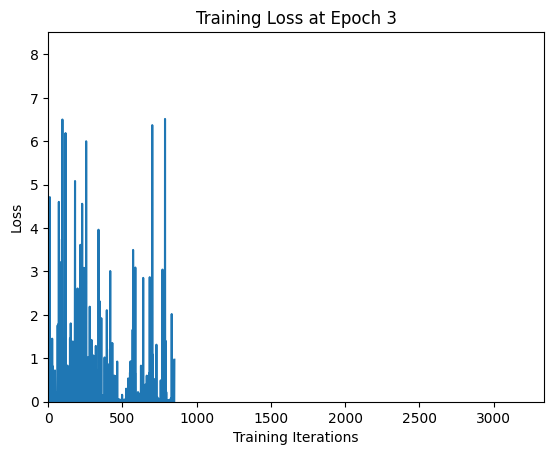

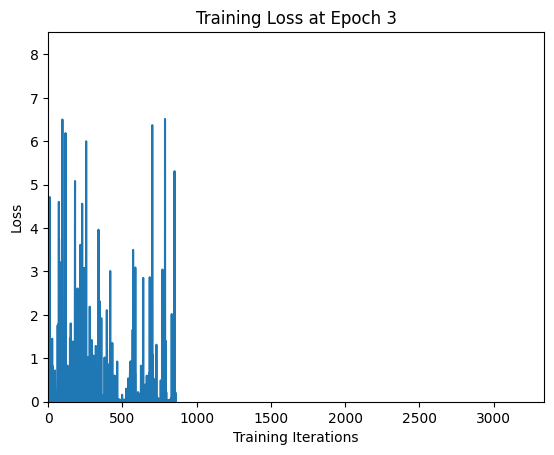

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_5.wav. Skipping...


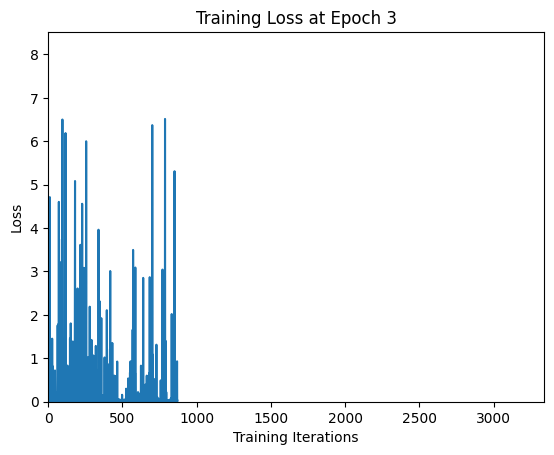

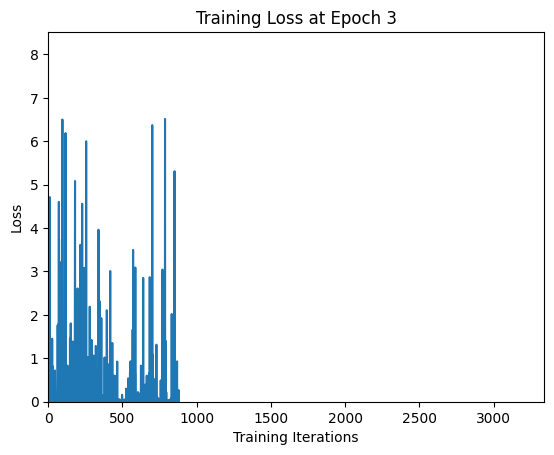

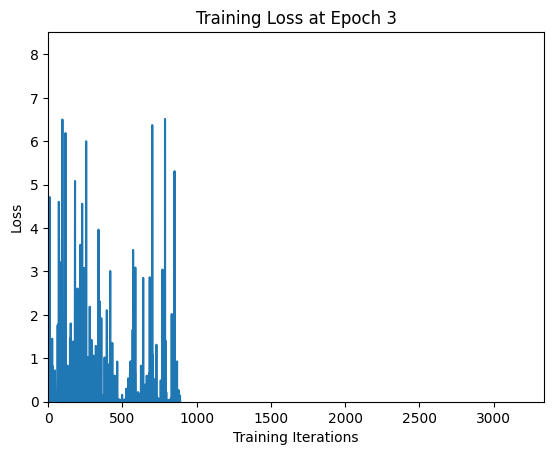

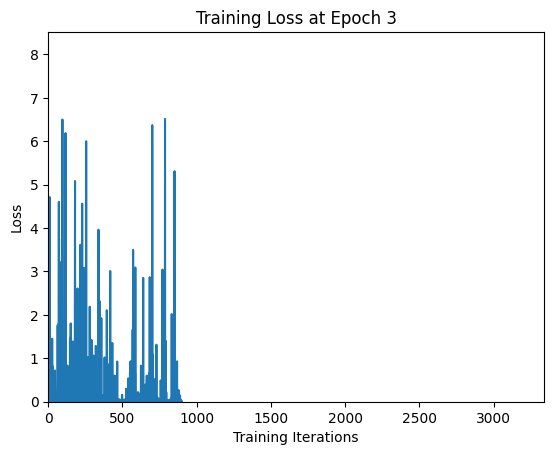

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...


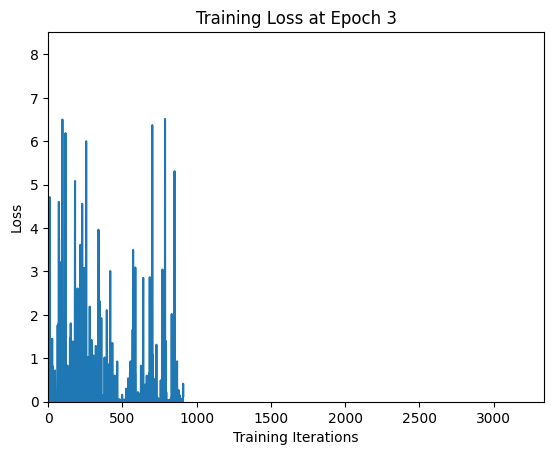

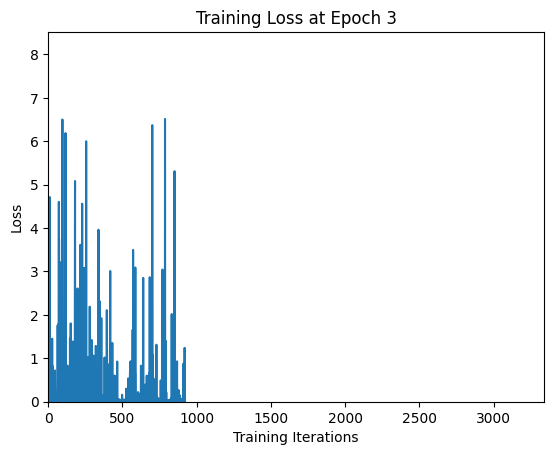

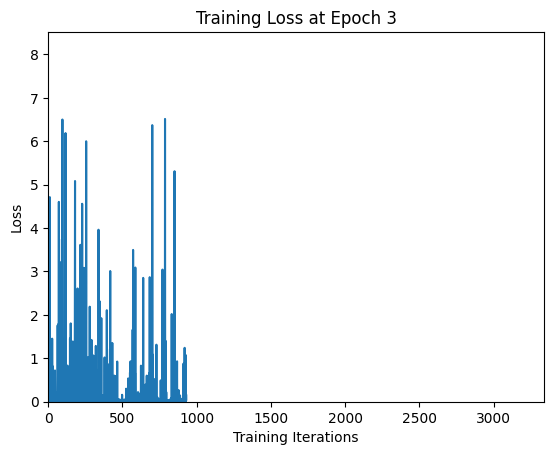

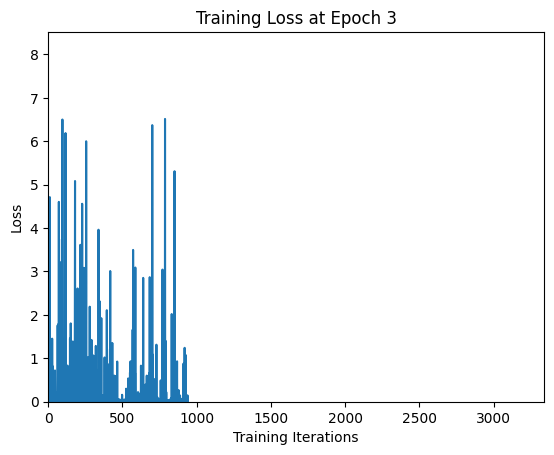

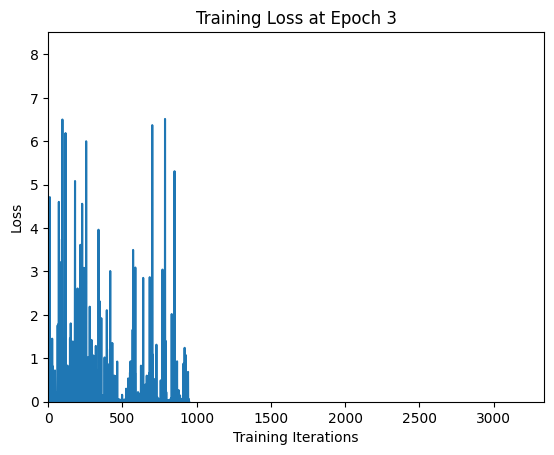

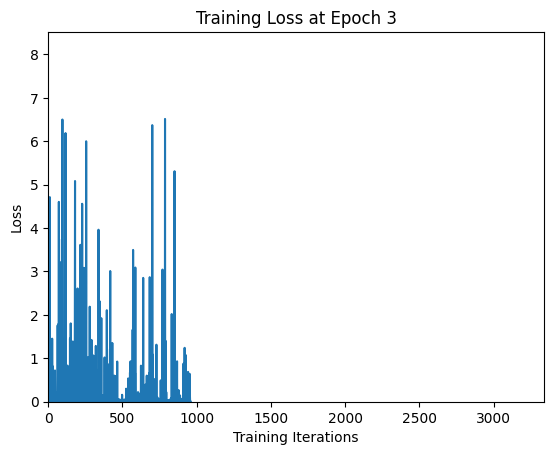

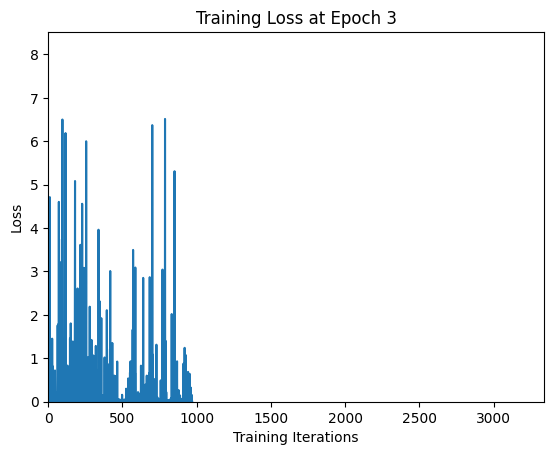

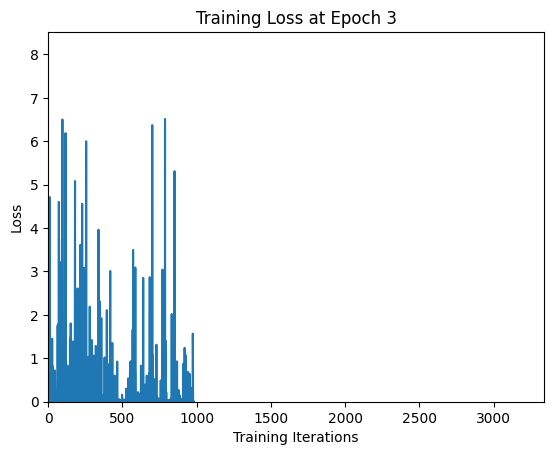

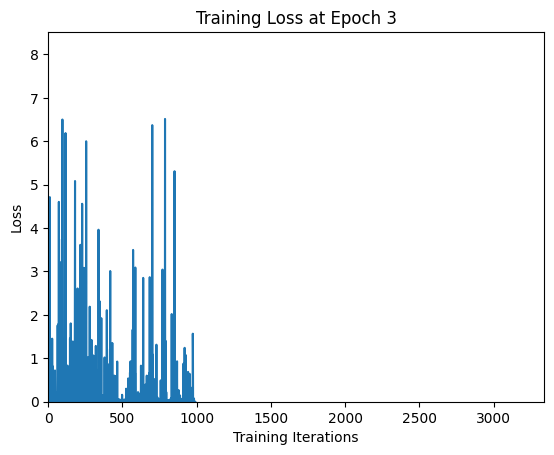

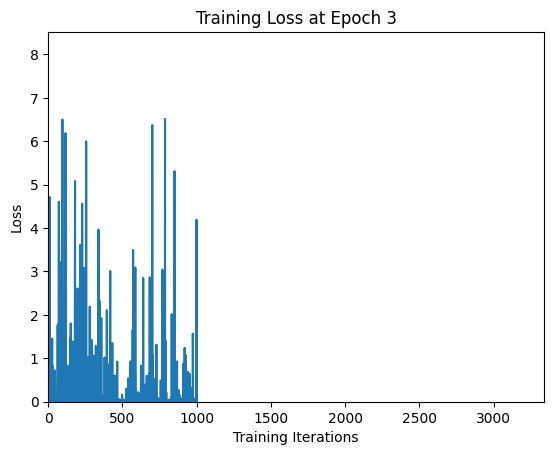

Average Loss after Epoch 3: 0.17387129555653438

Epoch 3, Train Loss: 0.17387129555653438
Epoch 3, Validation Loss: 0.5666494989484685, Validation Accuracy: 0.89
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wa

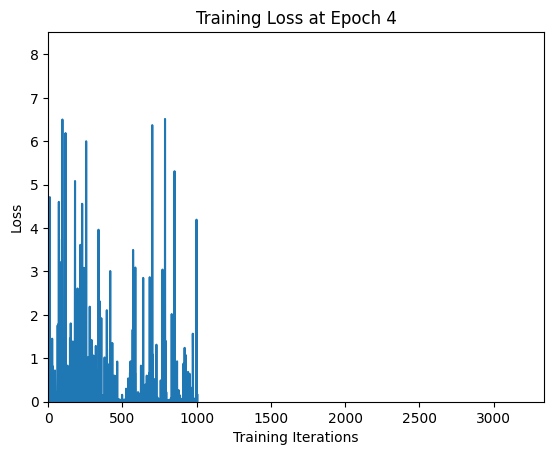

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...


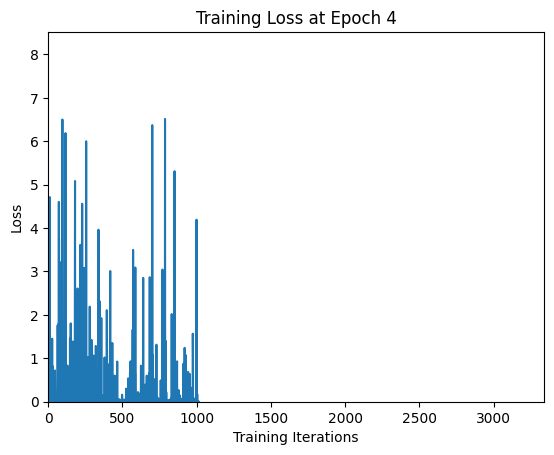

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...


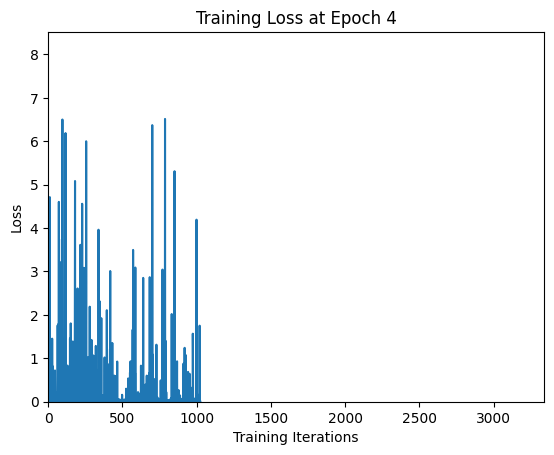

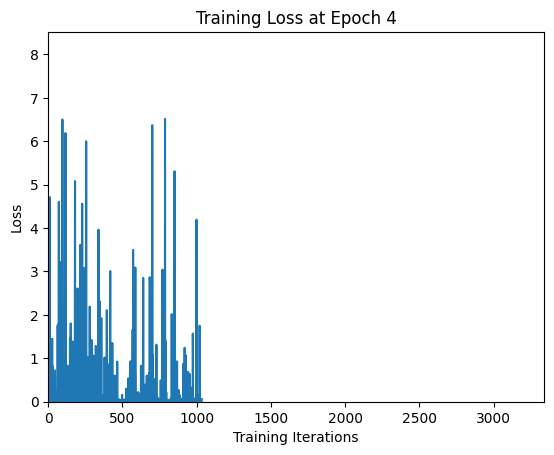

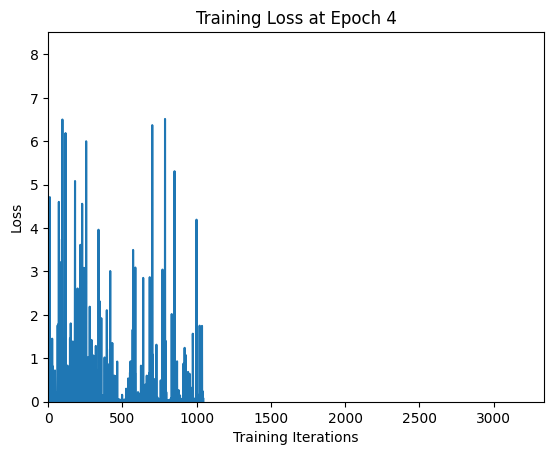

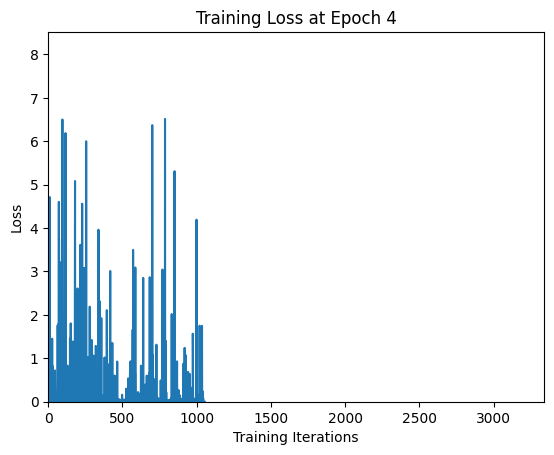

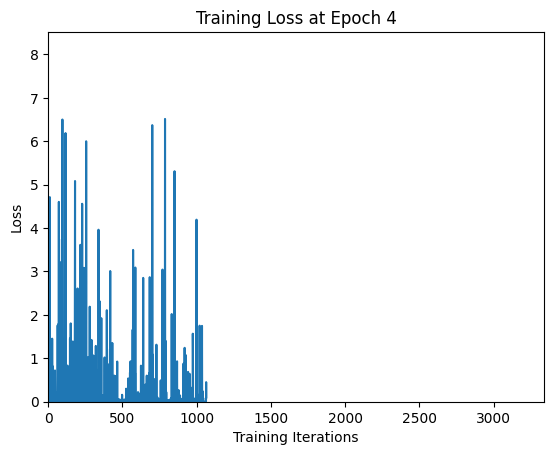

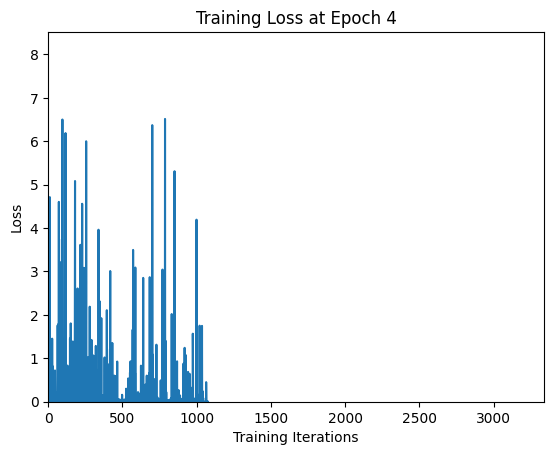

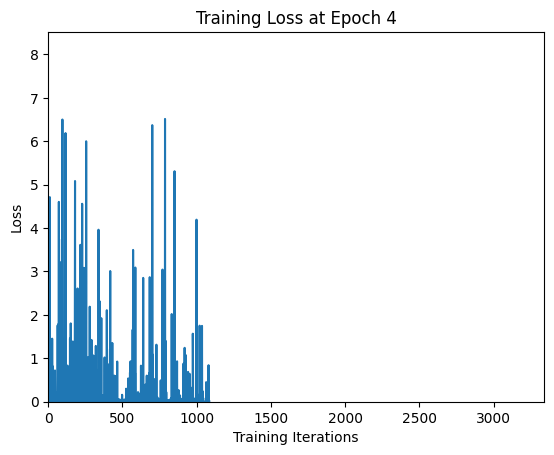

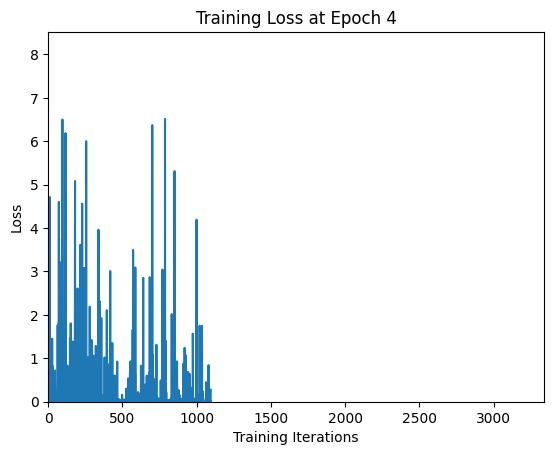

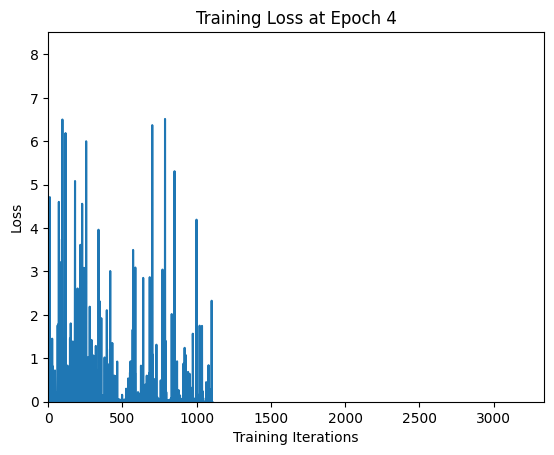

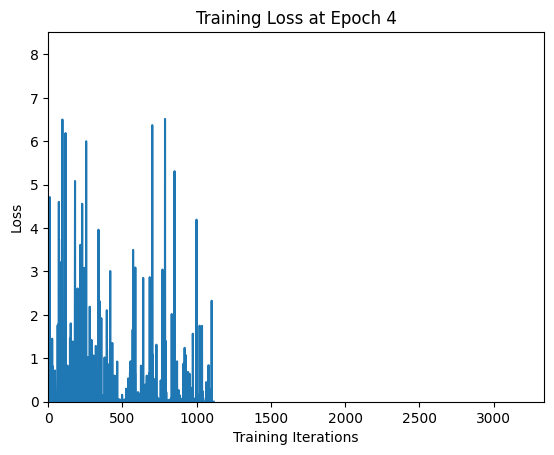

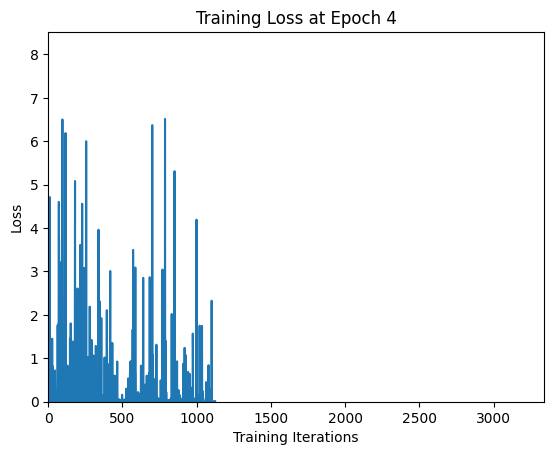

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT037_ANALYSIS/CT037_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_5.wav. Skipping...


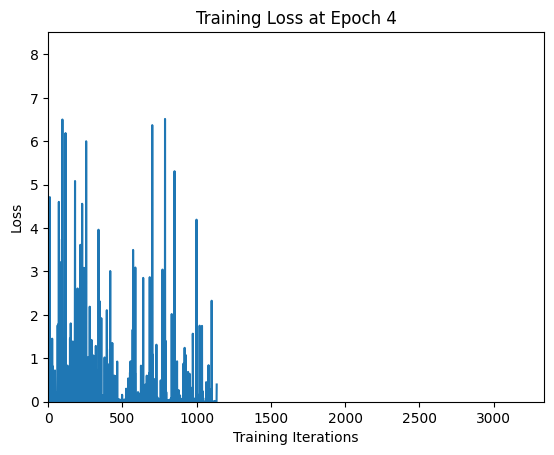

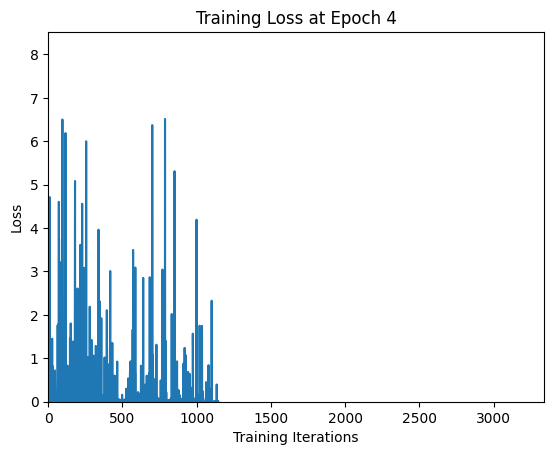

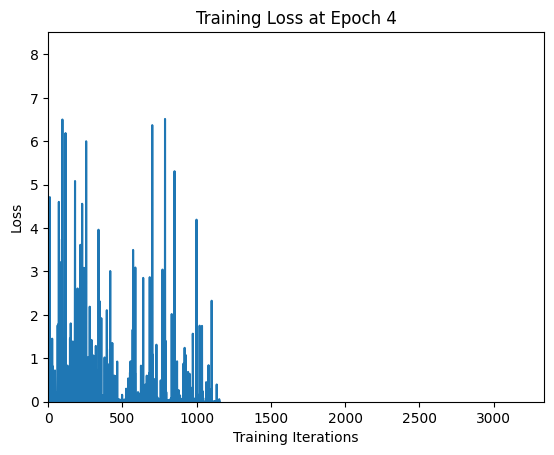

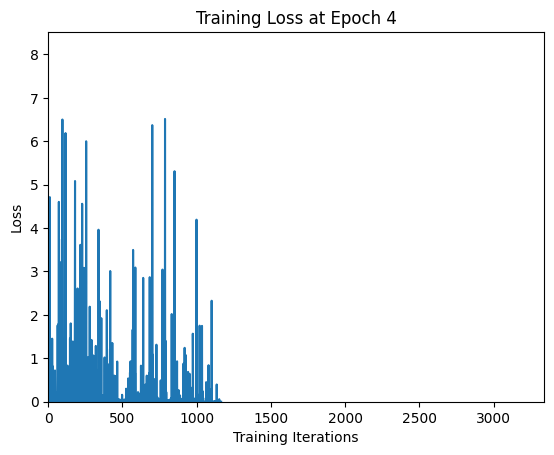

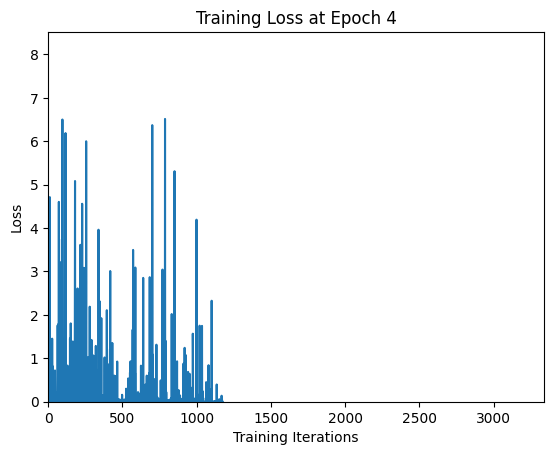

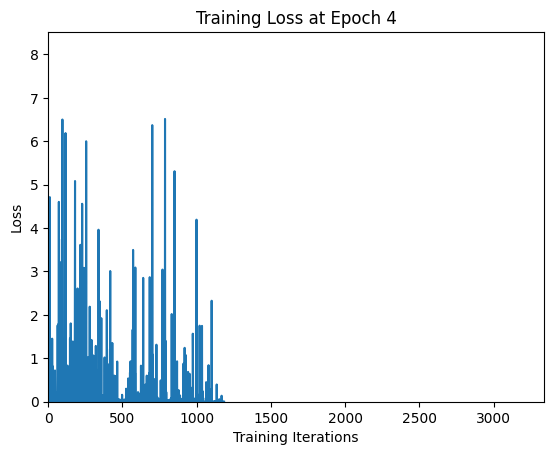

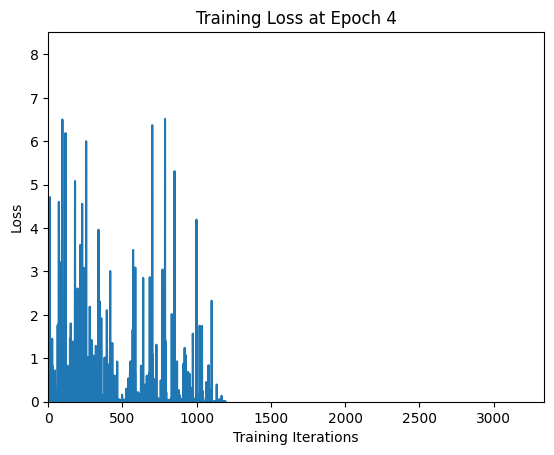

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_5.wav. Skipping...


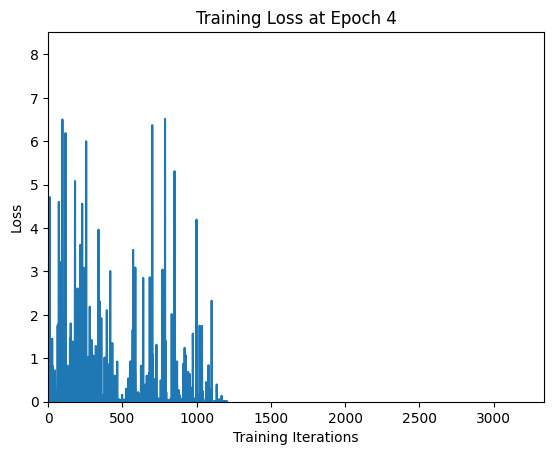

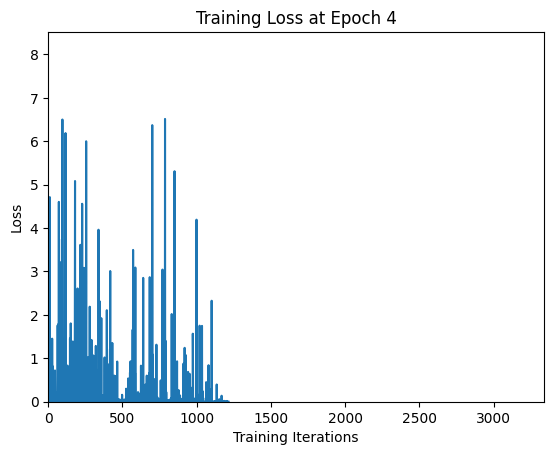

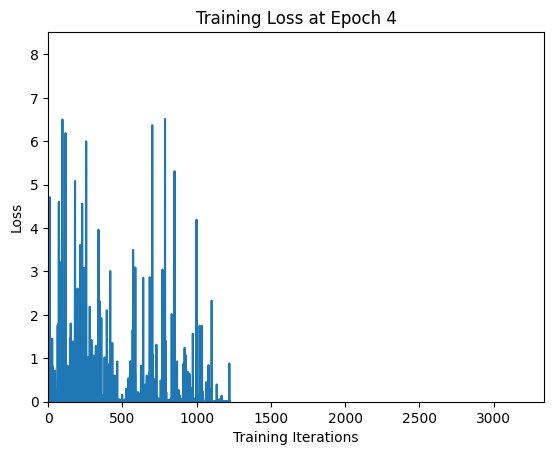

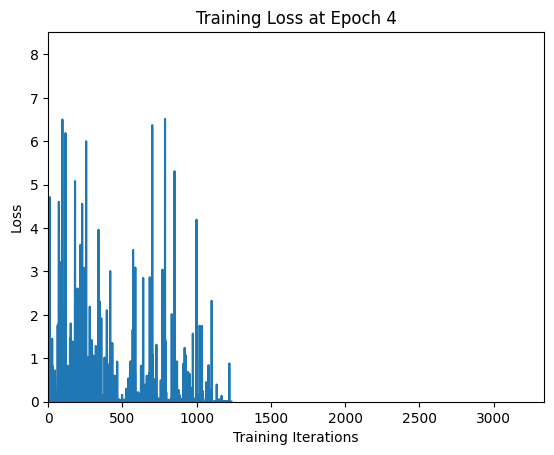

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...


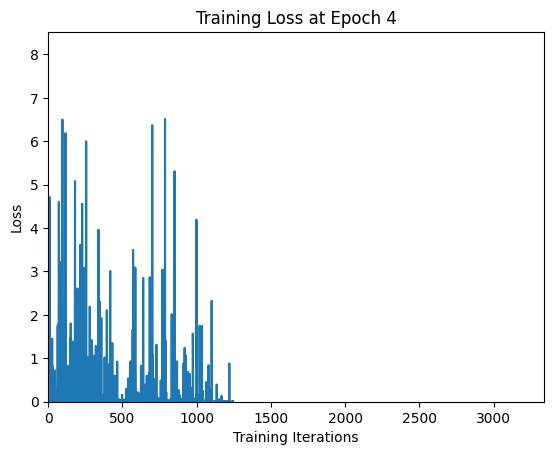

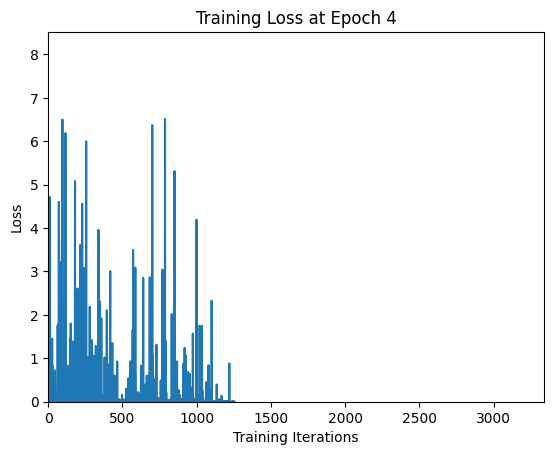

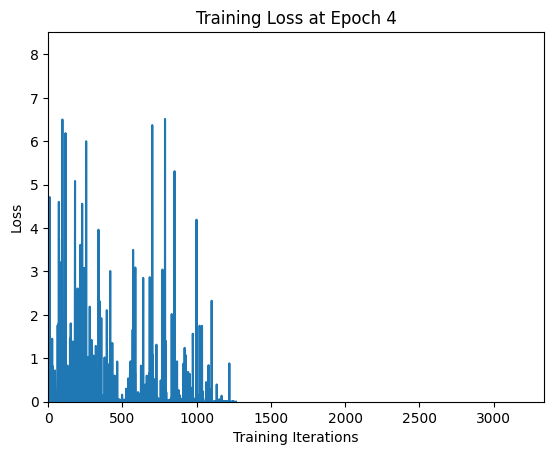

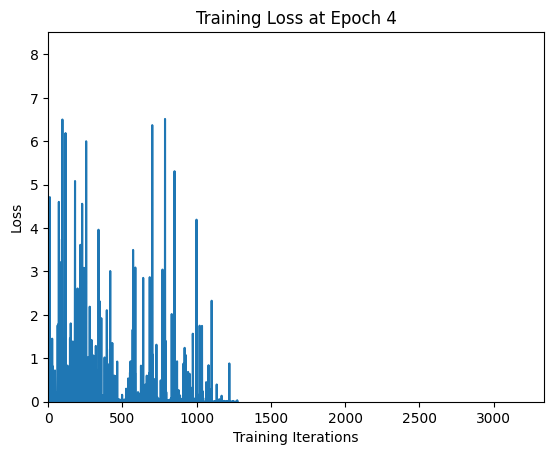

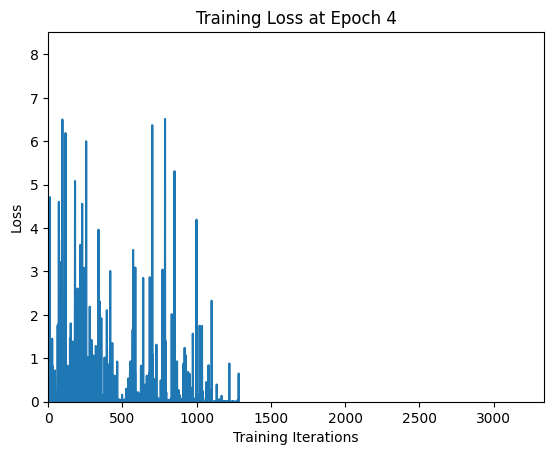

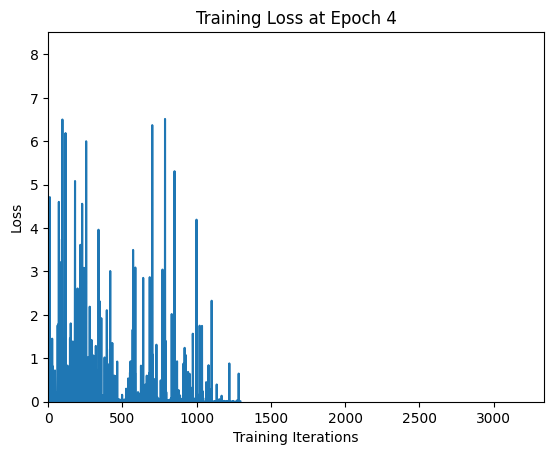

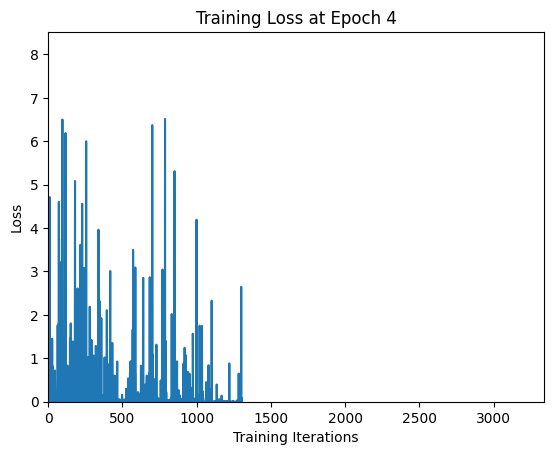

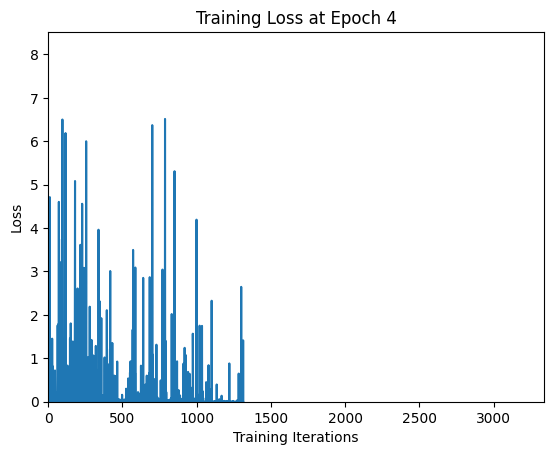

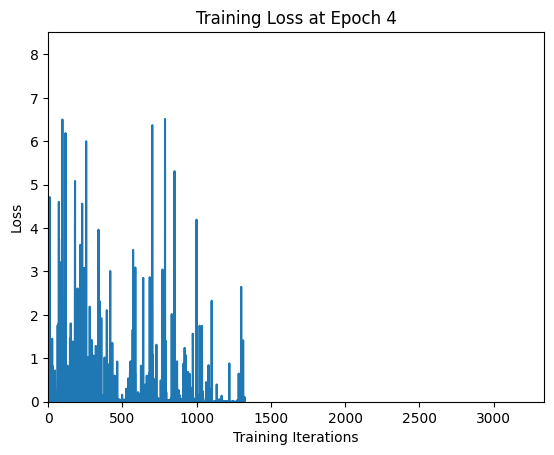

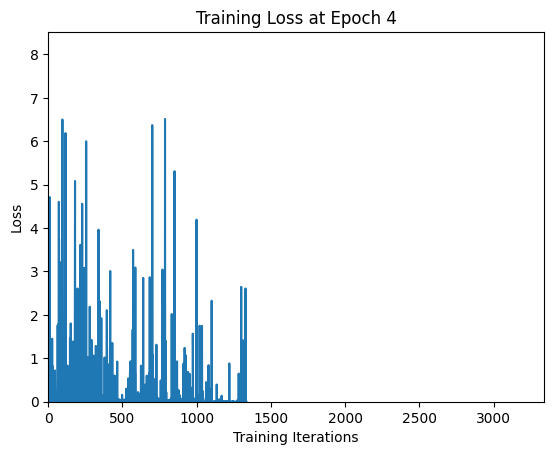

Average Loss after Epoch 4: 0.05336339357762596

Epoch 4, Train Loss: 0.05336339357762596
Epoch 4, Validation Loss: 0.762730779807636, Validation Accuracy: 0.83
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav

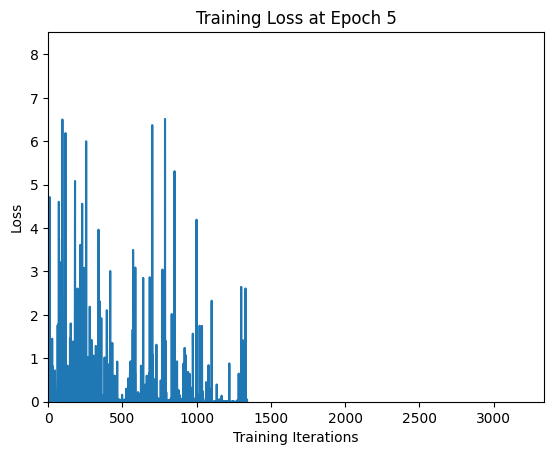

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...


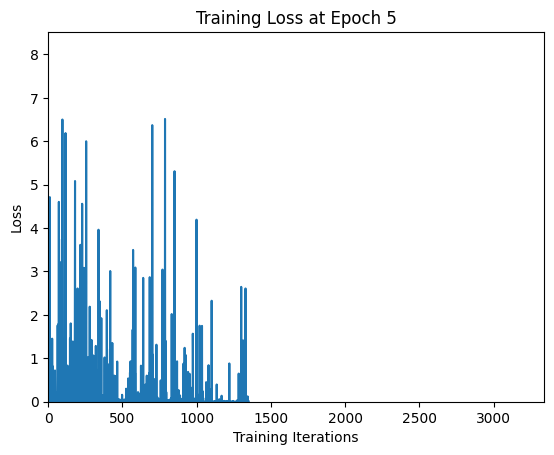

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...


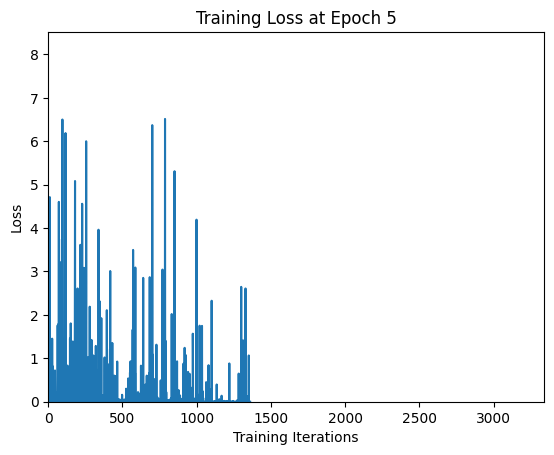

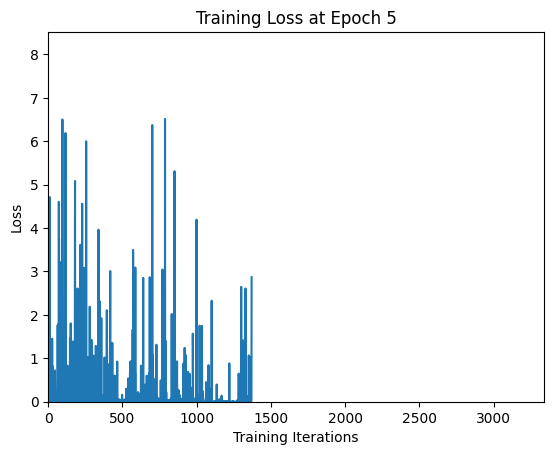

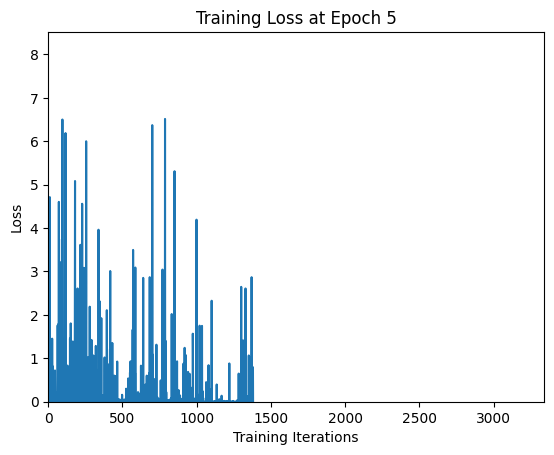

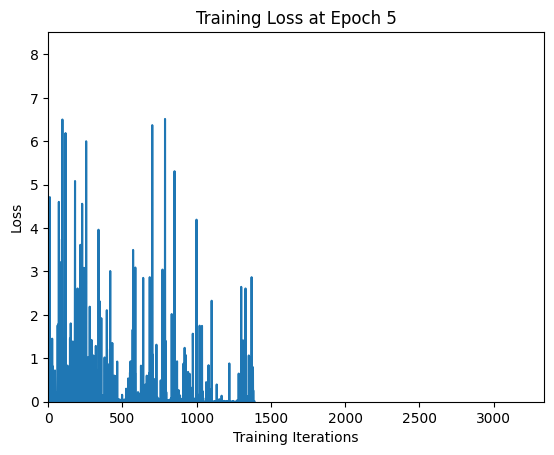

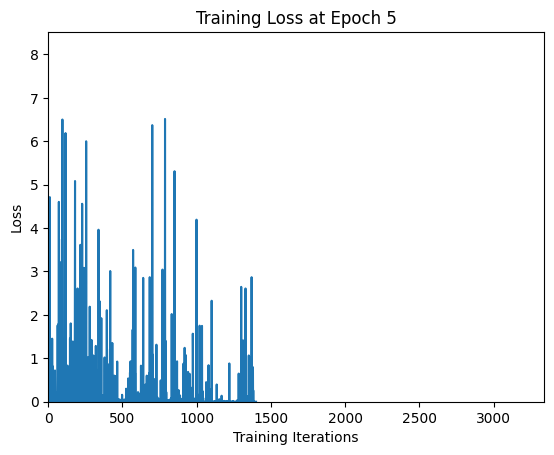

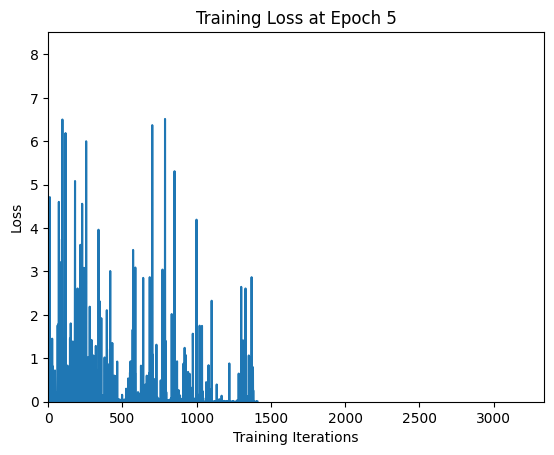

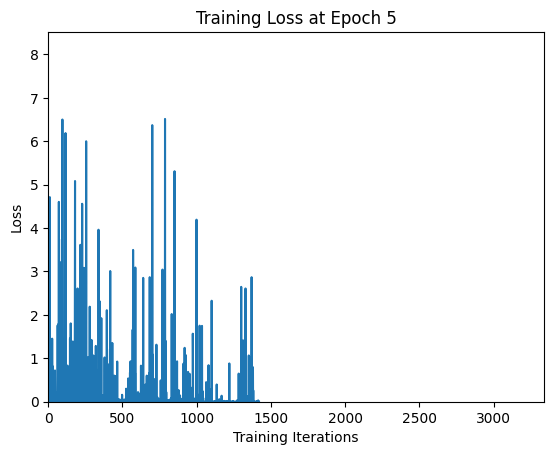

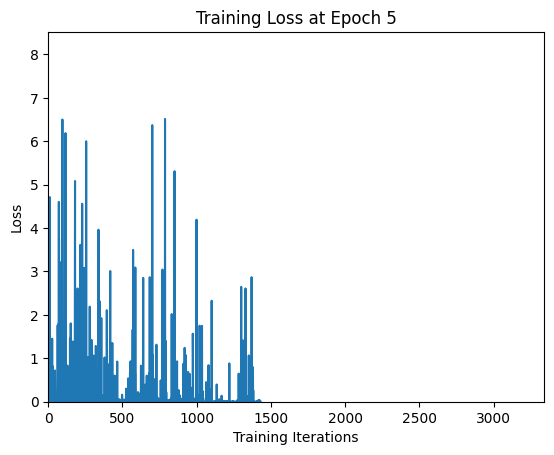

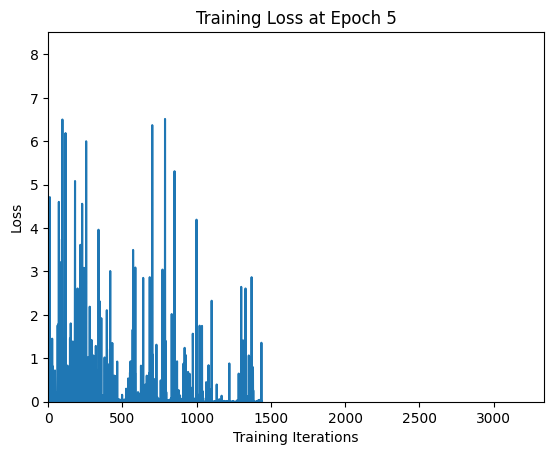

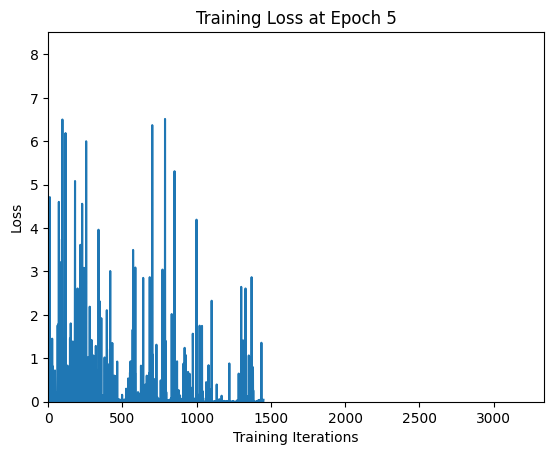

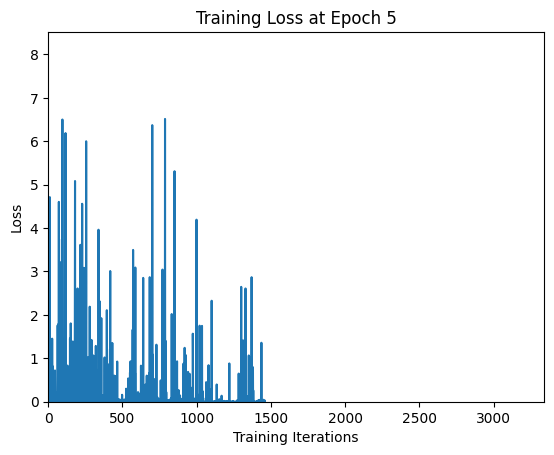

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT037_ANALYSIS/CT037_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_5.wav. Skipping...


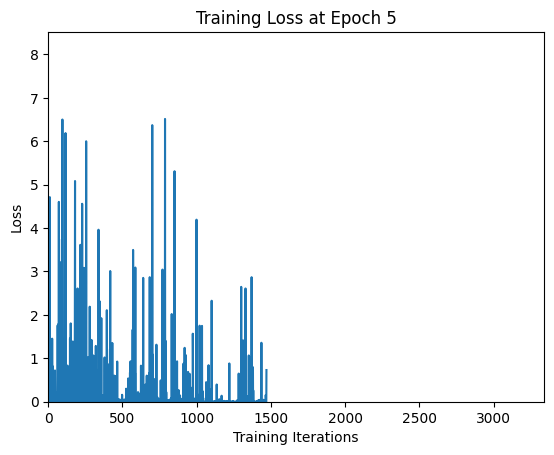

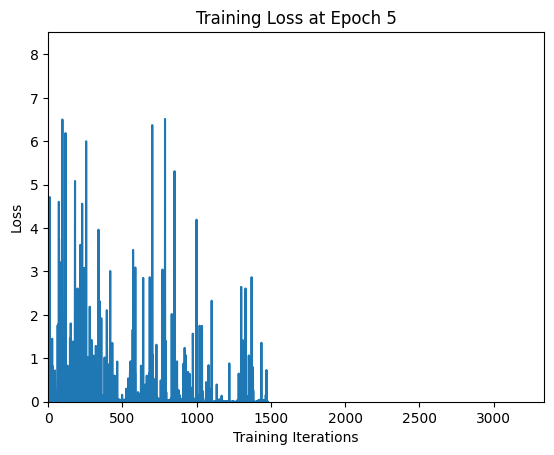

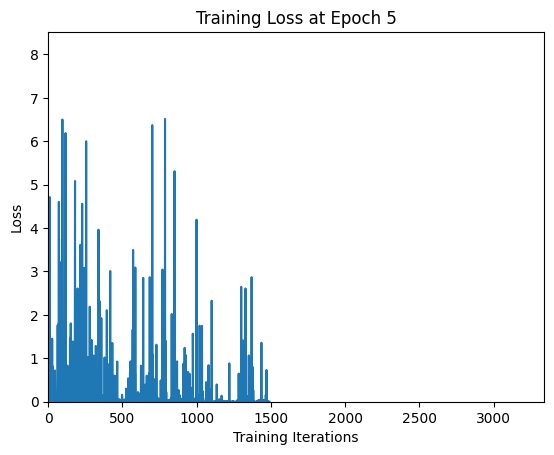

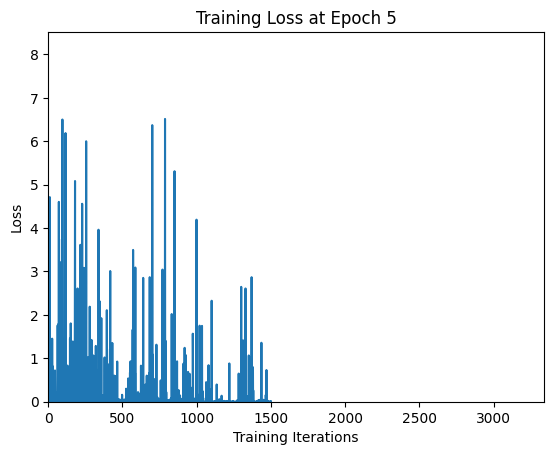

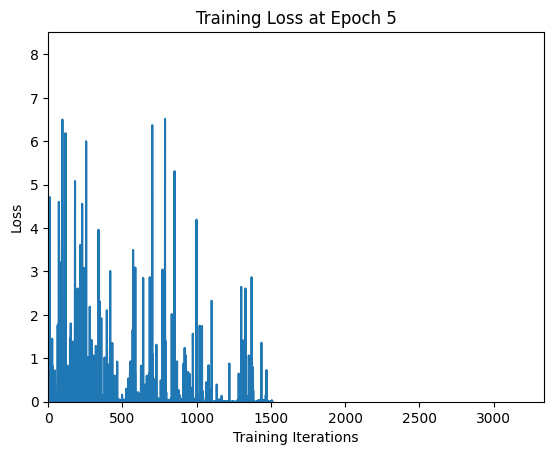

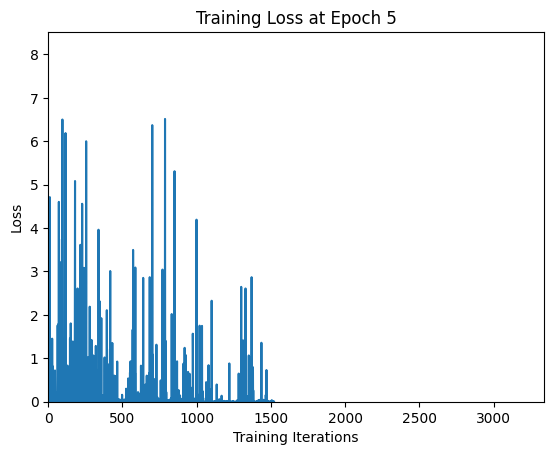

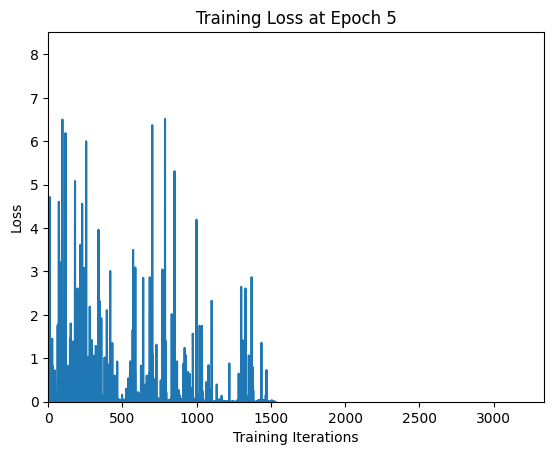

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_5.wav. Skipping...


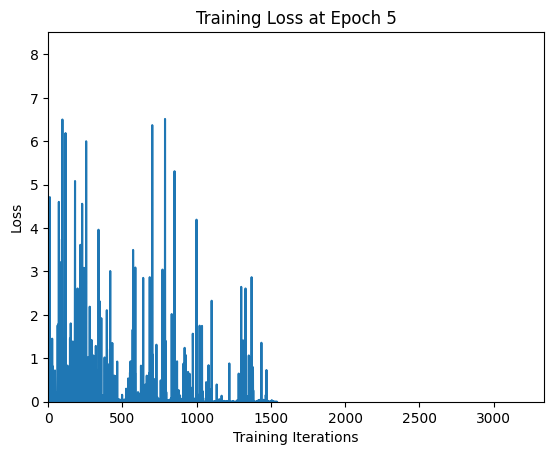

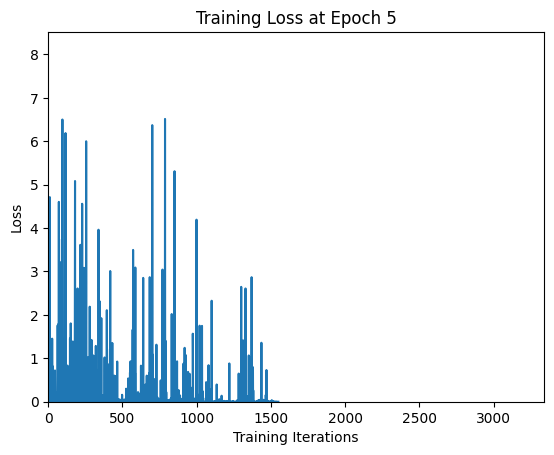

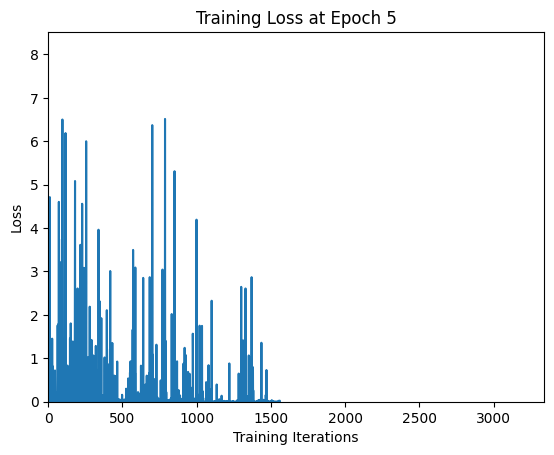

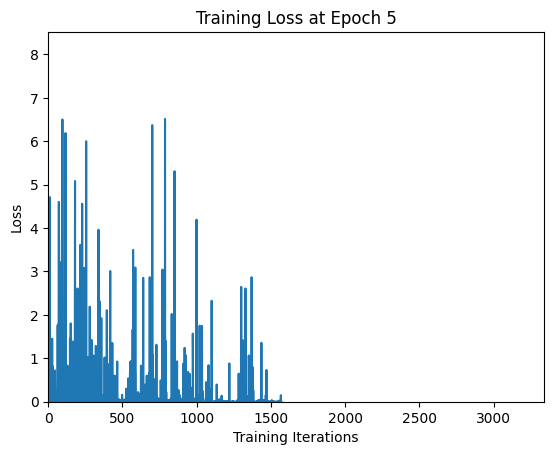

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...


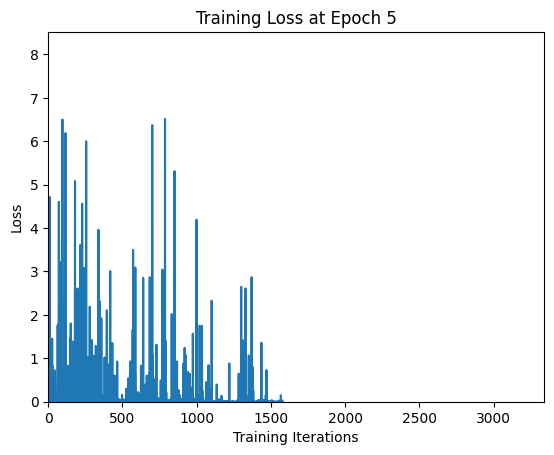

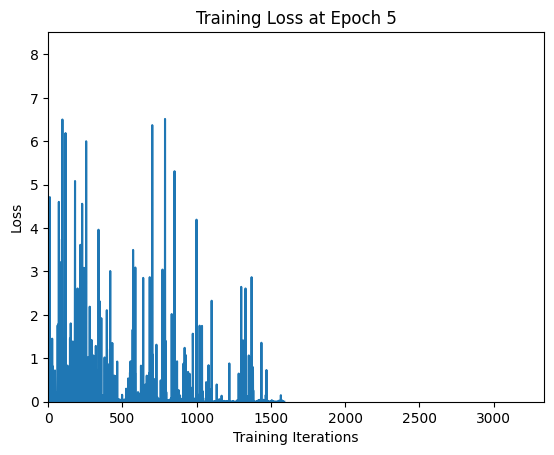

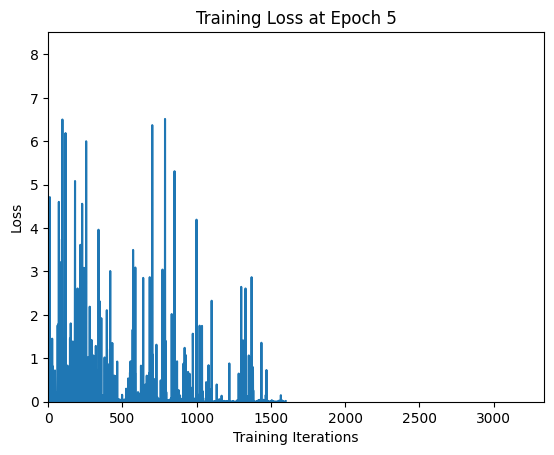

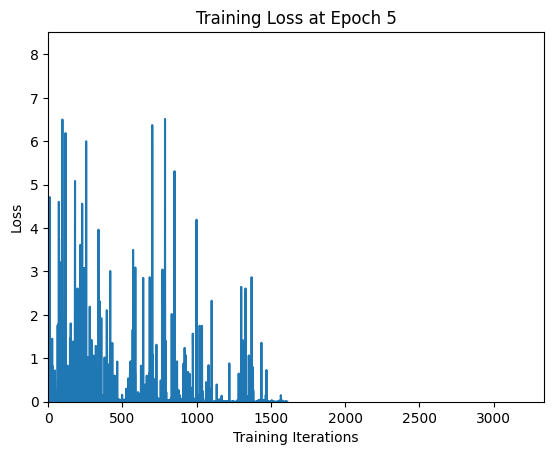

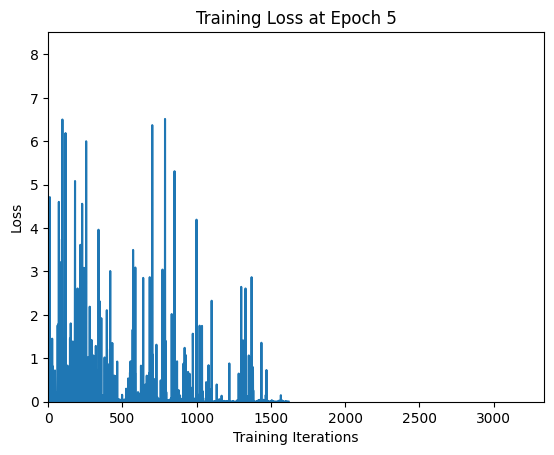

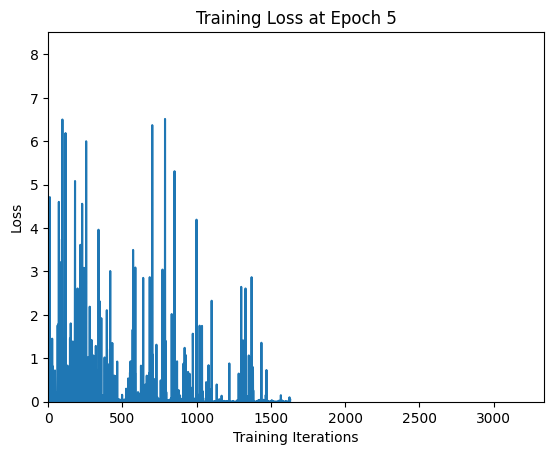

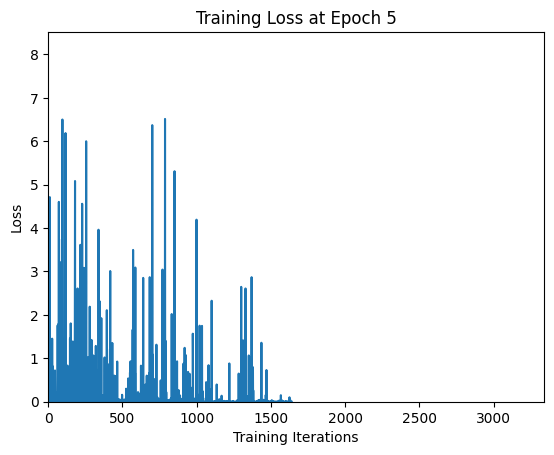

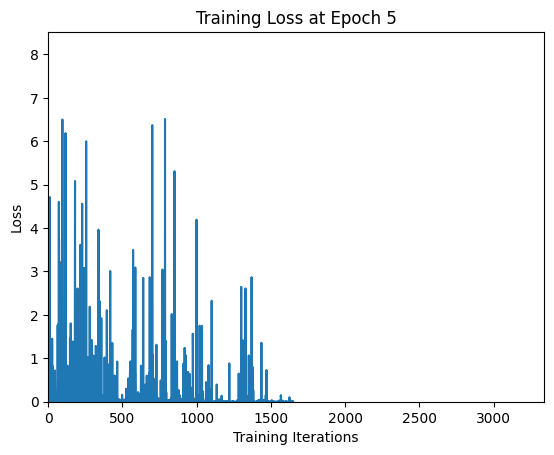

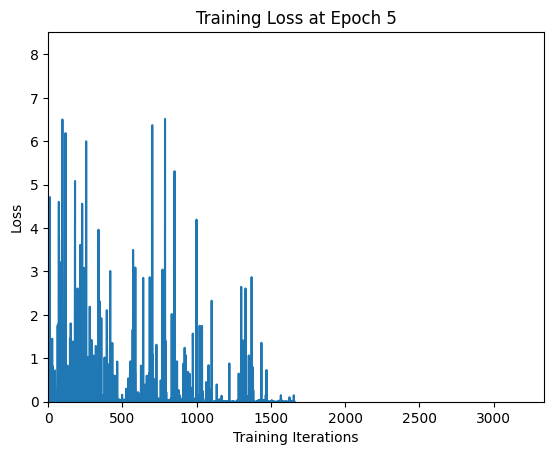

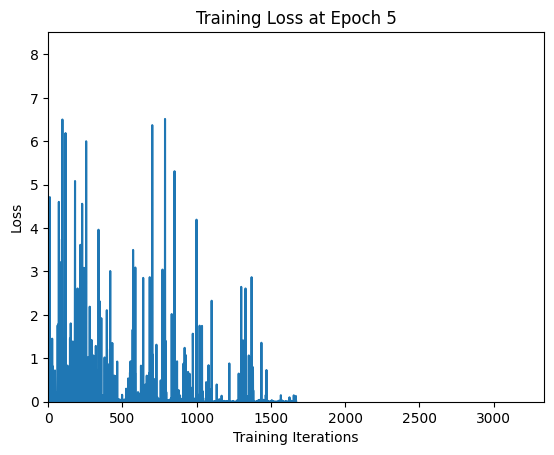

Average Loss after Epoch 5: 0.029454252443812962

Epoch 5, Train Loss: 0.029454252443812962
Epoch 5, Validation Loss: 0.34763462437702, Validation Accuracy: 0.93
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
Total wrong files: 8

Sentence 2: 8 (100.00%)
                precision    recall  f1-score   support

non_dysarthria       0.98      0.87      0.92        55
   

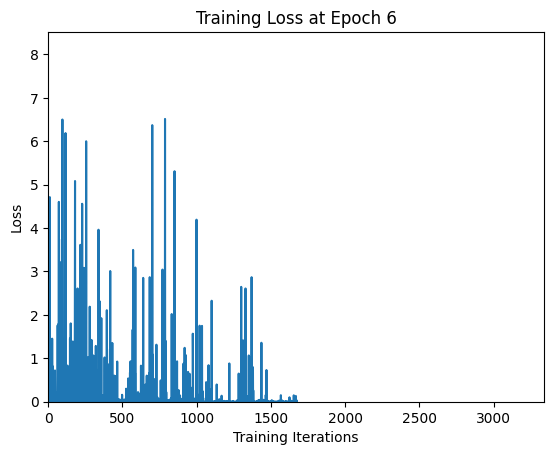

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...


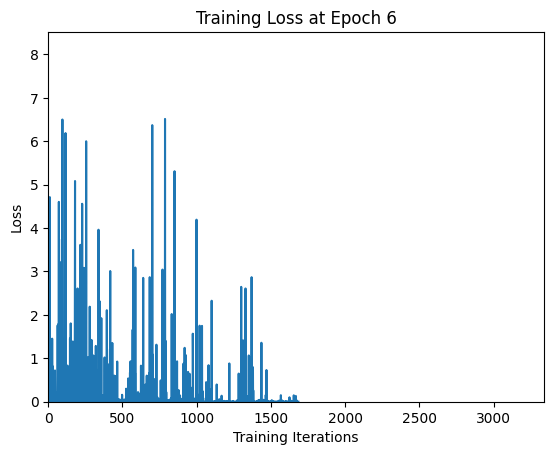

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...


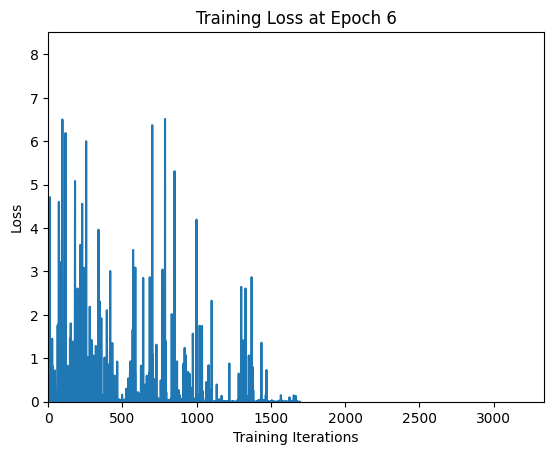

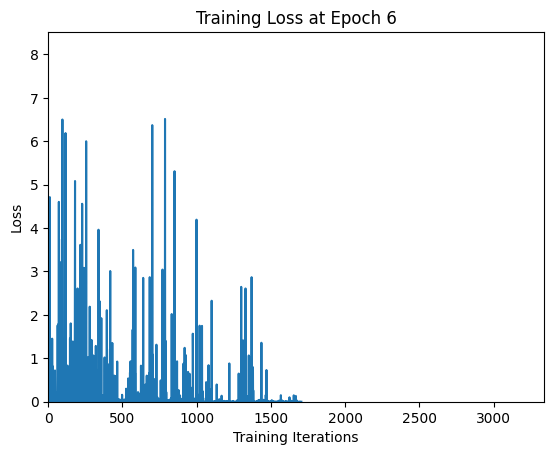

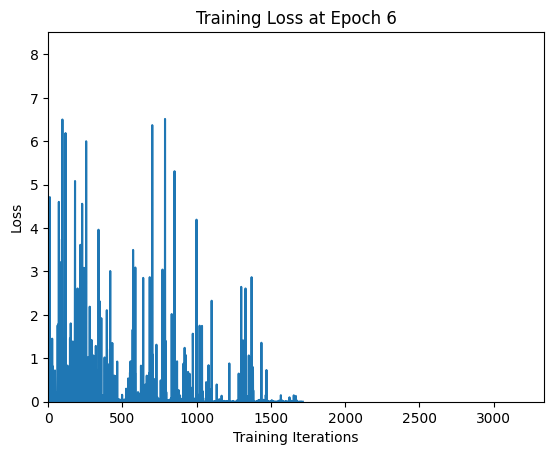

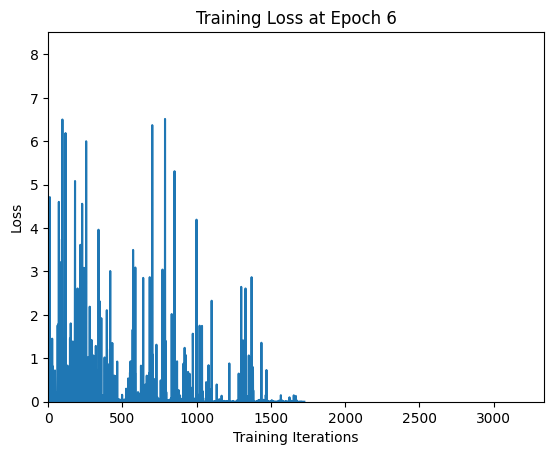

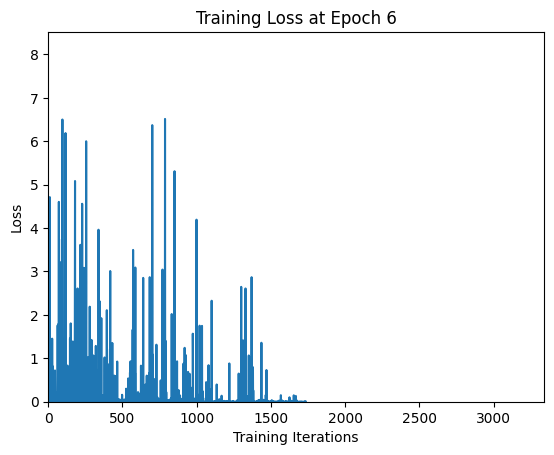

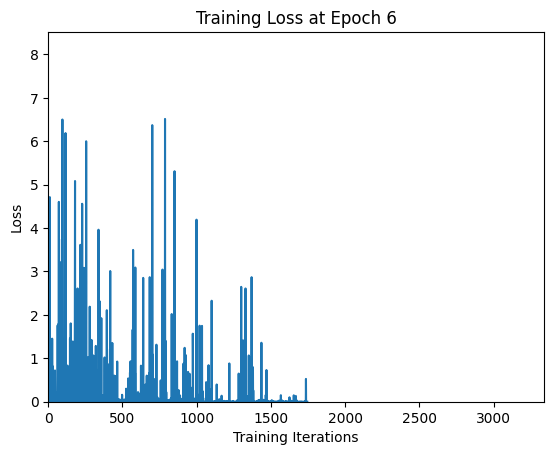

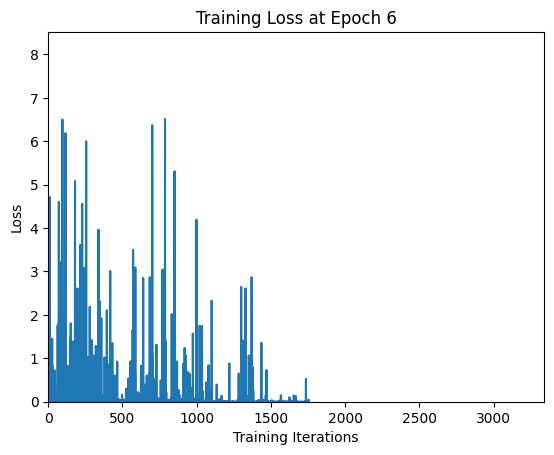

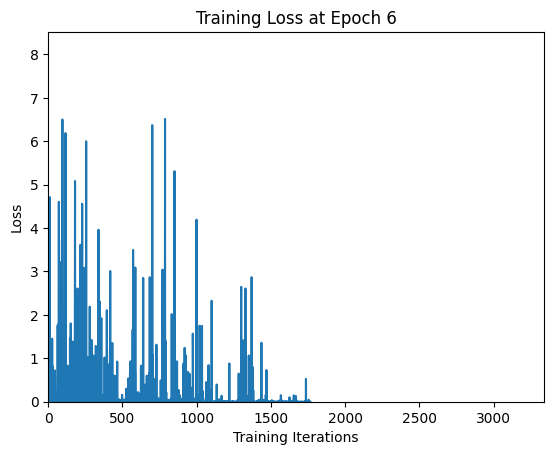

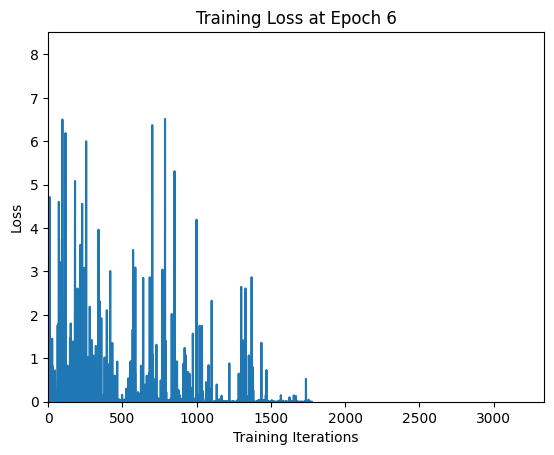

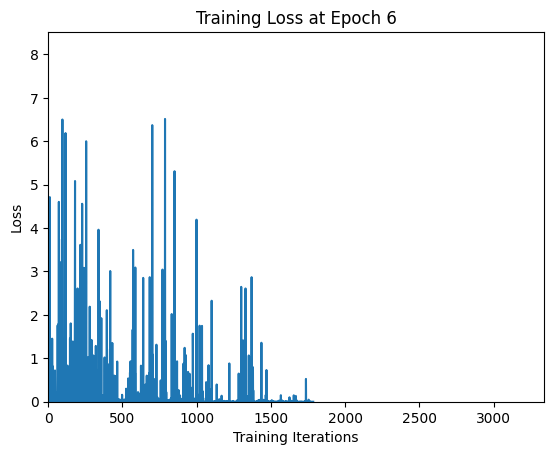

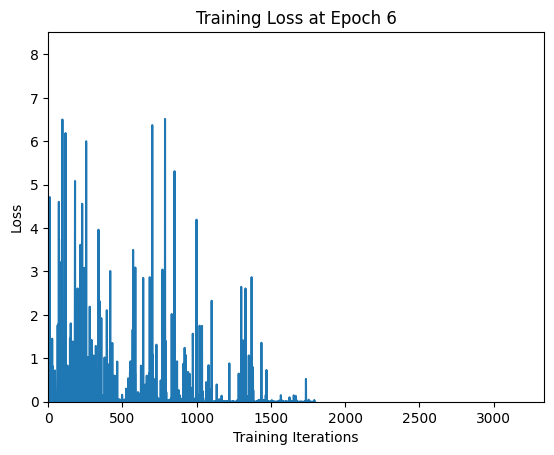

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT037_ANALYSIS/CT037_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_5.wav. Skipping...


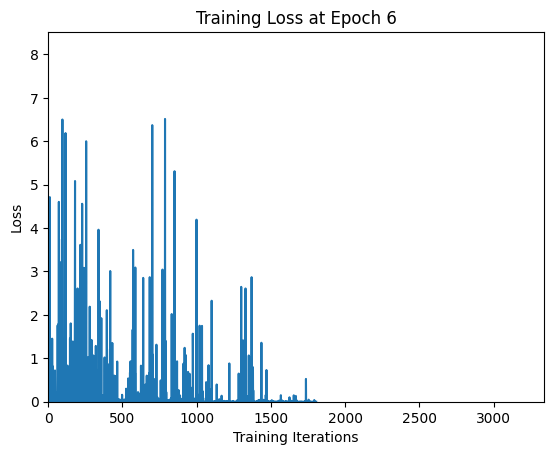

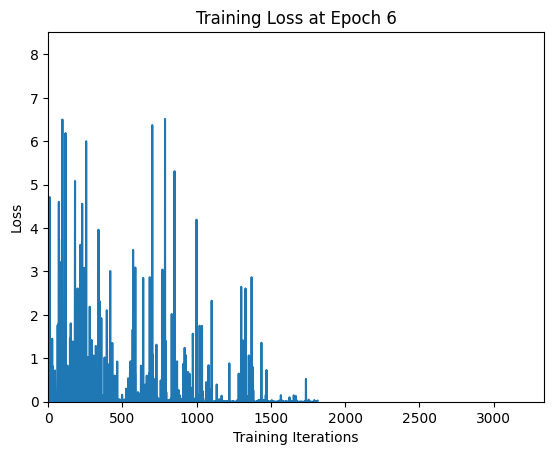

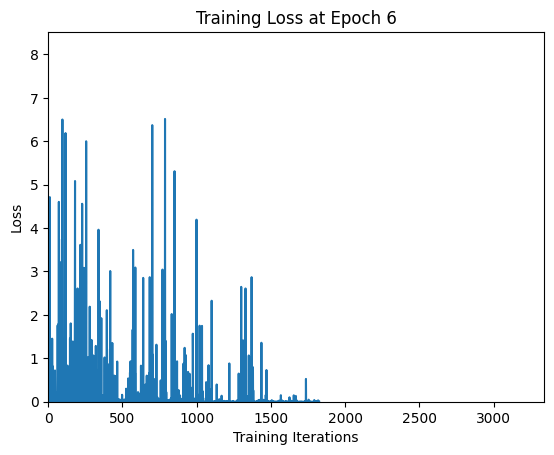

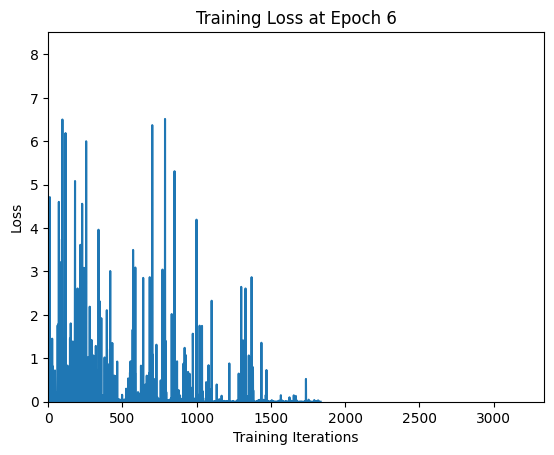

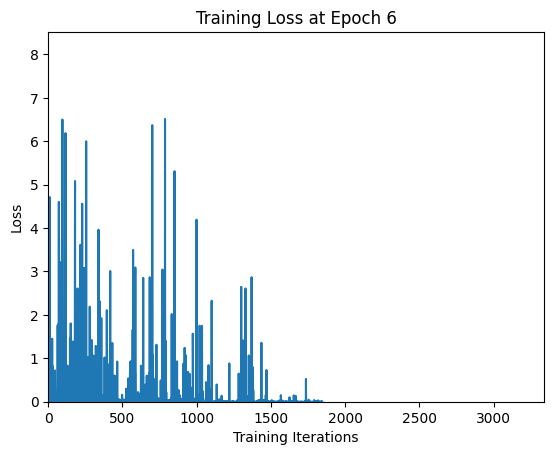

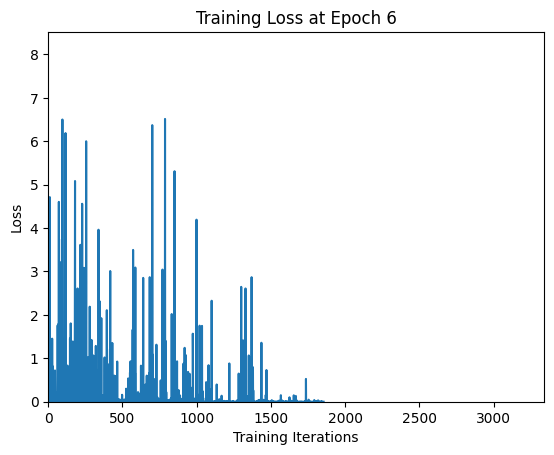

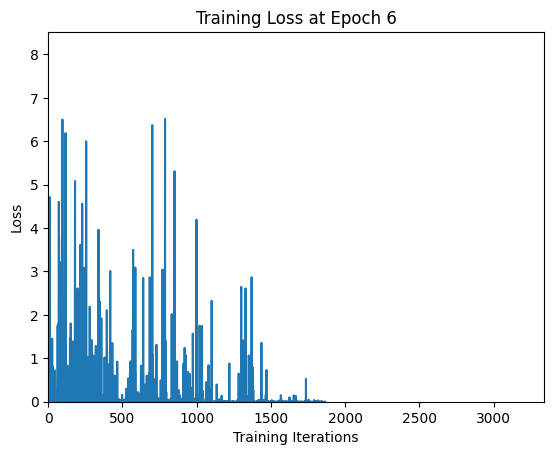

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_5.wav. Skipping...


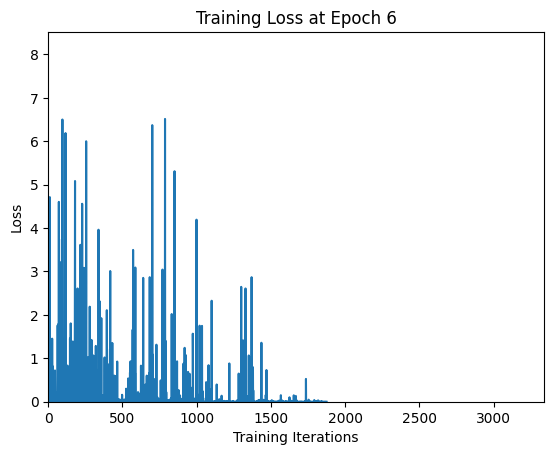

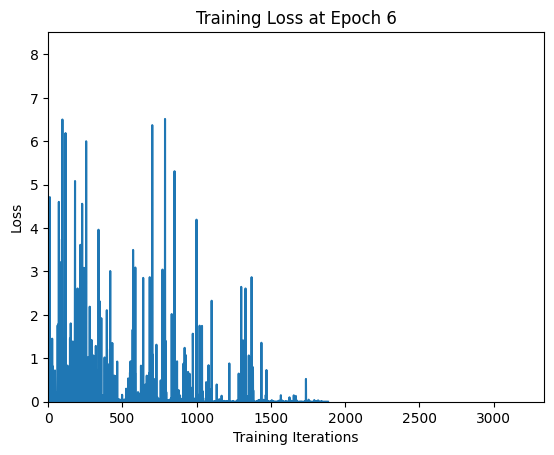

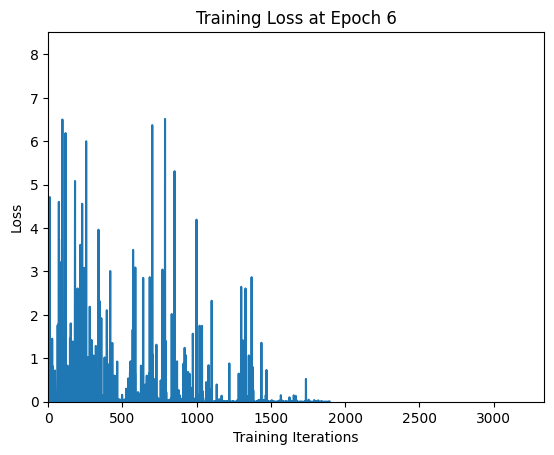

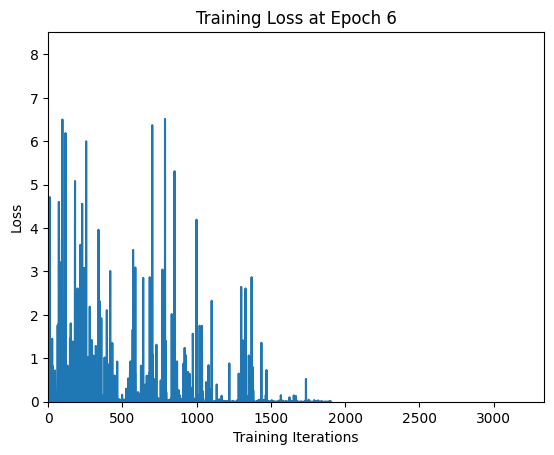

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...


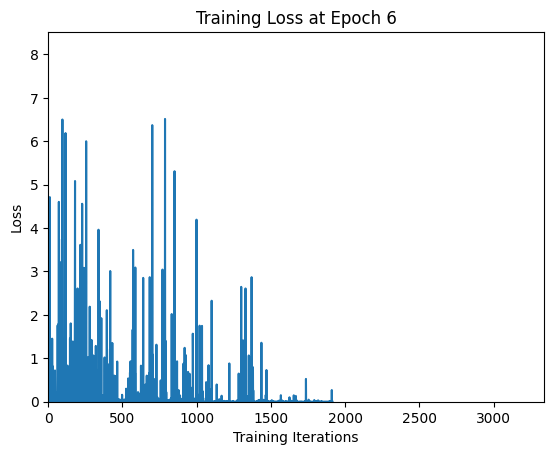

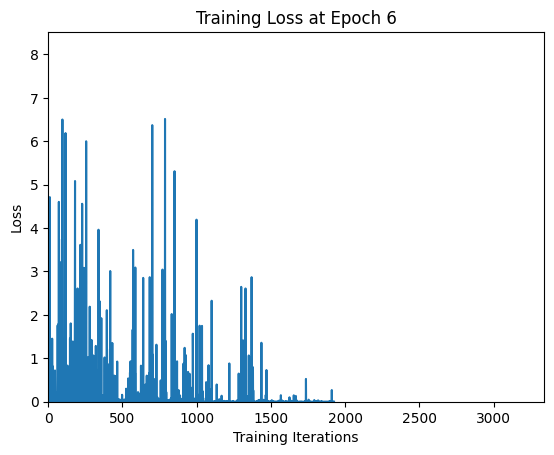

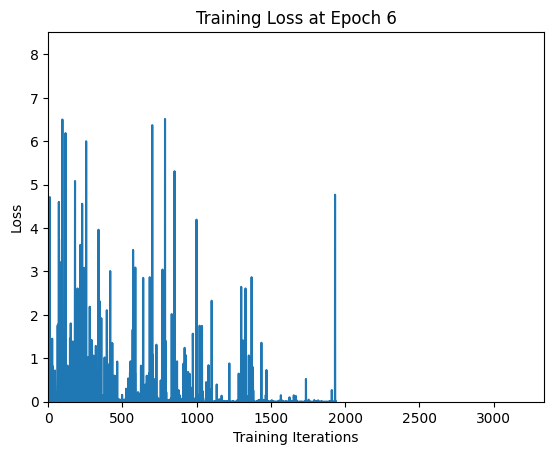

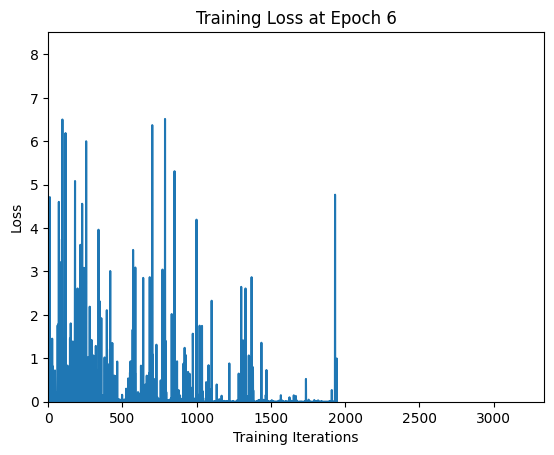

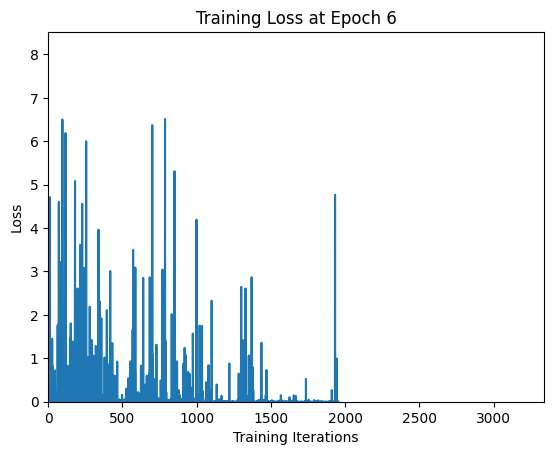

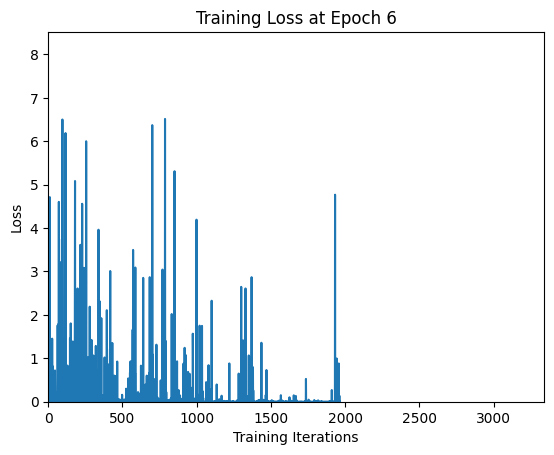

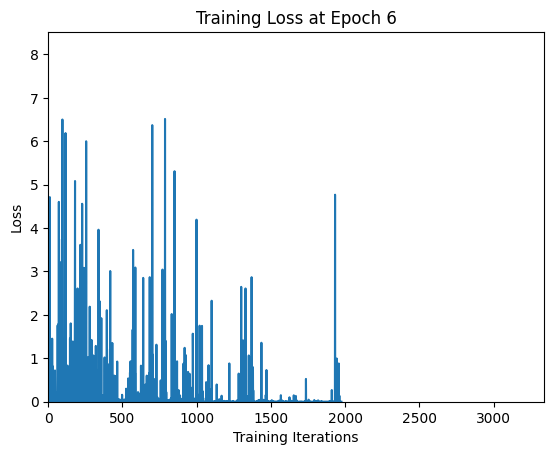

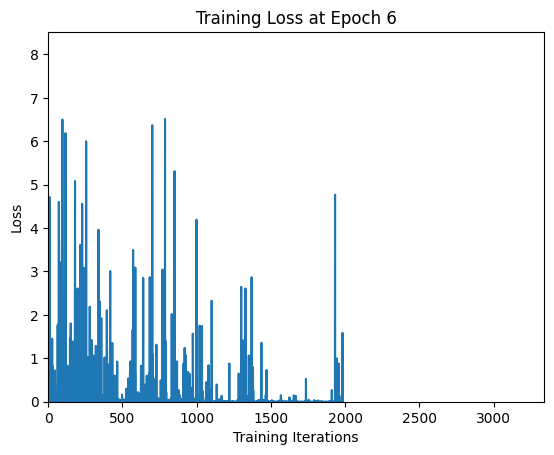

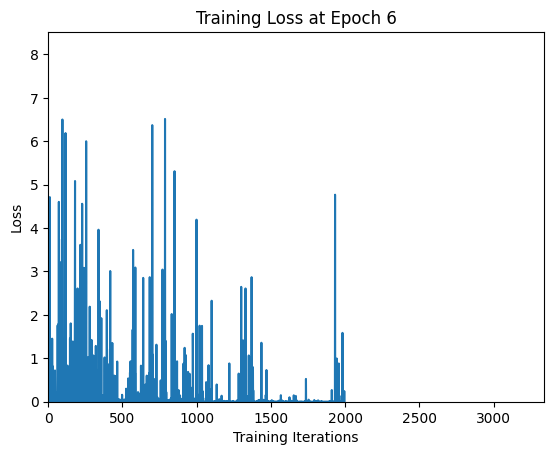

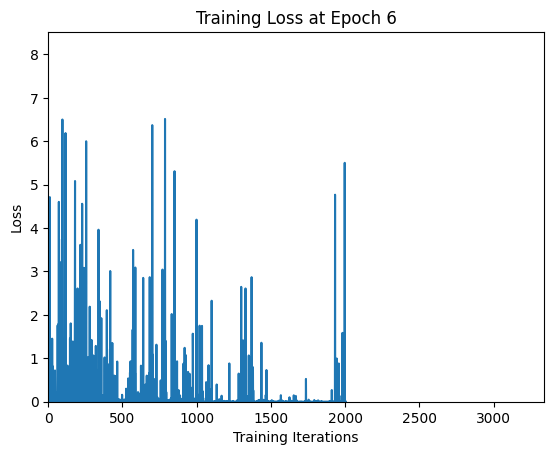

Average Loss after Epoch 6: 0.047812397802587024

Epoch 6, Train Loss: 0.047812397802587024
Epoch 6, Validation Loss: 0.6038488051265413, Validation Accuracy: 0.87
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.

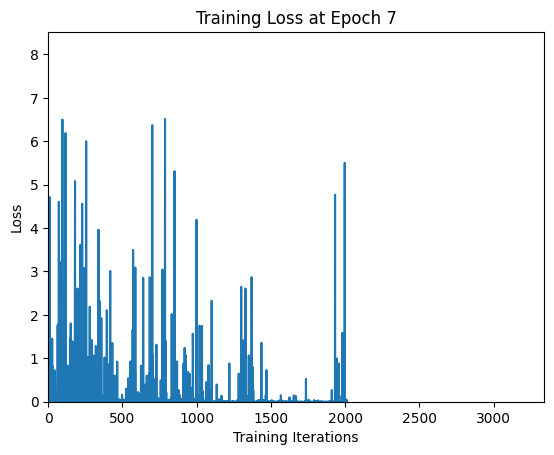

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...


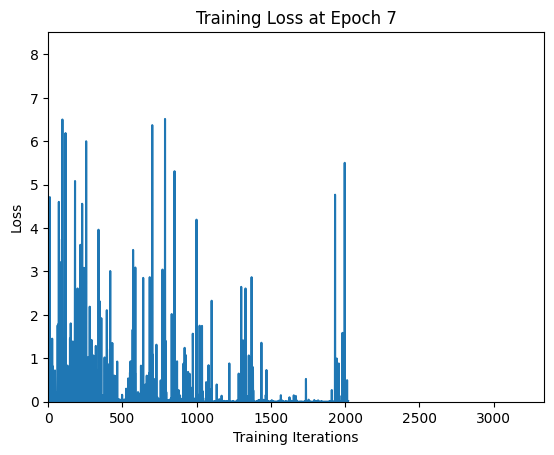

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...


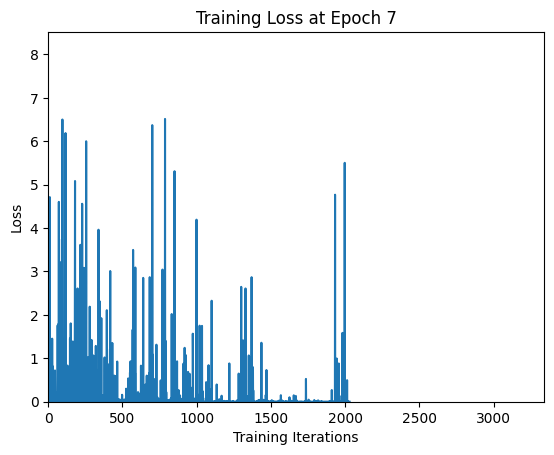

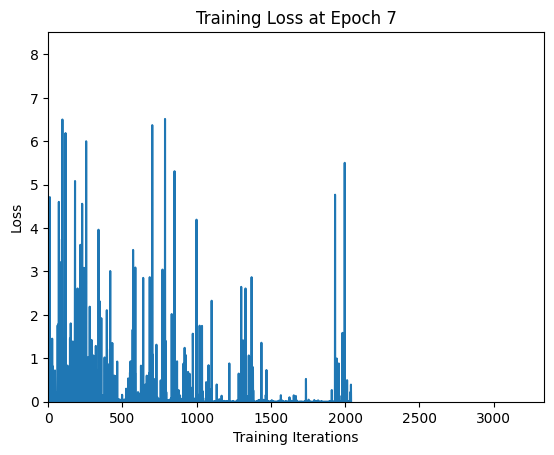

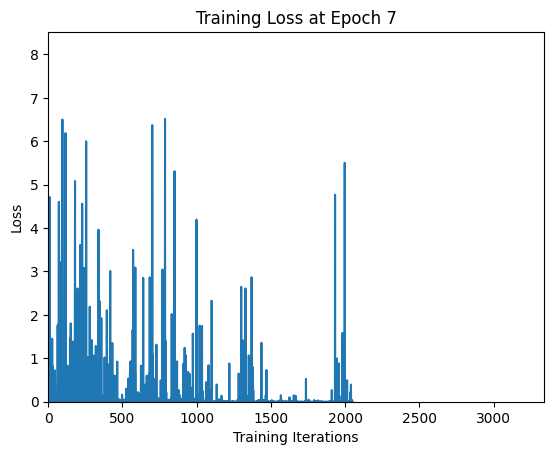

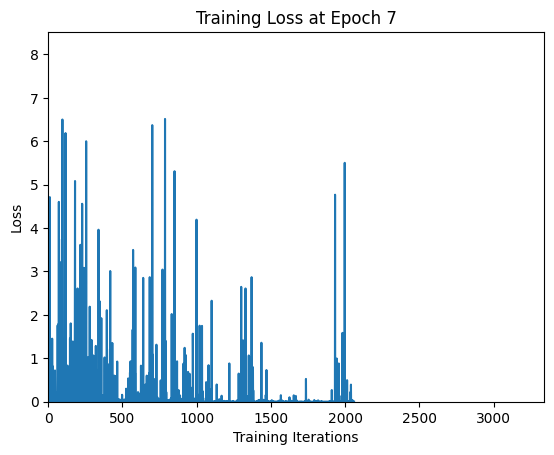

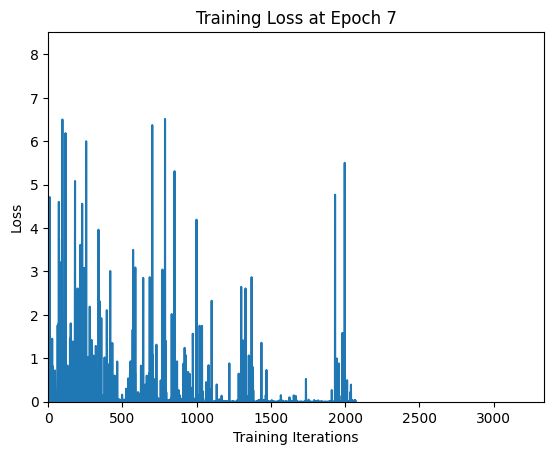

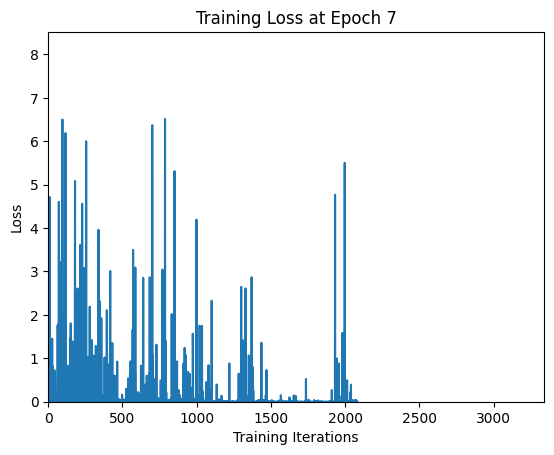

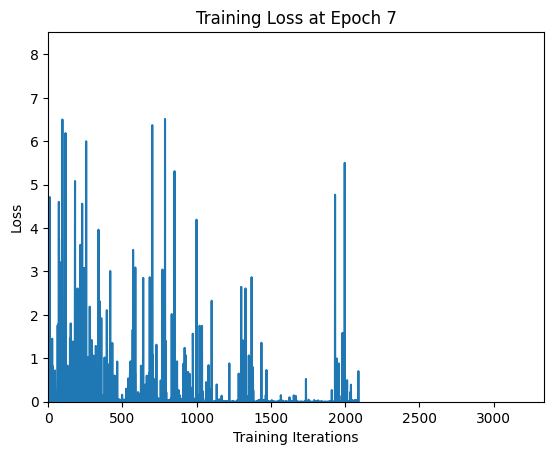

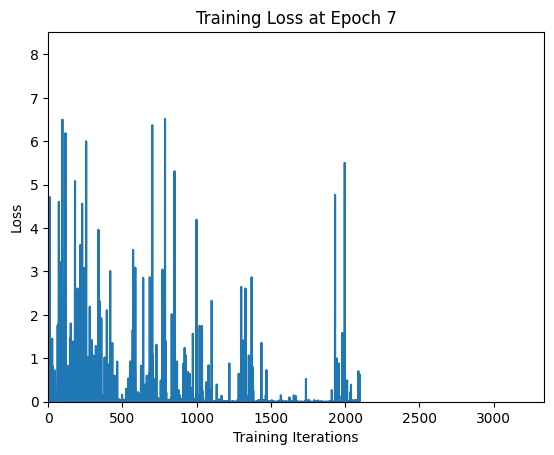

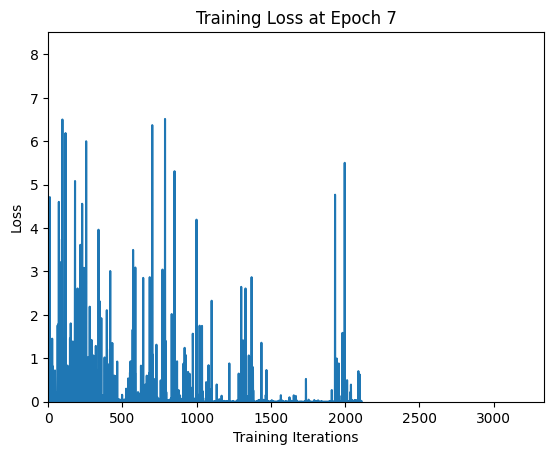

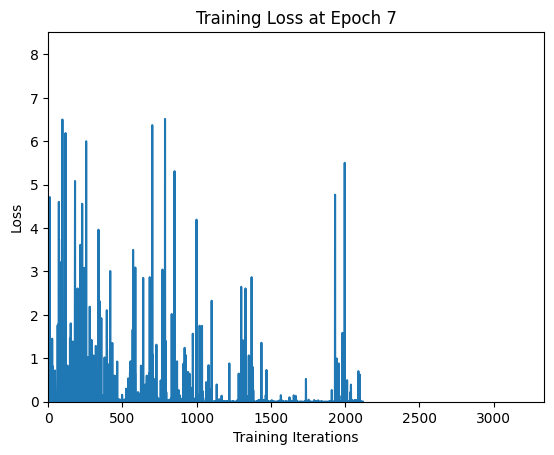

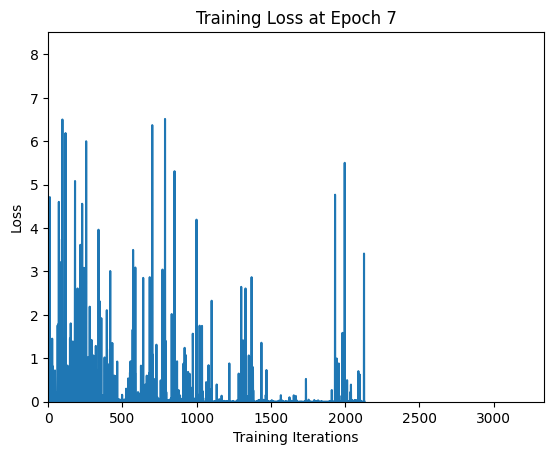

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT037_ANALYSIS/CT037_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_5.wav. Skipping...


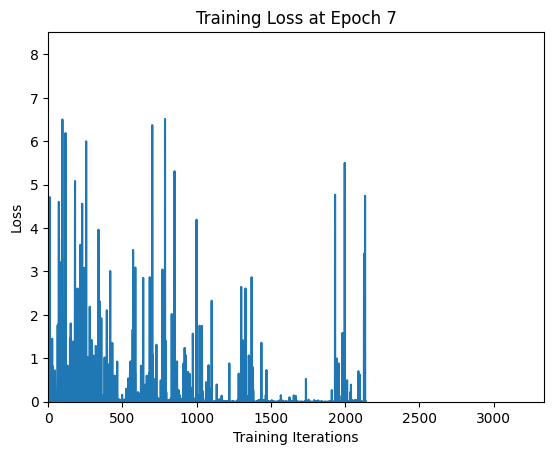

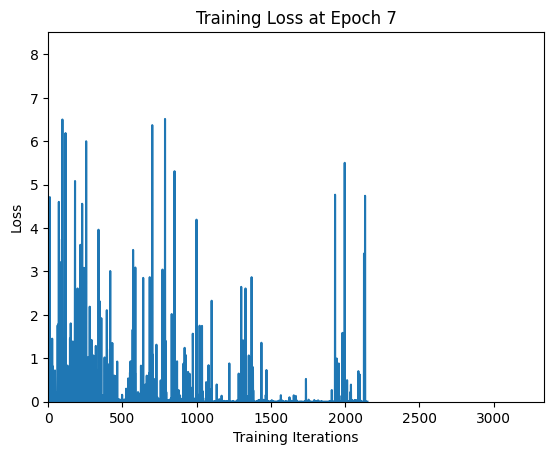

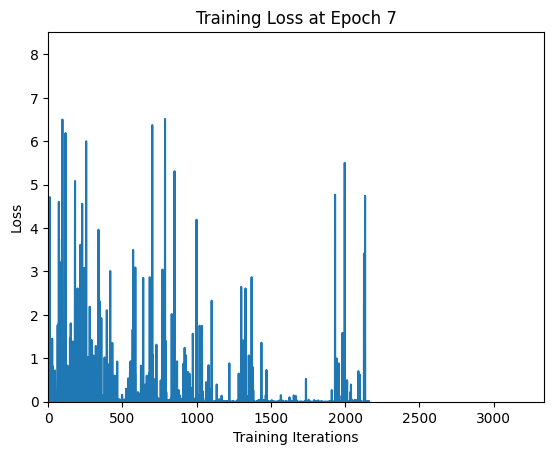

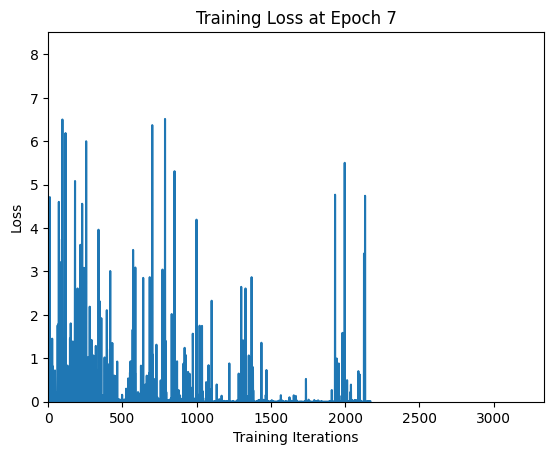

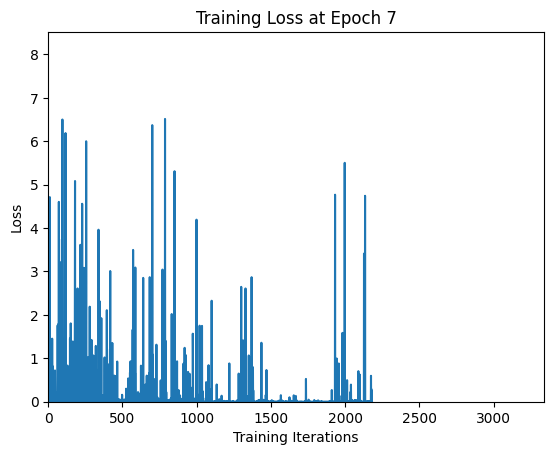

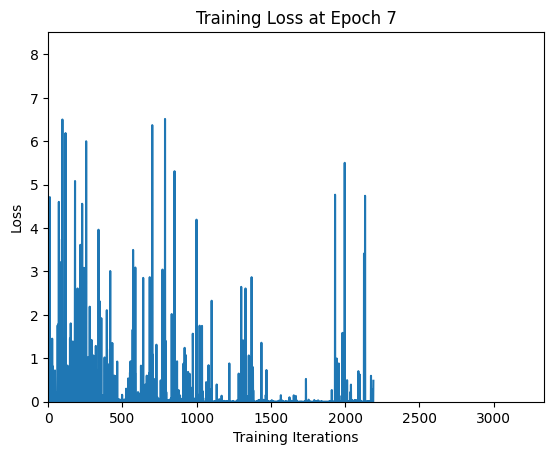

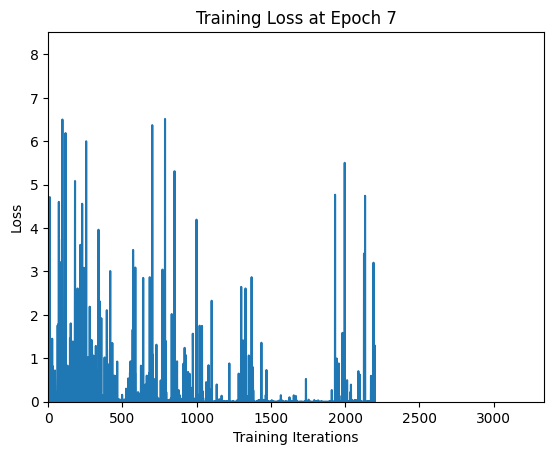

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_5.wav. Skipping...


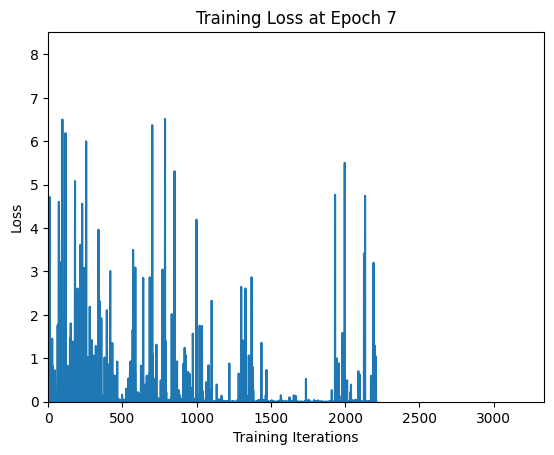

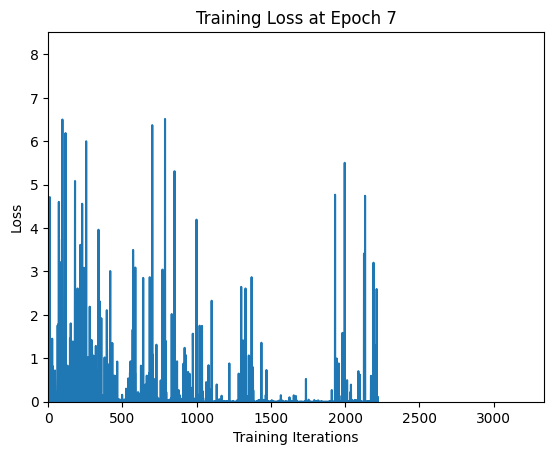

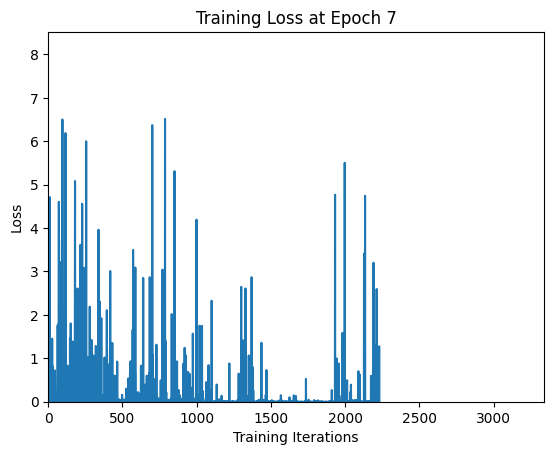

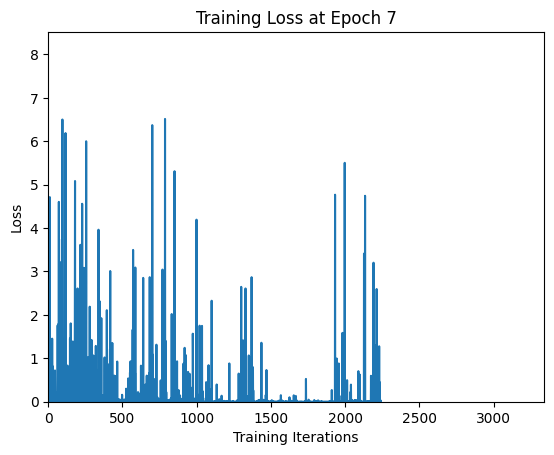

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...


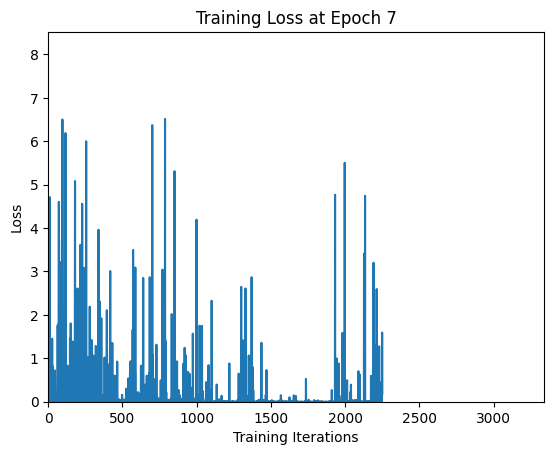

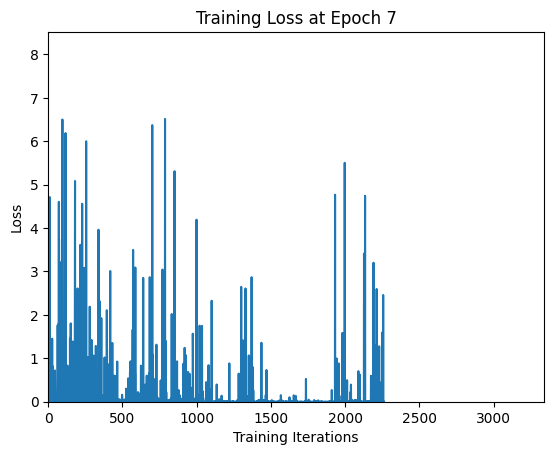

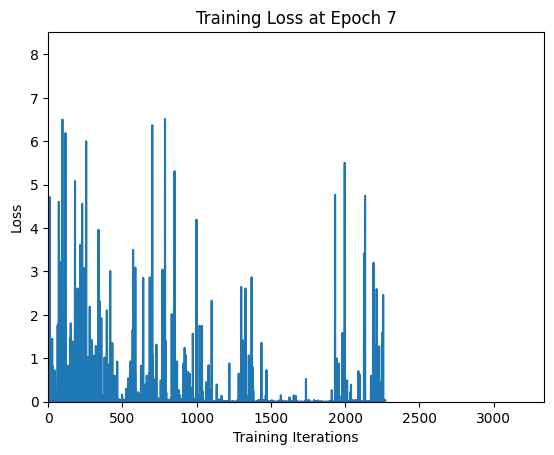

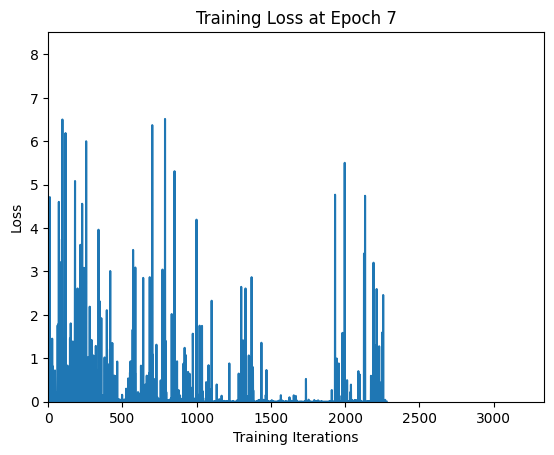

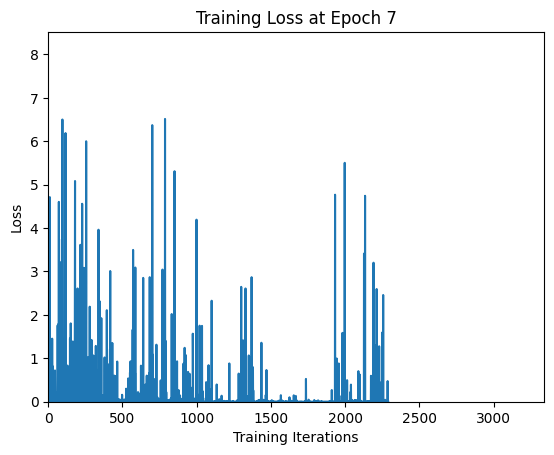

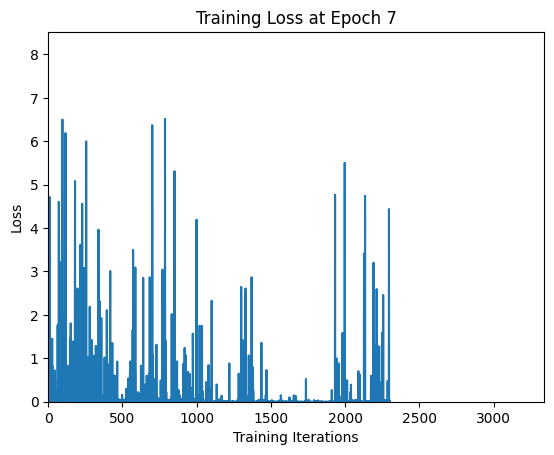

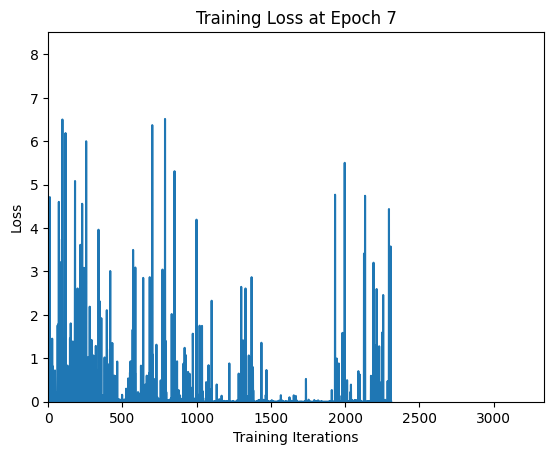

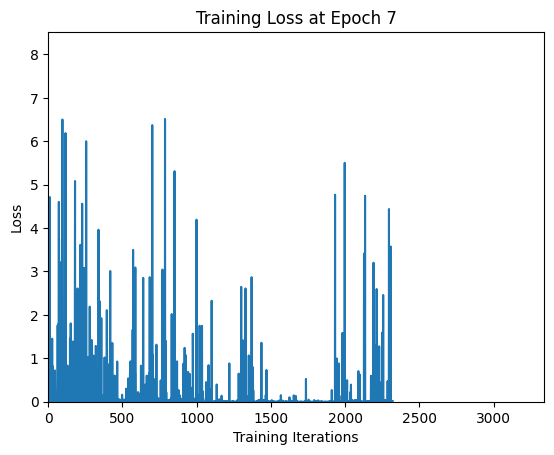

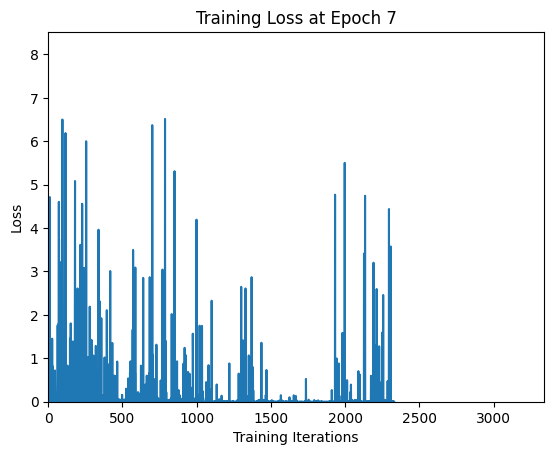

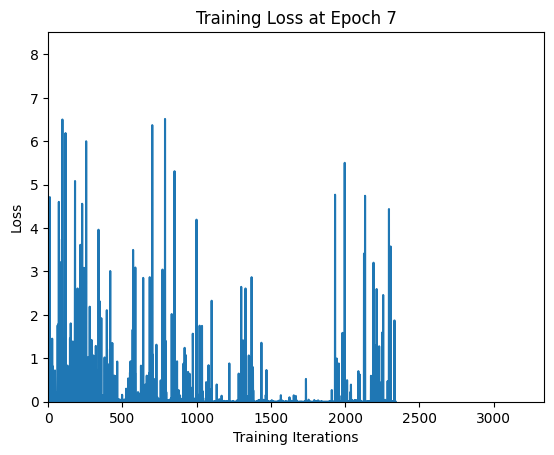

Average Loss after Epoch 7: 0.11987404544636793

Epoch 7, Train Loss: 0.11987404544636793
Epoch 7, Validation Loss: 0.664152394598206, Validation Accuracy: 0.83
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav

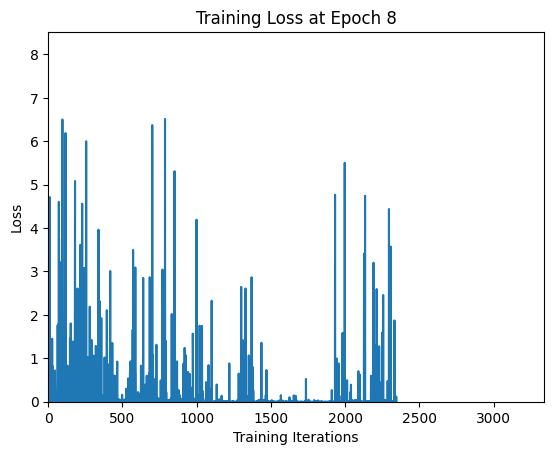

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...


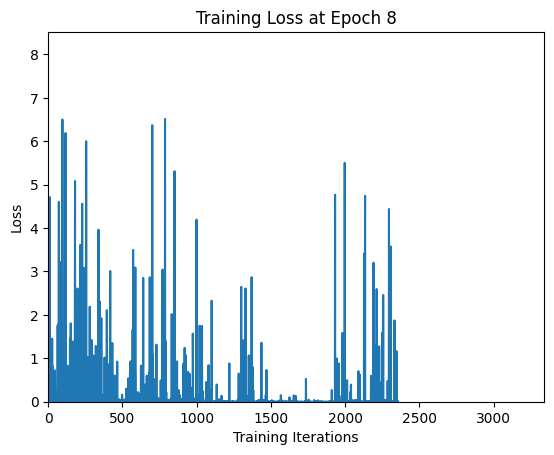

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...


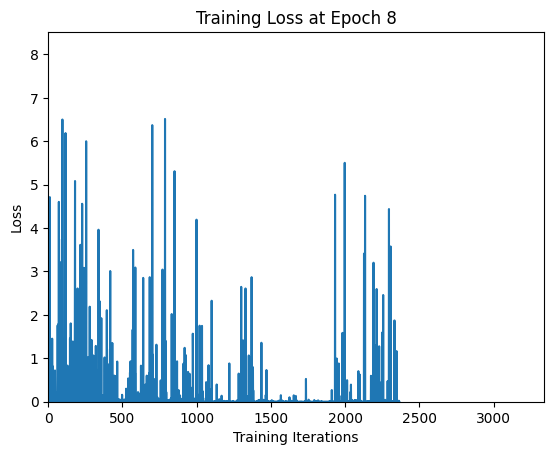

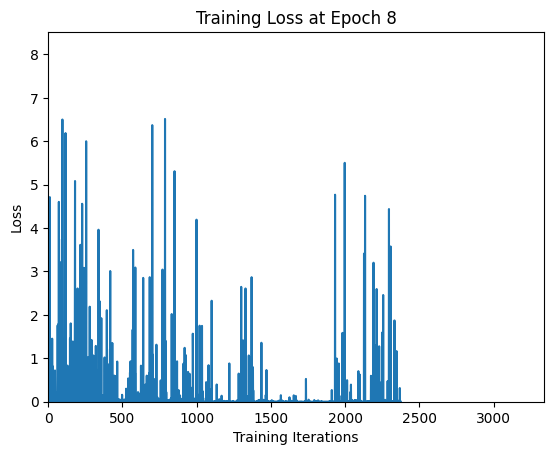

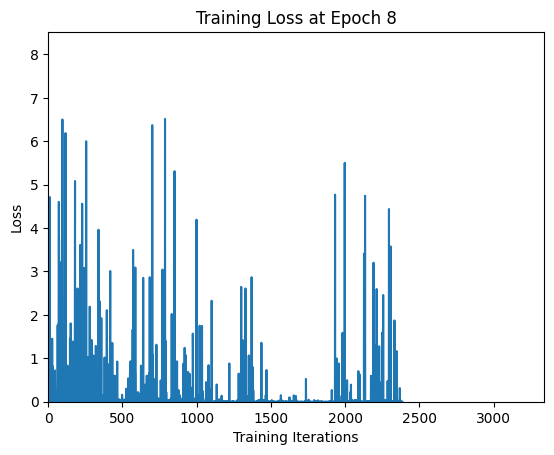

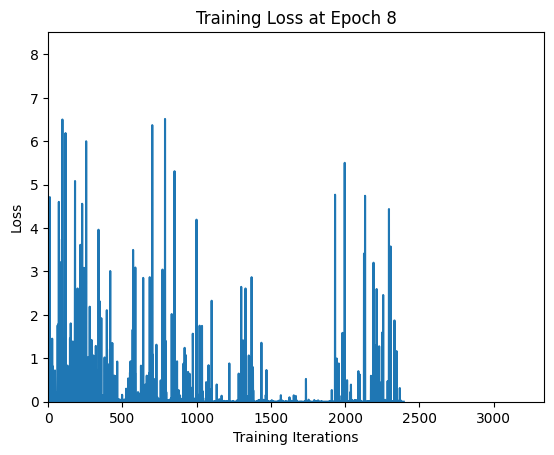

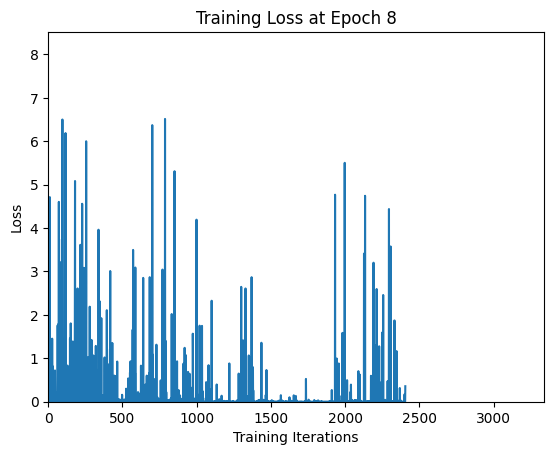

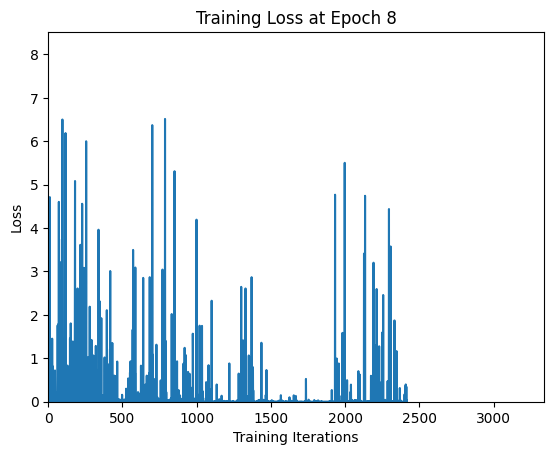

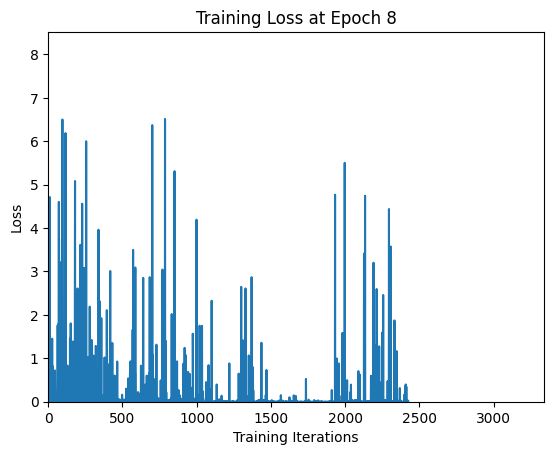

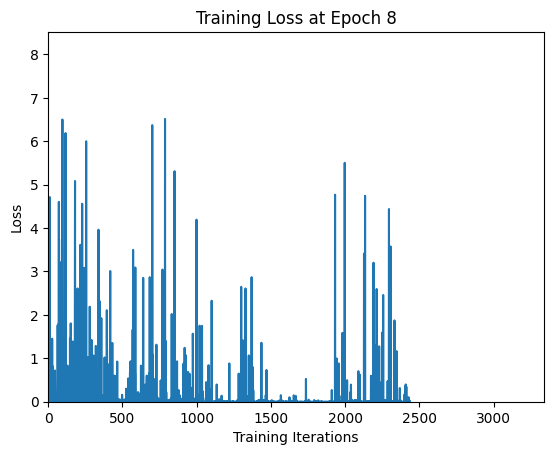

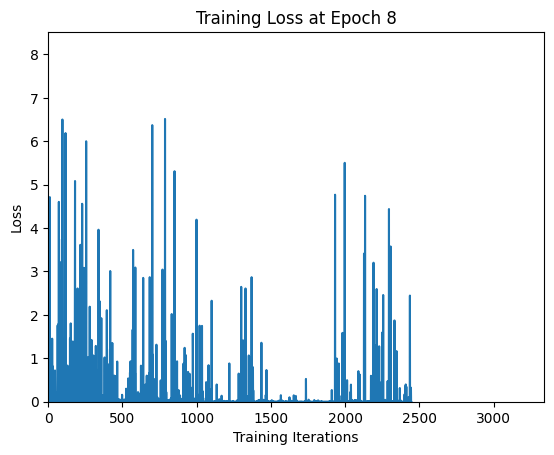

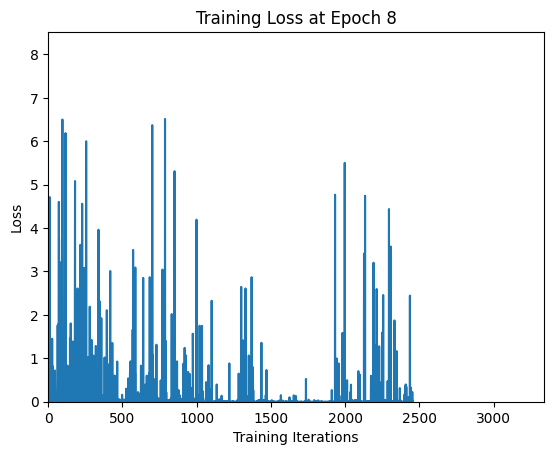

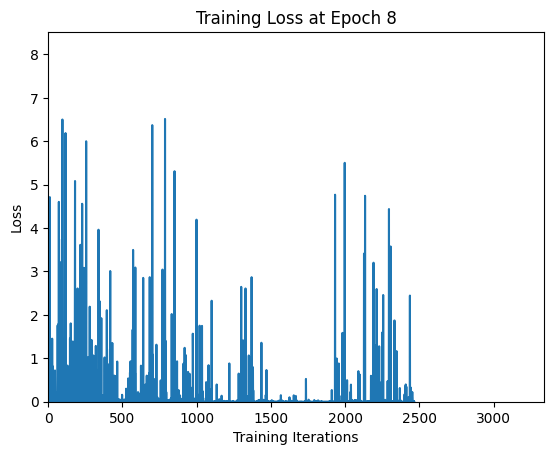

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT037_ANALYSIS/CT037_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_5.wav. Skipping...


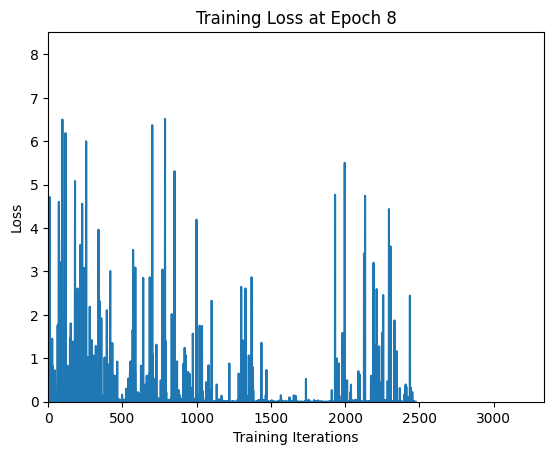

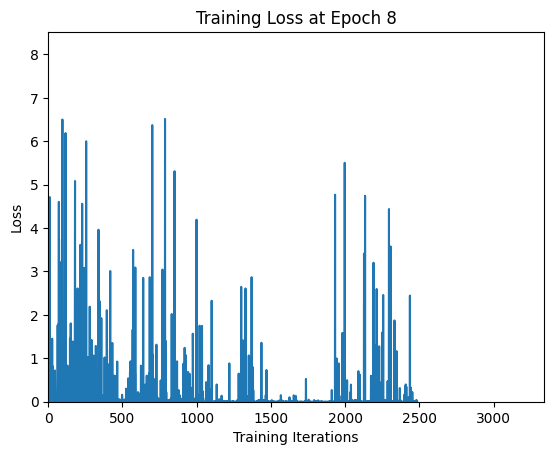

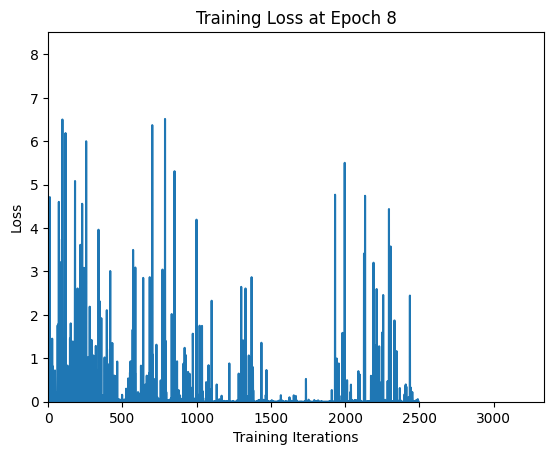

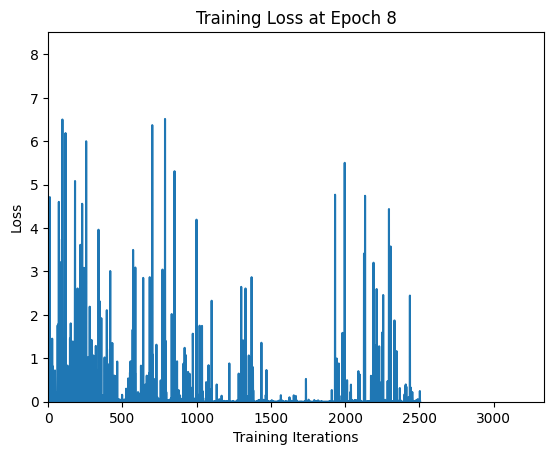

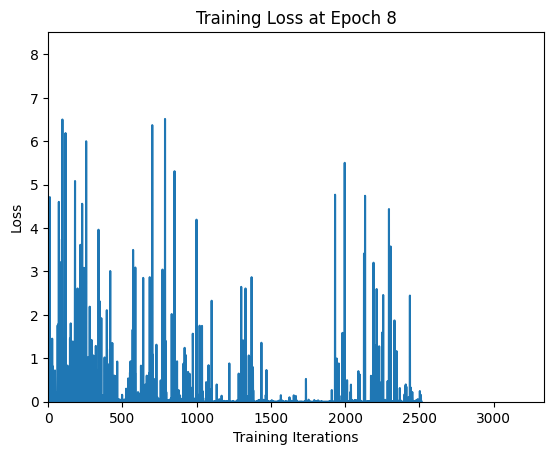

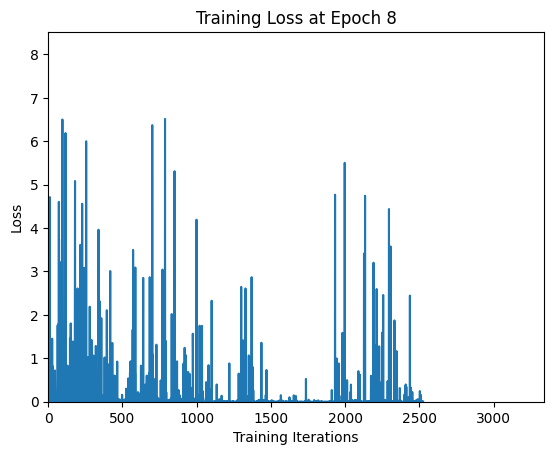

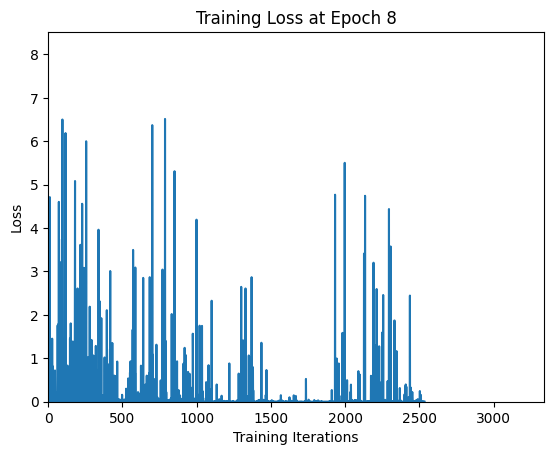

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_5.wav. Skipping...


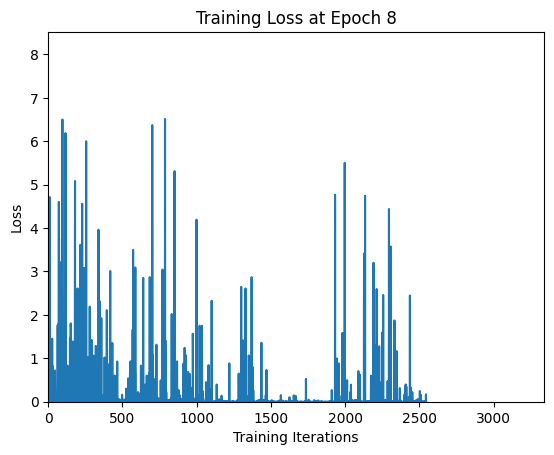

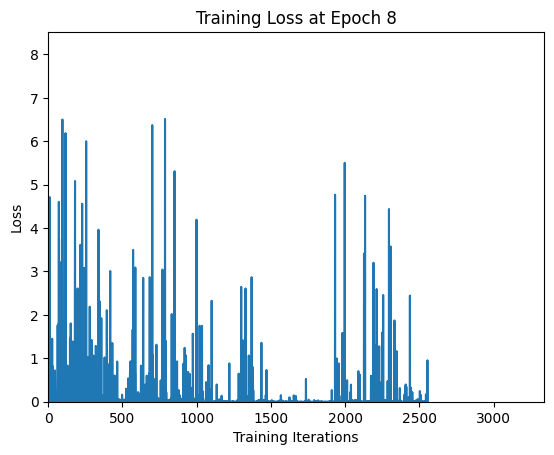

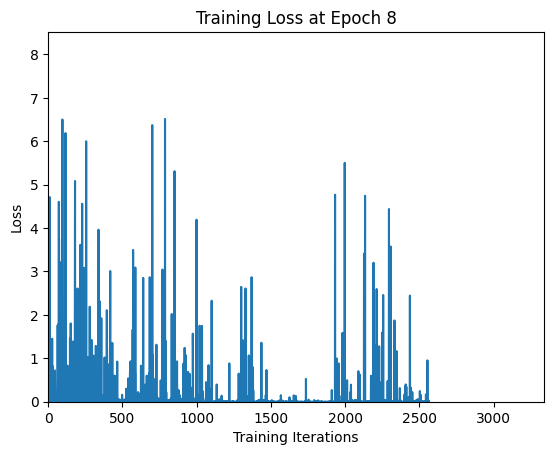

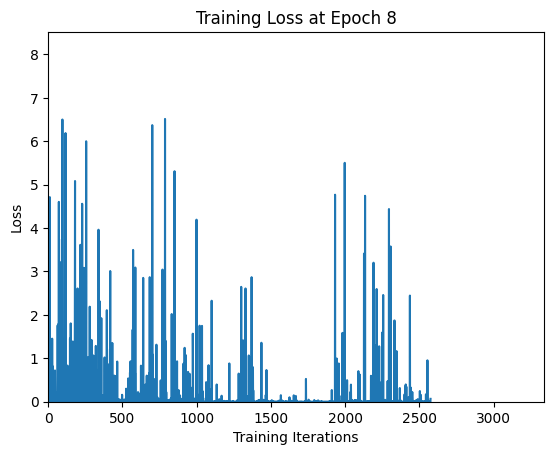

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...


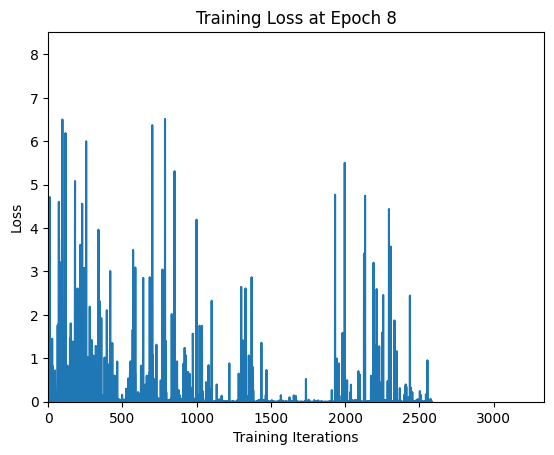

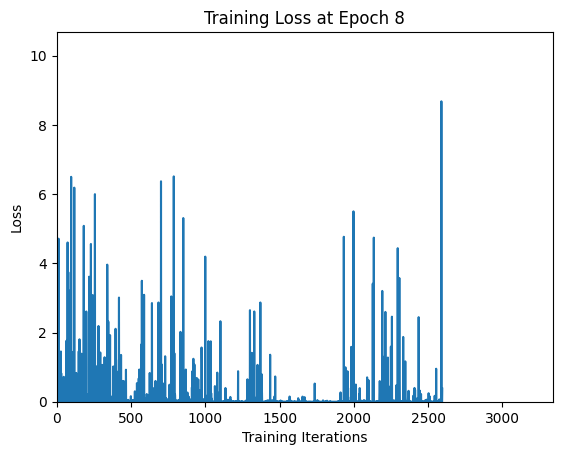

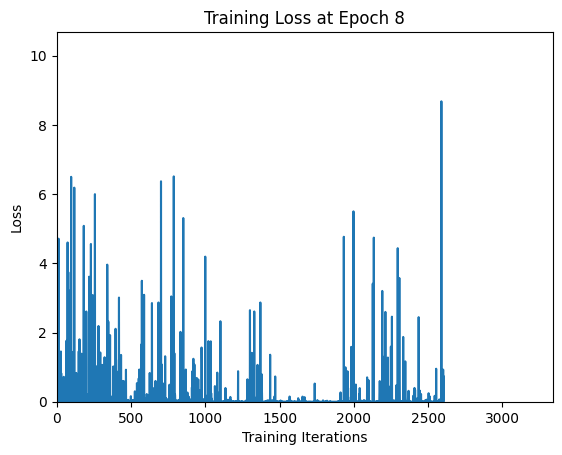

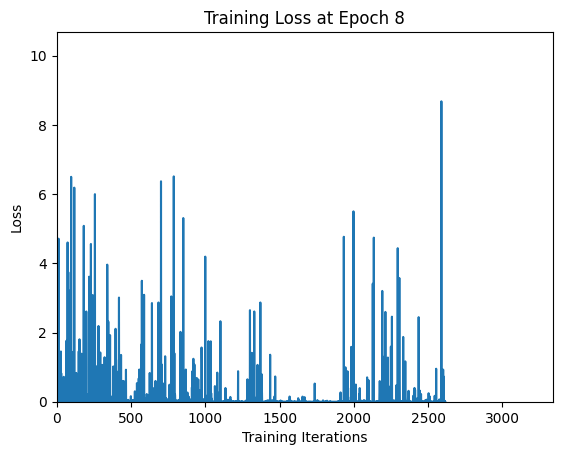

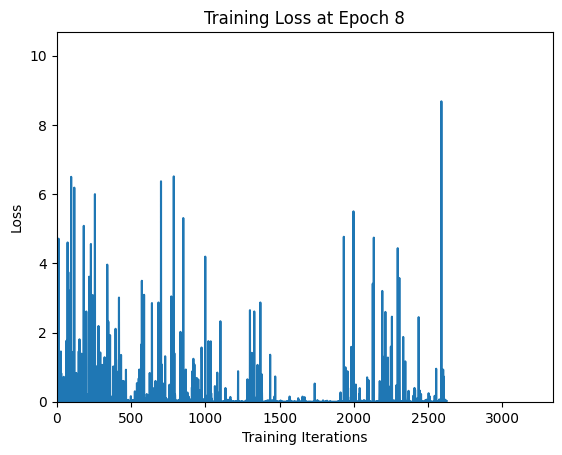

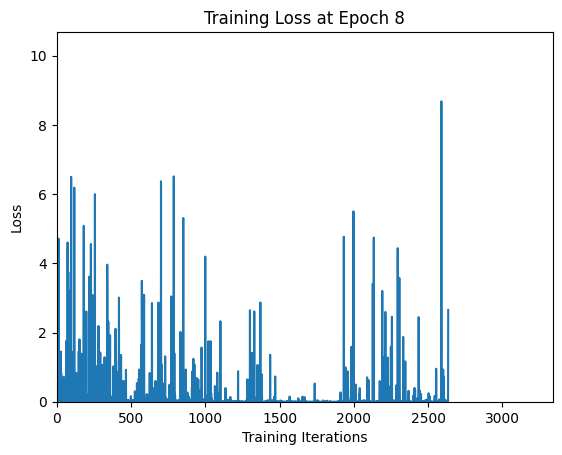

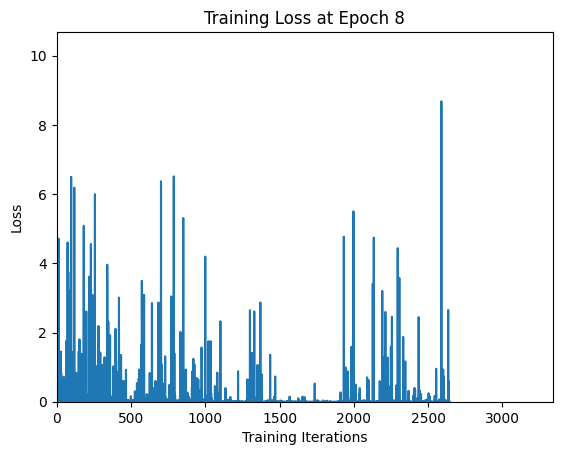

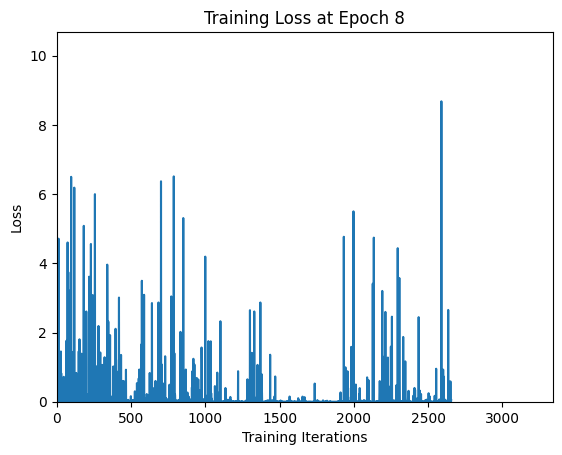

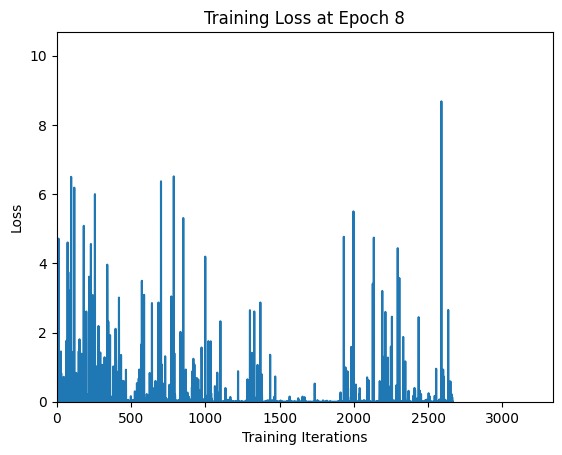

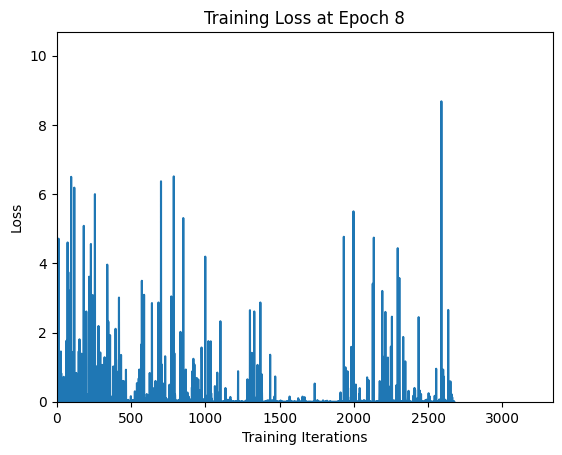

Average Loss after Epoch 8: 0.07250692910929048

Epoch 8, Train Loss: 0.07250692910929048
Epoch 8, Validation Loss: 0.4467726168158609, Validation Accuracy: 0.88
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wa

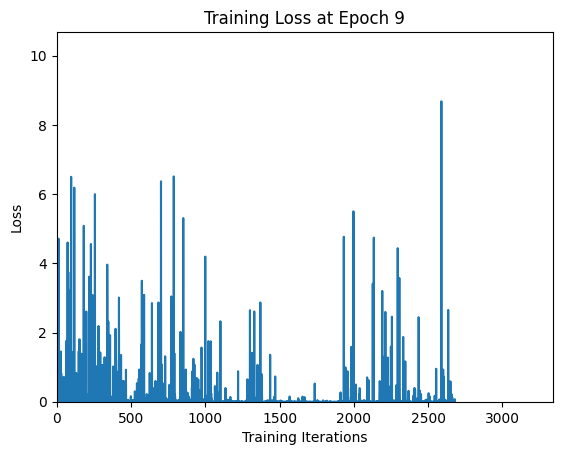

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...


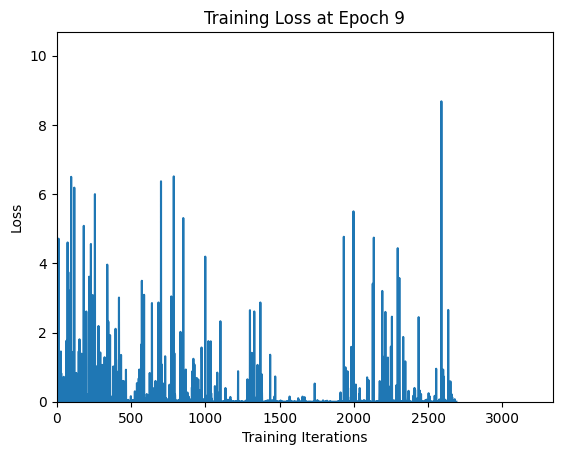

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...


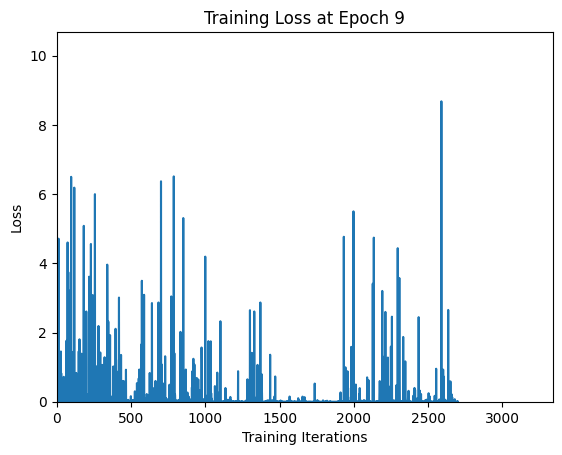

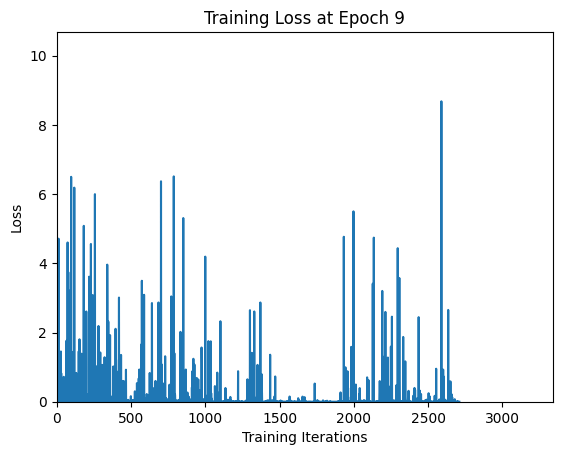

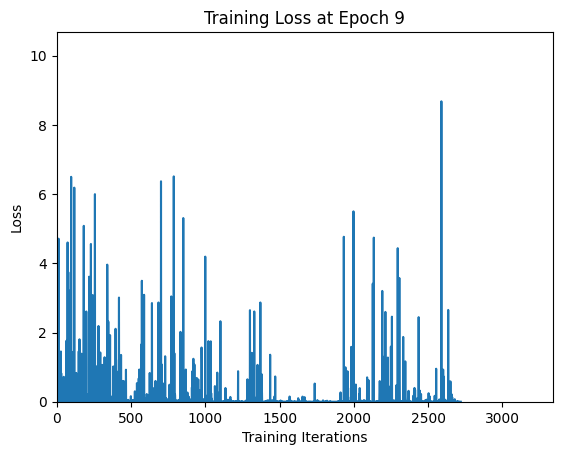

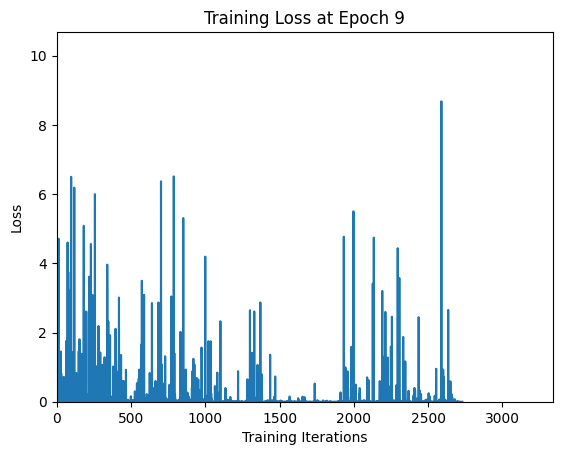

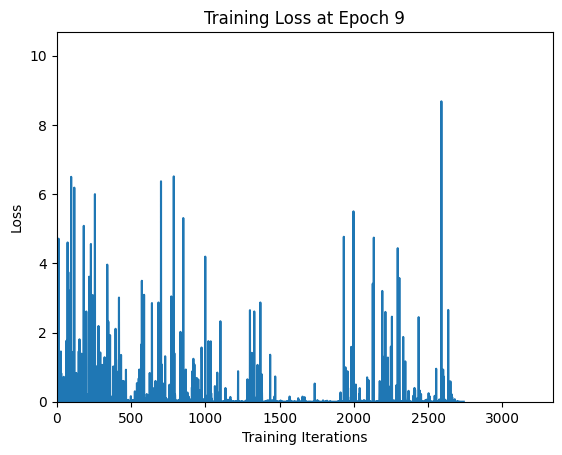

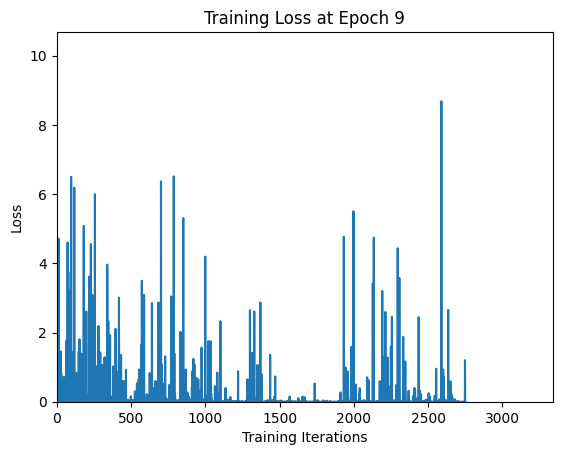

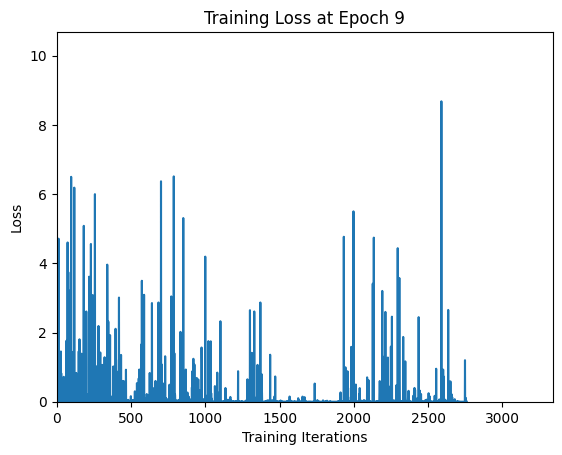

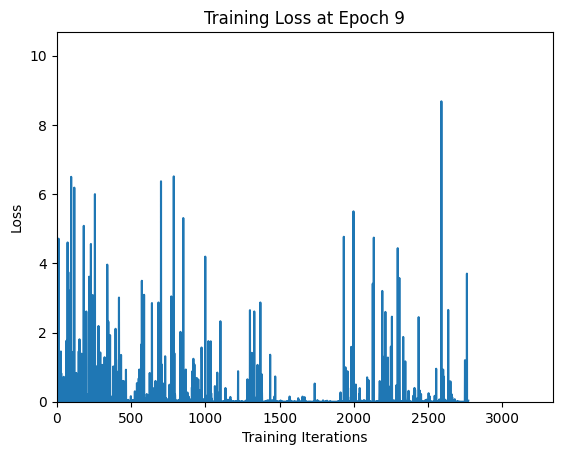

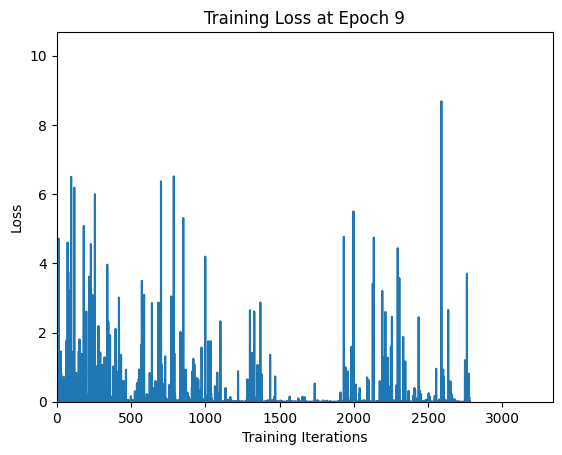

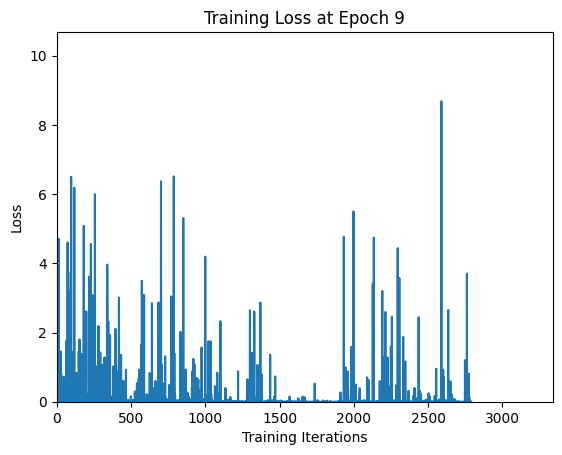

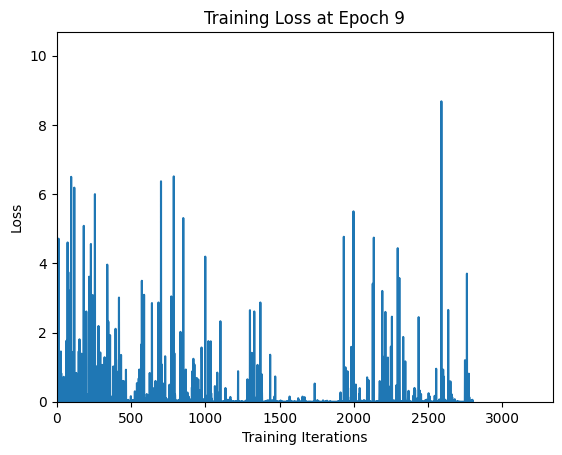

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT037_ANALYSIS/CT037_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_5.wav. Skipping...


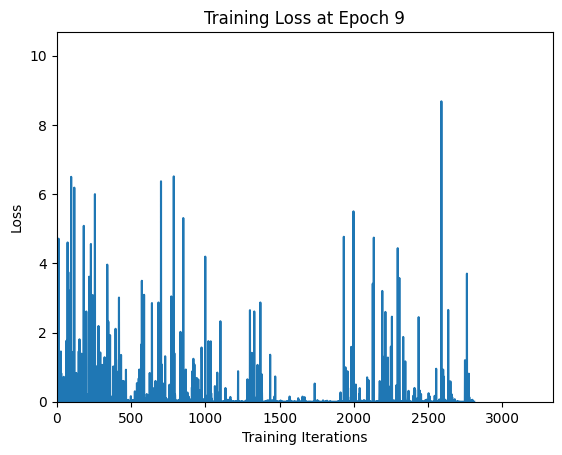

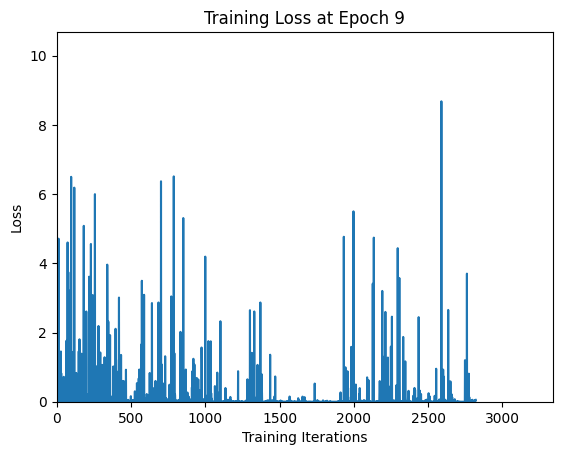

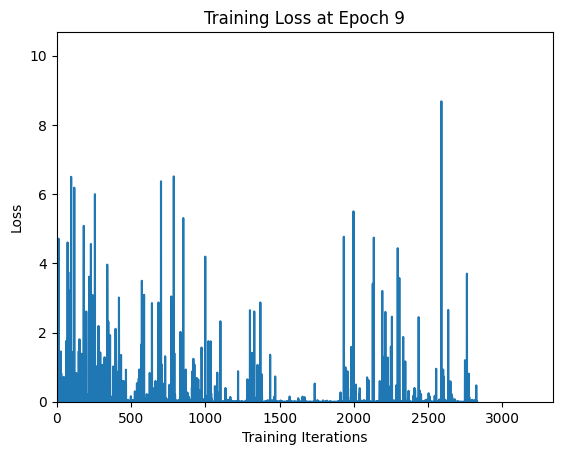

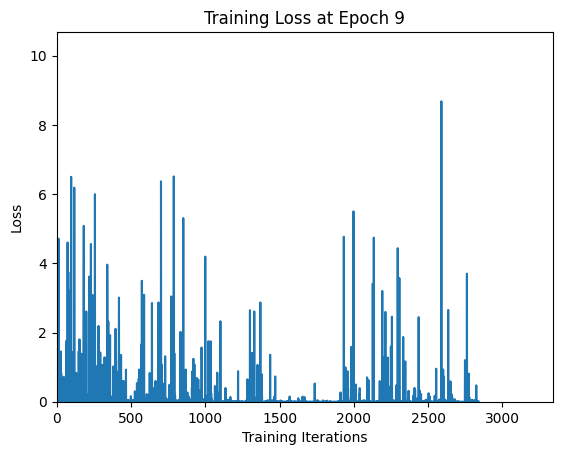

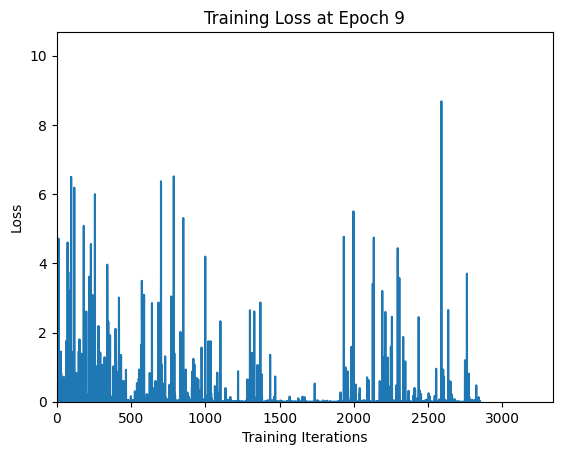

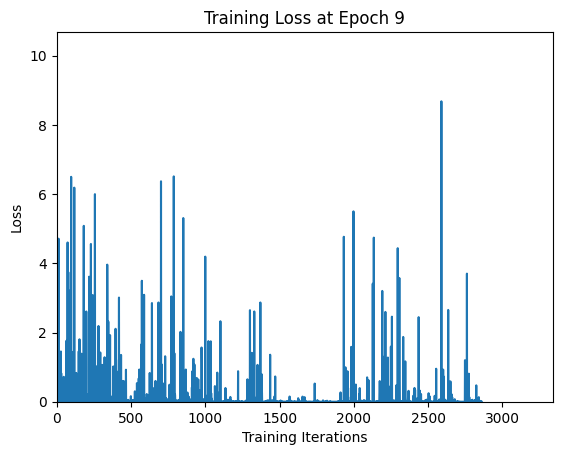

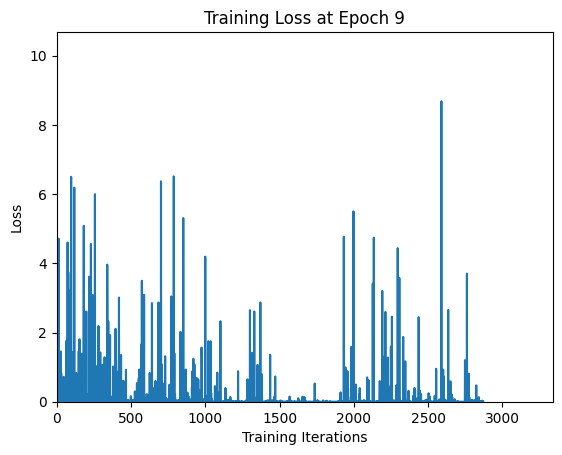

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_5.wav. Skipping...


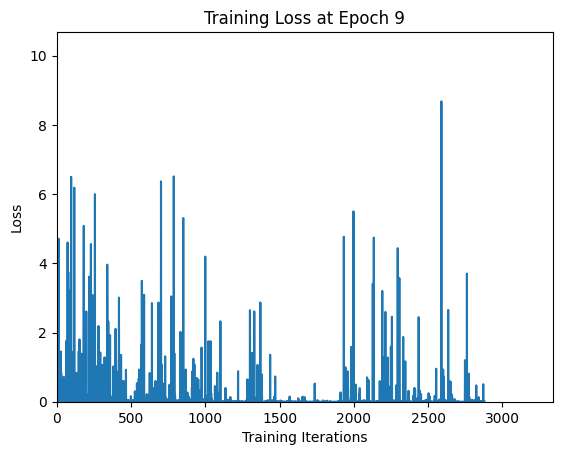

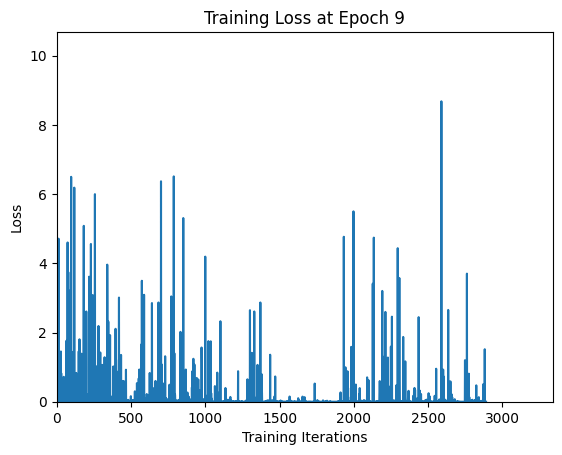

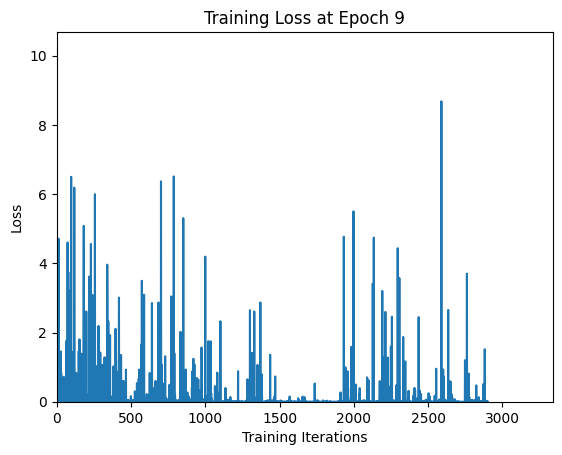

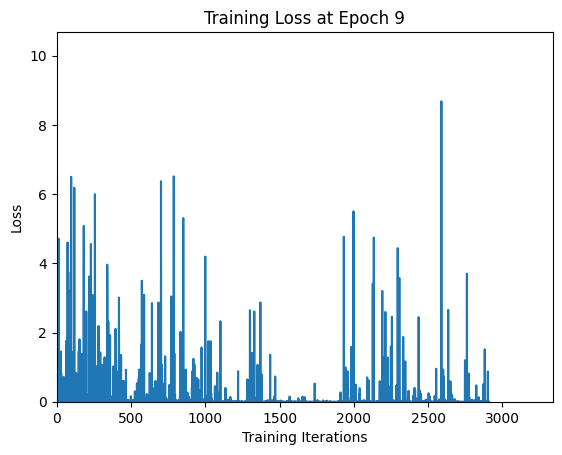

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...


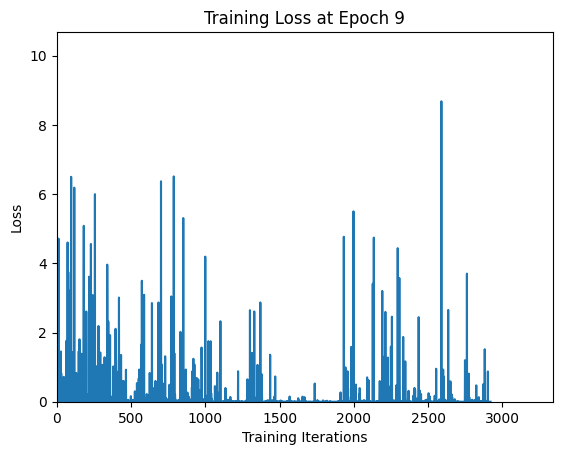

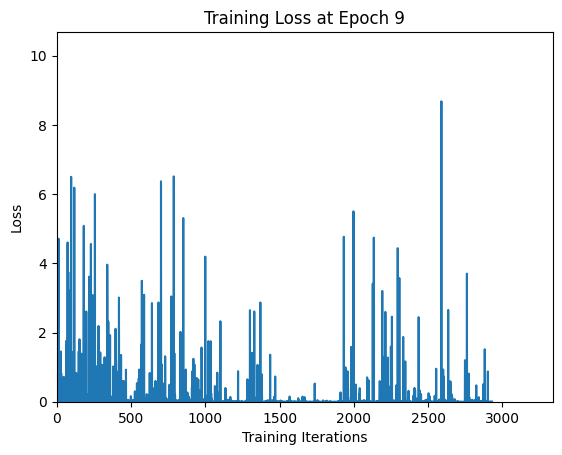

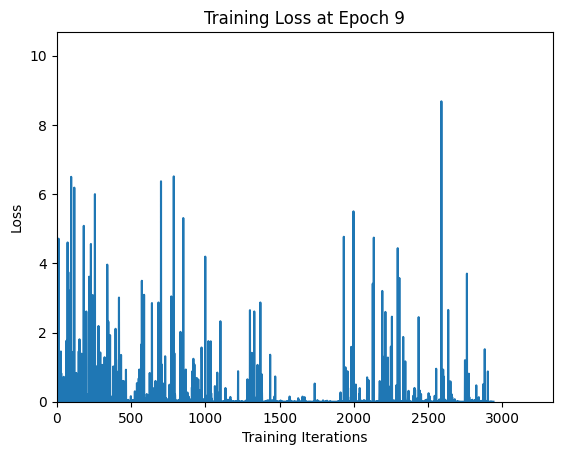

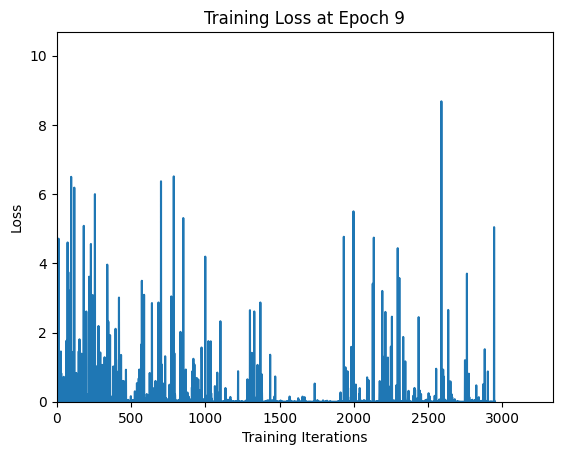

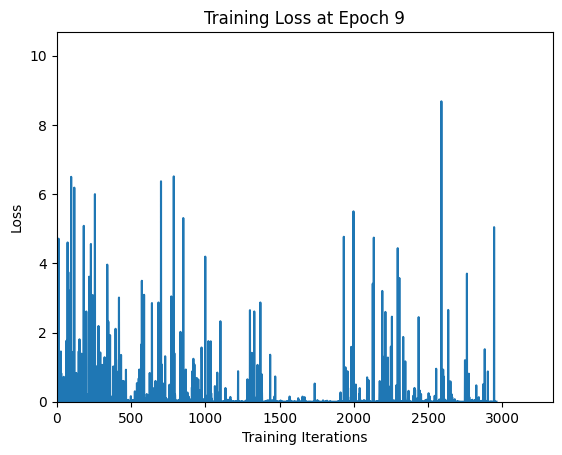

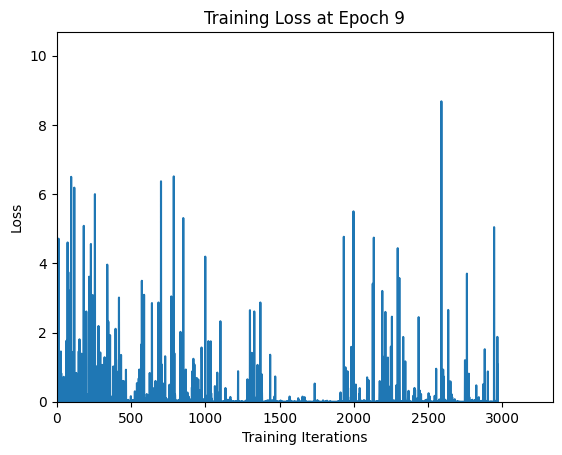

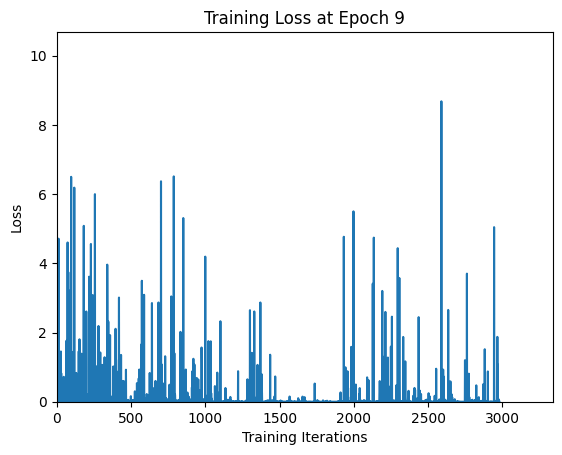

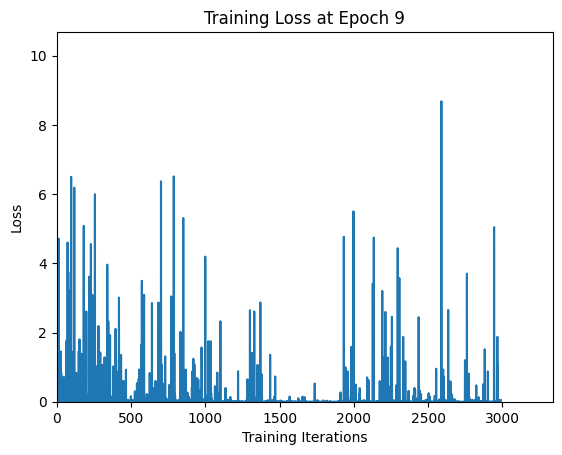

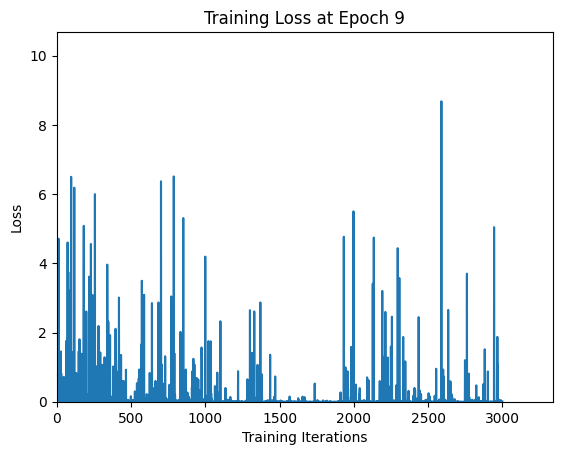

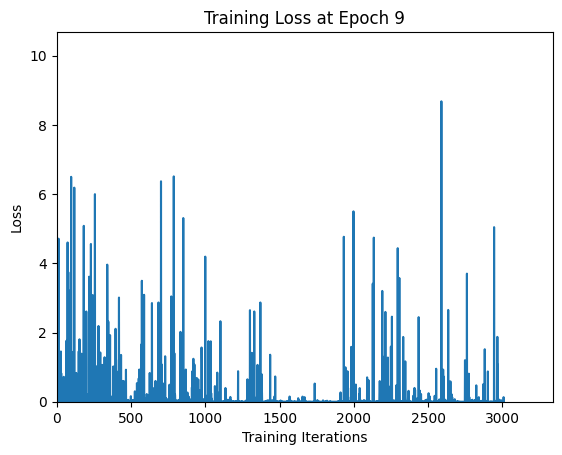

Average Loss after Epoch 9: 0.05601160513033257

Epoch 9, Train Loss: 0.05601160513033257
Epoch 9, Validation Loss: 0.7771785294900686, Validation Accuracy: 0.88
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wa

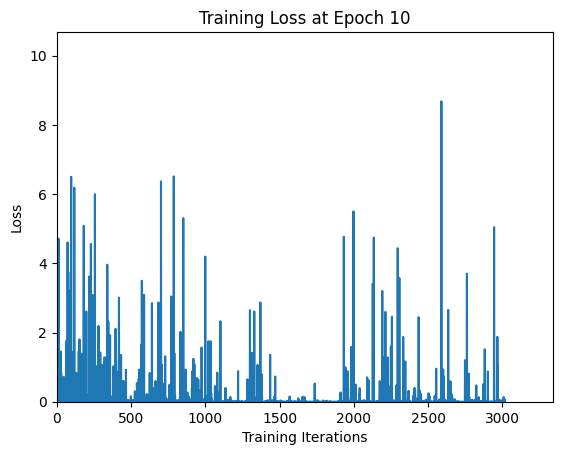

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_1.wav. Skipping...


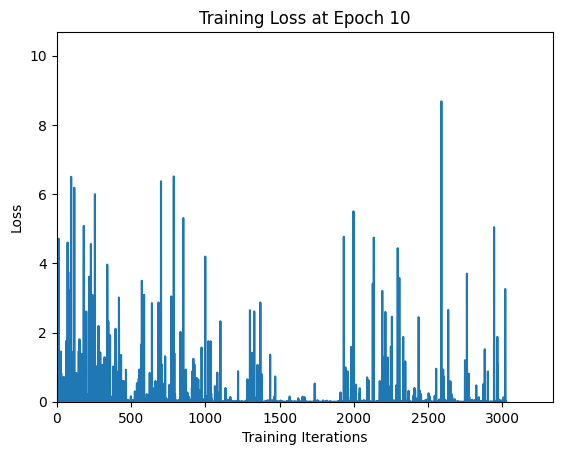

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT033_ANALYSIS/CT033_8.wav. Skipping...


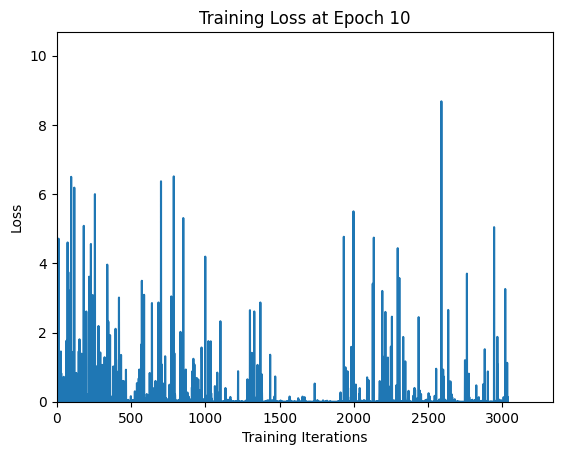

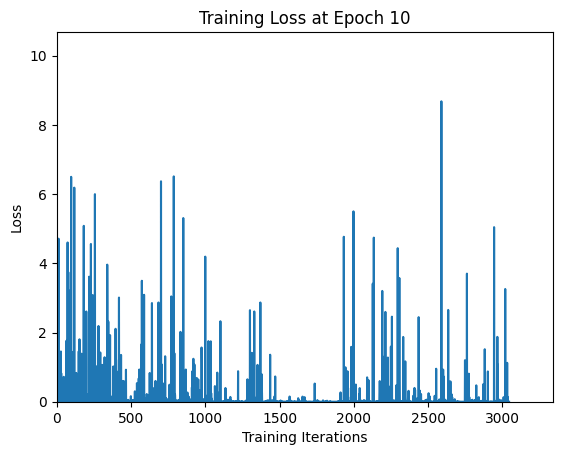

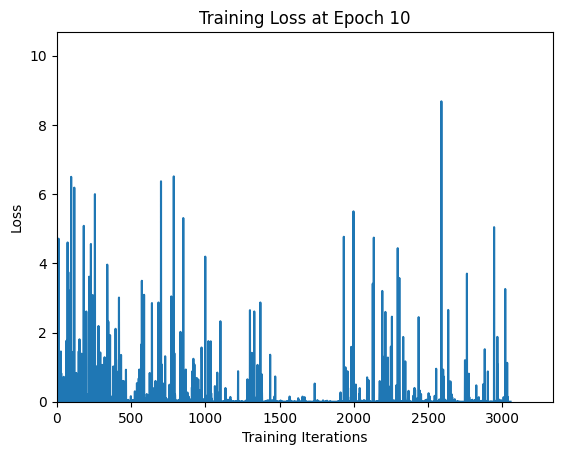

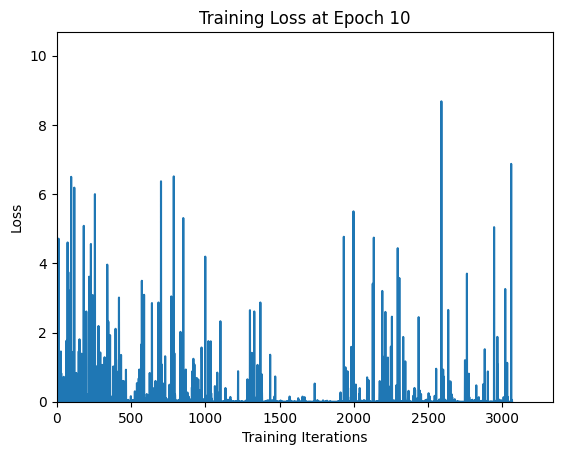

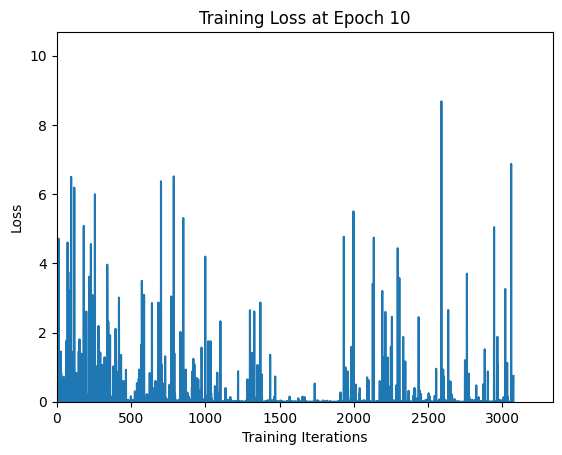

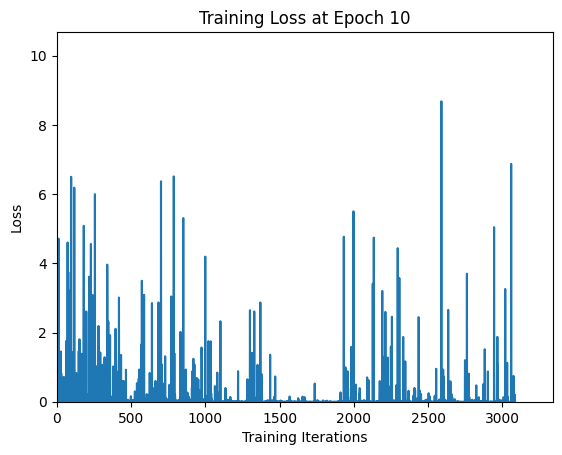

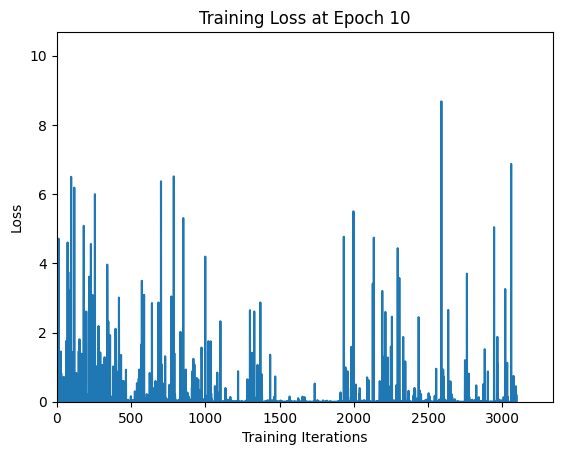

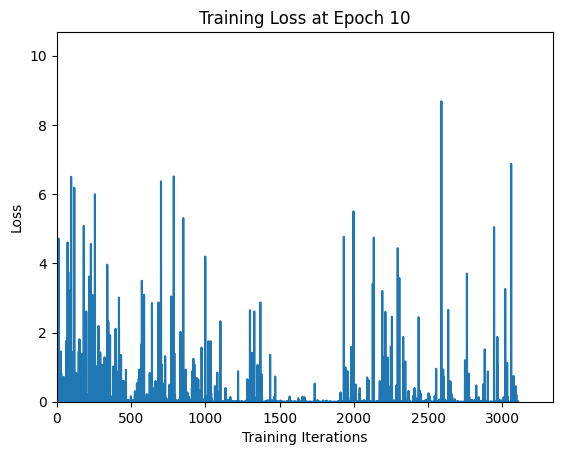

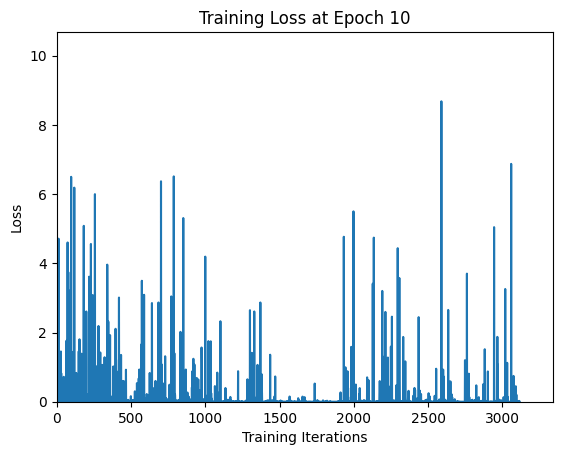

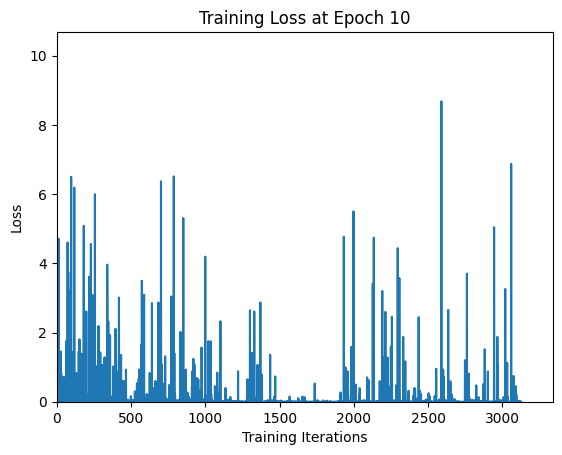

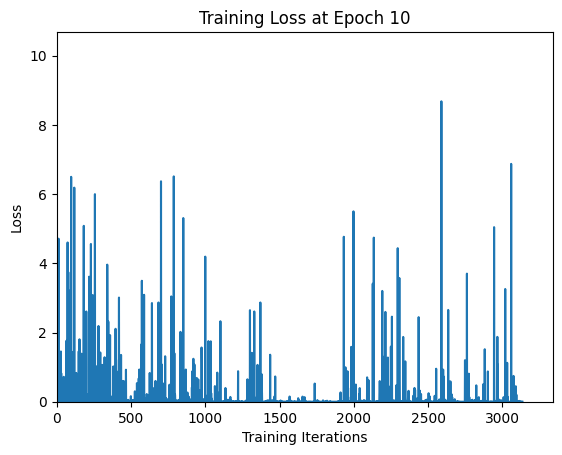

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT037_ANALYSIS/CT037_6.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT013_ANALYSIS/CT013_5.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_5.wav. Skipping...


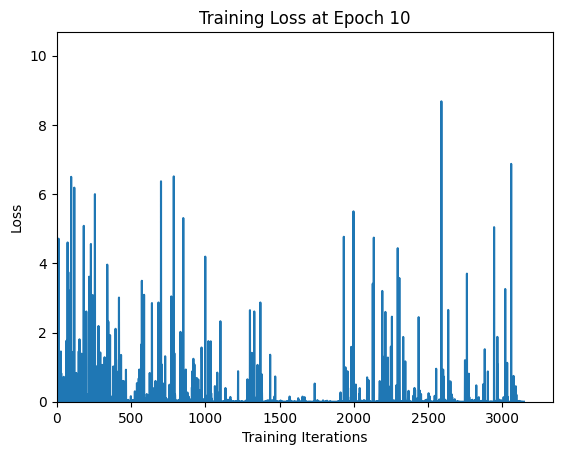

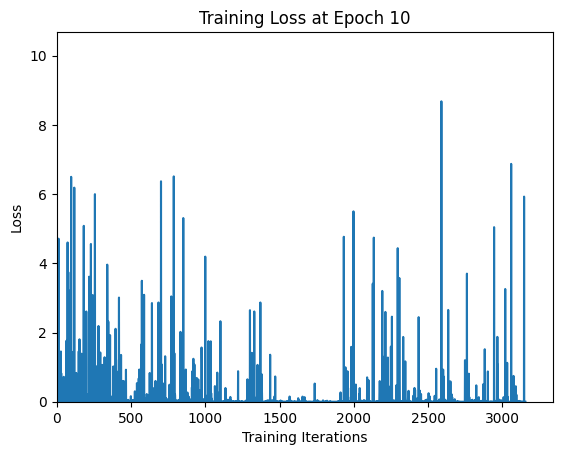

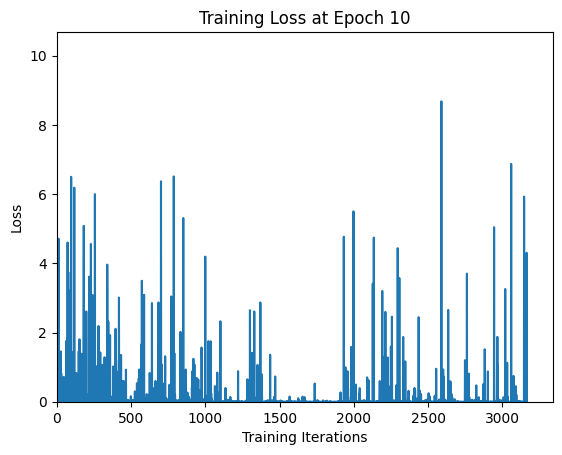

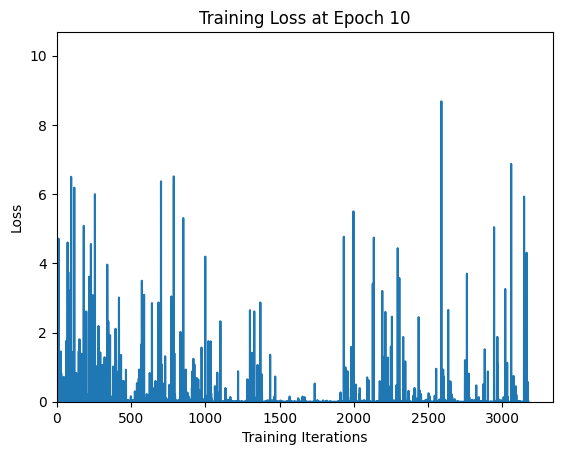

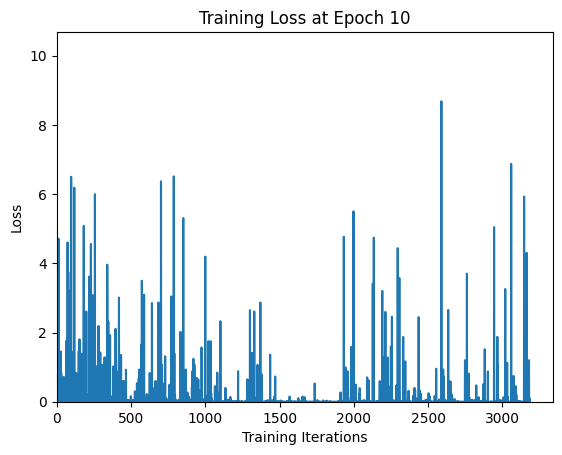

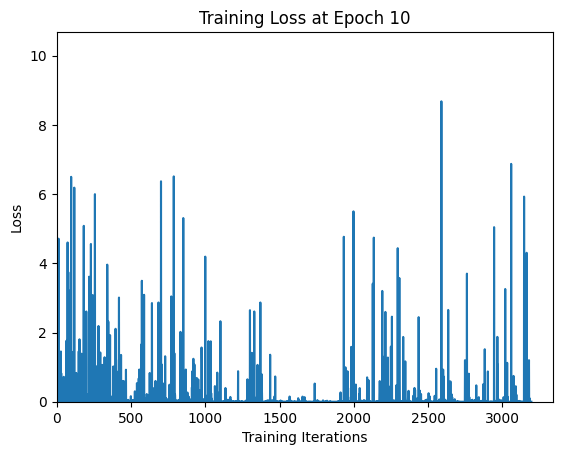

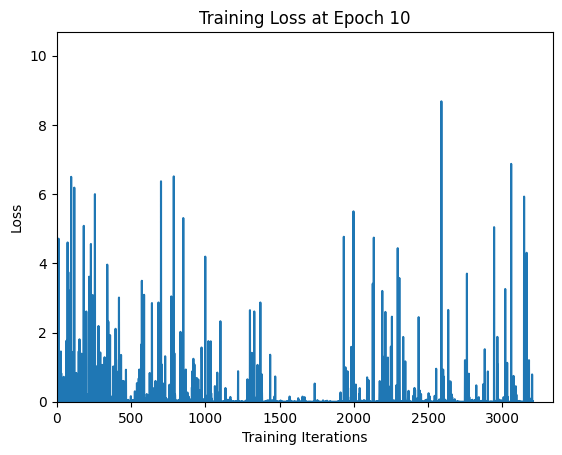

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT023_ANALYSIS/CT023_9.wav. Skipping...
Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP036_ANALYSIS/SP036_5.wav. Skipping...


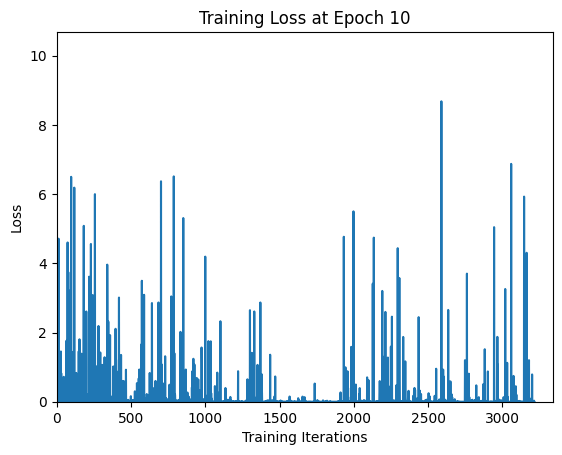

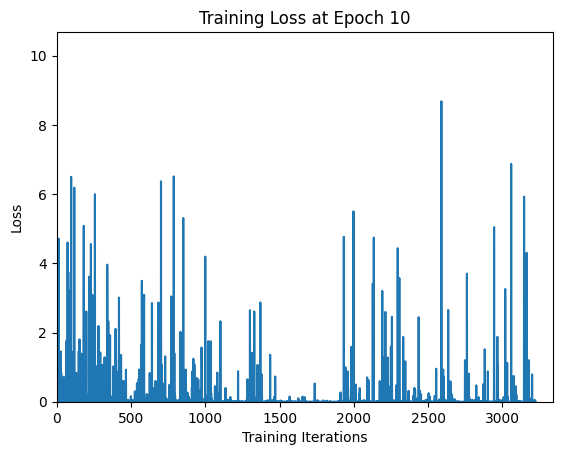

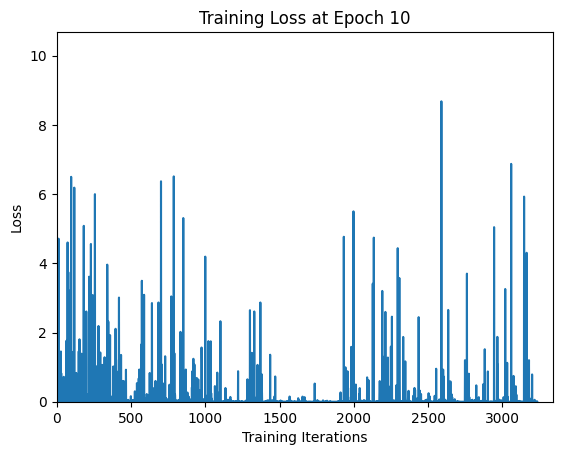

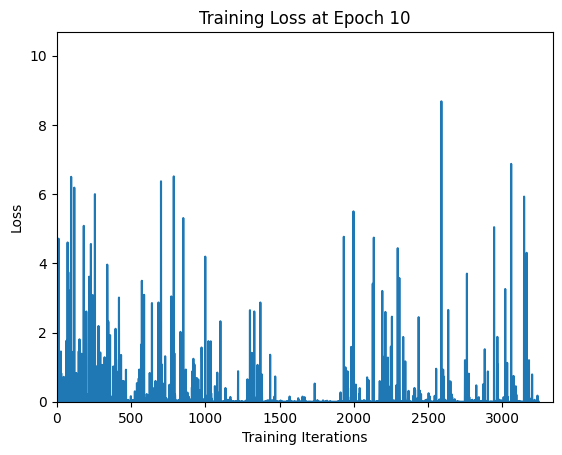

Error opening file: /content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/CT034_ANALYSIS/CT034_8.wav. Skipping...


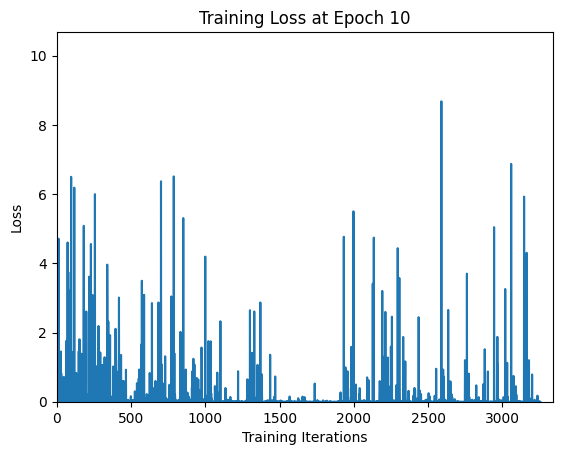

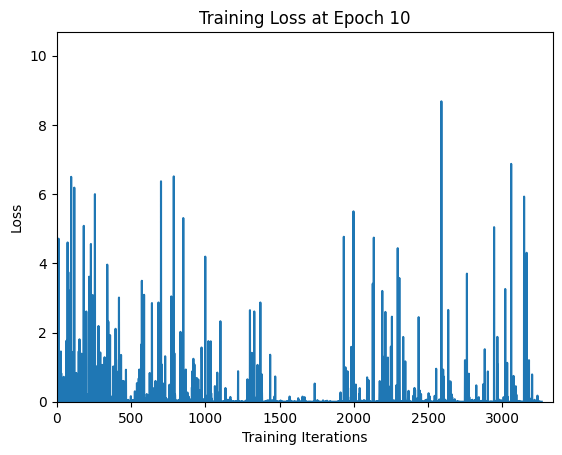

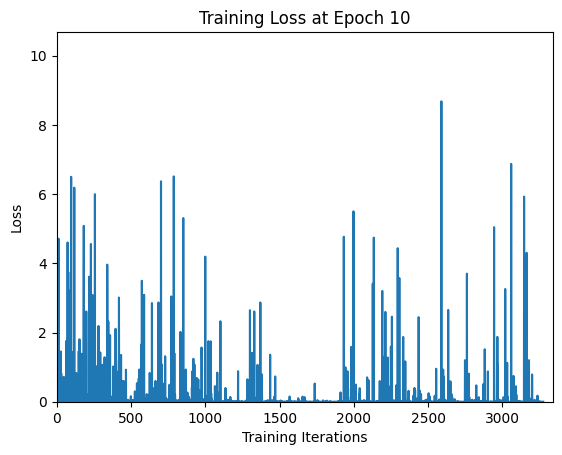

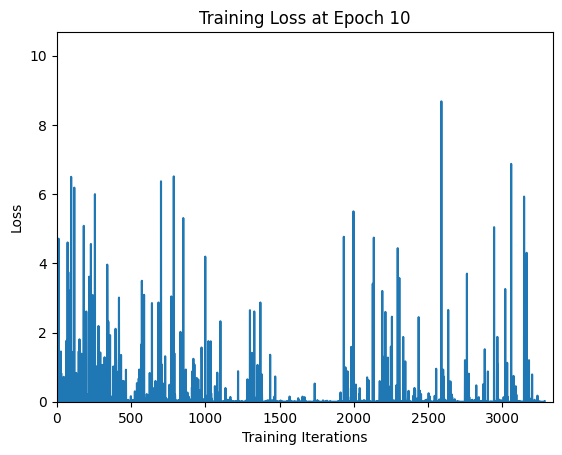

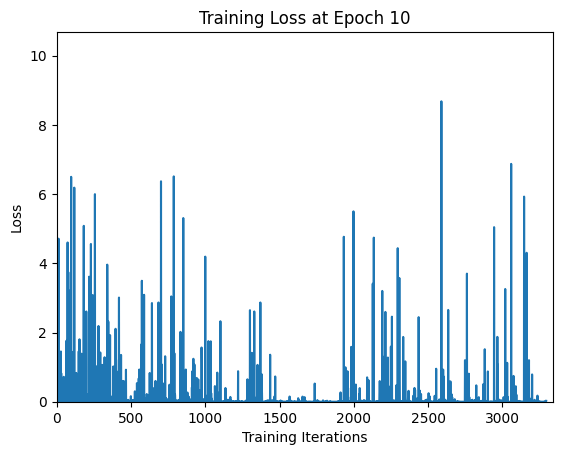

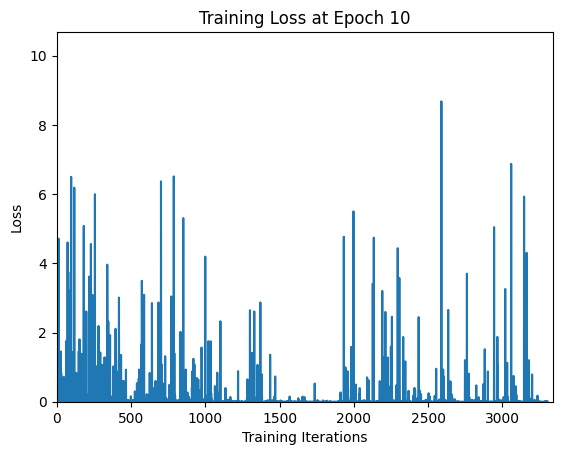

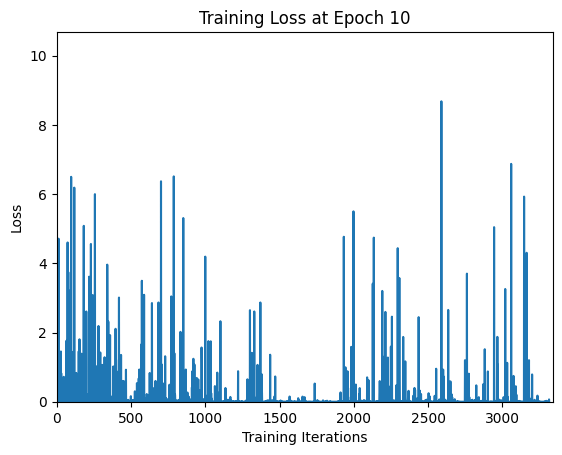

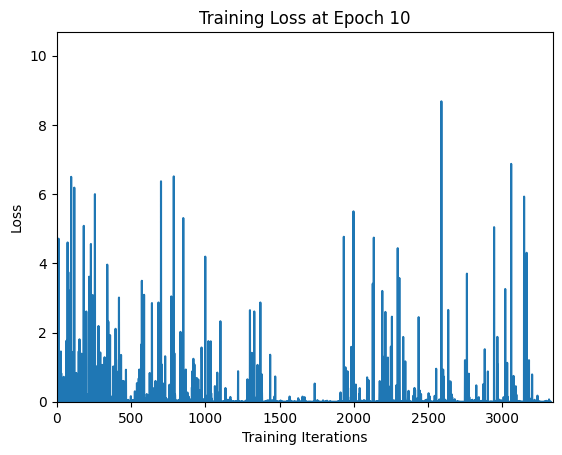

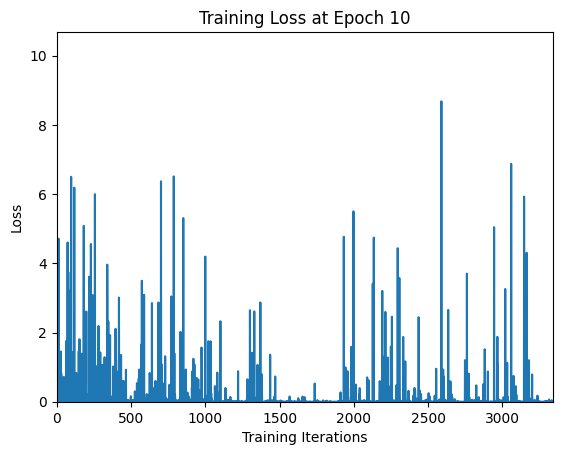

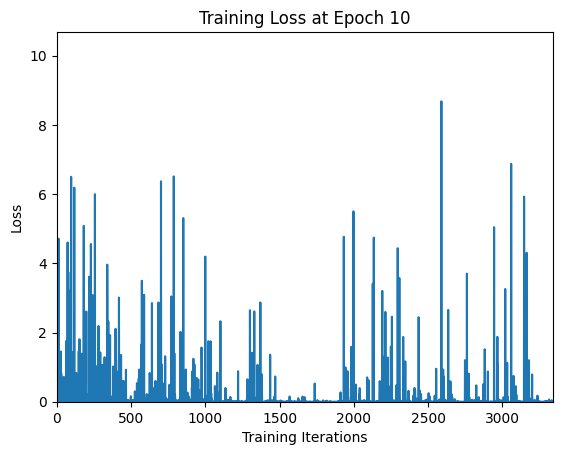

Average Loss after Epoch 10: 0.10438593053260029

Epoch 10, Train Loss: 0.10438593053260029
Epoch 10, Validation Loss: 0.3996981418384758, Validation Accuracy: 0.90
Misclassified Files
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2.wav
/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/SP013_ANALYSIS/SP013_2

In [ ]:
import re
from collections import Counter
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

epochs = 10
plt.ion()
fig, ax = plt.subplots()
x_vals = np.arange(len(train_loader)*epochs)
loss_vals = []
classifier = torch.nn.Linear(model.config.hidden_size,2).to(device)

for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device, loss_vals, epochs, epoch)
    loss_vals.append(train_loss)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss}")

    val_loss, val_accuracy, wrong_files, true_labels, pred_labels = evaluate(model, validation_loader, criterion, device)
    print(f"Epoch {epoch + 1}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy:.2f}")
    print("Misclassified Files")
    for file_path in wrong_files:
        print(file_path)

    sentence_pattern = re.compile(r"_(\d+)\.wav$")
    sentence_counts = Counter()

    for file_path in wrong_files:
        match = sentence_pattern.search(file_path)
        if match:
            sentence_number = int(match.group(1))
            sentence_counts[sentence_number] += 1

    total_wrong = len(wrong_files)
    print("Total wrong files:", total_wrong)
    print()

    for sentence_number, count in sentence_counts.most_common():
        percent = count / total_wrong * 100
        print(f"Sentence {sentence_number}: {count} ({percent:.2f}%)")

    scheduler.step()
    print(classification_report(true_labels, pred_labels, target_names=['non_dysarthria', 'dysarthria']))

    # # plot loss values
    # ax.plot(x_vals, loss_vals, 'b')
    # ax.set_xlabel('Batches')
    # ax.set_ylabel('Loss')
    # ax.set_title('Loss over Training Epochs')
    # plt.pause(0.001)

# # Test on a specific audio file
# audio_file = "/content/drive/MyDrive/torgo_data/dysarthria_male/validation/M01_Session1_0005.wav"
# wav_data, _ = sf.read(audio_file)
# inputs = feature_extractor(wav_data, sampling_rate=16000, return_tensors="pt")
# input_features = inputs.input_features
# with torch.no_grad():
#     logits = model(input_features).logits
# predicted_class_ids = torch.argmax(logits).item()
# predicted_label = model.config.id2label[predicted_class_ids]
# print(f"Predicted label: {predicted_label}")


In [ ]:
torch.save(model.state_dict(), "model_weights2.pth")
print("Predicting...")

Predicting...


#audio aug

In [ ]:
!pip install audiomentations
from audiomentations import Compose, PitchShift, TimeStretch

augmenter = Compose([
    PitchShift(min_semitones=-2, max_semitones=2, p=0.1),
    TimeStretch(min_rate=0.9, max_rate=1.1, p=0.1)
])


In [ ]:
# from torch.optim.lr_scheduler import StepLR

# scheduler = StepLR(optimizer, step_size=2, gamma=0.5)

from transformers import get_linear_schedule_with_warmup

# Define the total number of training steps
# It is usually the number of epochs times the number of batches per epoch
num_training_steps = epochs * len(train_loader)

# Define the number of warmup steps
# Usually set to a fraction of total_training_steps such as 0.1 * num_training_steps
num_warmup_steps = int(num_training_steps * 0.3)

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)


In [ ]:
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=2).to(device)
    ##
model_path = "/content/models/my_model_06/pytorch_model.bin"
if os.path.exists(model_path):
    print(f"Loading saved model {model_path}")
    model.load_state_dict(torch.load(model_path))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
import numpy as np

def train_augmented(model, dataloader, criterion, optimizer, device, loss_vals, epochs, current_epoch, augmenter):
    model.train()
    running_loss = 0

    for i, (inputs, labels) in enumerate(dataloader):
        inputs = {key: value.squeeze().to(device) for key, value in inputs.items() if torch.is_tensor(value)}
        labels = labels.to(device)

        batch_size = labels.size(0)  # Get batch size from labels tensor
        decoder_input_ids = torch.tensor([[1] * batch_size]).to(device) * model.config.decoder_start_token_id

        # Apply audio augmentation
        augmented_audio = []
        for audio in inputs['input_values']:
            # The augmenter works with numpy arrays, so we need to convert the tensor to a numpy array
            audio_np = audio.cpu().numpy()

            # Apply the augmentation
            augmented = augmenter(audio_np, sample_rate=16000)  # Assuming a sample rate of 16000Hz

            augmented_audio.append(augmented)

        # Convert the list of numpy arrays back to a tensor
        inputs['input_values'] = torch.from_numpy(np.array(augmented_audio)).to(device)

        optimizer.zero_grad()
        outputs = model(**inputs, decoder_input_ids=decoder_input_ids, output_hidden_states=True)
        last_hidden_state = outputs.last_hidden_state
        pooled_output = torch.mean(last_hidden_state, dim=1, keepdim=False)  # Ensure batch size is maintained

        logits = classifier(pooled_output)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        # append loss value to list
        loss_vals.append(loss.item())
        running_loss += loss.item()

        if i % 10 == 0:  # Update the plot every 10 iterations
            plt.clf()  # Clear the previous plot
            plt.plot(loss_vals)
            plt.xlim([0, len(dataloader)*epochs])
            plt.ylim([0, max(loss_vals) + 2])
            plt.xlabel('Training Iterations')
            plt.ylabel('Loss')
            plt.title(f"Training Loss at Epoch {current_epoch + 1}")
            plt.pause(0.001)  # Pause to update the plot

    avg_loss = running_loss / len(dataloader)
    print(f"Average Loss after Epoch {current_epoch + 1}: {avg_loss}\n")
    return avg_loss


In [ ]:
epochs = 20
plt.ion()
fig, ax = plt.subplots()
x_vals = np.arange(len(train_loader)*epochs)
loss_vals = []
for epoch in range(epochs):
    train_loss = trainaug(model, train_loader, criterion, optimizer, device, loss_vals, epochs, epoch)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss}")

    val_loss, val_accuracy, wrong_files, true_labels, pred_labels = evaluate(model, validation_loader, criterion, device)
    print(f"Epoch {epoch + 1}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy:.2f}")
    print("Misclassified Files")
    for file_path in wrong_files:
      print(file_path)


    sentence_pattern = re.compile(r"_(\d+)\.wav$")

    sentence_counts = Counter()
    for file_path in wrong_files:
        match = sentence_pattern.search(file_path)
        if match:
            sentence_number = int(match.group(1))
            sentence_counts[sentence_number] += 1

    total_wrong = len(wrong_files)
    print("Total wrong files:", total_wrong)
    print()

    for sentence_number, count in sentence_counts.most_common():
        percent = count / total_wrong * 100
        print(f"Sentence {sentence_number}: {count} ({percent:.2f}%)")
    scheduler.step()
    print(classification_report(true_labels, pred_labels, target_names=['non_dysarthria', 'dysarthria']))
audio_file = "/content/drive/MyDrive/torgo_data/dysarthria_male/validation/M01_Session1_0005.wav"
# predicted_label = predict(model, audio_file, train_dataset.processor, device)
# print(f"Predicted label: {predicted_label}")





# Test on a specific audio file
##audio_file = "/content/drive/MyDrive/torgo_data/dysarthria_male/validation/M01_Session1_0005.wav"
##predicted_label = predict(model, audio_file, train_dataset.processor, device)
##print(f"Predicted label: {predicted_label}")


In [ ]:
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Define the pattern to extract the sentence number from the file path
sentence_pattern = re.compile(r"_(\d+)\.wav$")

# Counter for the total number of each sentence type in the dataset
total_sentence_counts = Counter()

for file_path in train_loader.dataset.data: # Access the file paths directly
    match = sentence_pattern.search(file_path)
    if match:
        sentence_number = int(match.group(1))
        total_sentence_counts[sentence_number] += 1

epochs = 1
plt.ion()
fig, ax = plt.subplots()
x_vals = np.arange(len(train_loader)*epochs)
loss_vals = []

for epoch in range(epochs):
    # train_loss = trainaug(model, train_loader, criterion, optimizer, device, loss_vals, epochs, epoch)
    # print(f"Epoch {epoch + 1}, Train Loss: {train_loss}")

    val_loss, val_accuracy, wrong_files, true_labels, pred_labels = evaluate(model, validation_loader, criterion, device)
    print(f"Epoch {epoch + 1}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy:.2f}")
    print("Misclassified Files")
    for file_path in wrong_files:
        print(file_path)

    # Counter for the misclassified sentences
    sentence_counts = Counter()

    for file_path in wrong_files:
        match = sentence_pattern.search(file_path)
        if match:
            sentence_number = int(match.group(1))
            sentence_counts[sentence_number] += 1

    print("Total wrong files:", len(wrong_files))
    print()

    for sentence_number, count in sentence_counts.most_common():
        percent = count / total_sentence_counts[sentence_number] * 100
        print(f"Sentence {sentence_number}: {count} ({percent:.2f}%)")

    scheduler.step()
    print(classification_report(true_labels, pred_labels, target_names=['non_dysarthria', 'dysarthria']))


In [ ]:
torch.save(model.state_dict(), "dysarthria_classifier2.pth")


In [ ]:
save_dir = "models/my_model_06"
model.save_pretrained(save_dir)

## Cross testing


In [ ]:


   # dysarthria_validation_path = "/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/testing"
   # non_dysarthria_validation_path = "/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/testing"

    #dysarthria_validation_files = get_wav_files(dysarthria_validation_path)
   # non_dysarthria_validation_files = get_wav_files(non_dysarthria_validation_path)

    #validation_data = dysarthria_validation_files + non_dysarthria_validation_files
    #validation_labels = [1] * len(dysarthria_validation_files) + [0] * len(non_dysarthria_validation_files)

epochs = 1
plt.ion()
fig, ax = plt.subplots()
x_vals = np.arange(len(train_loader)*epochs)
loss_vals = []
for epoch in range(epochs):
    #train_loss = train(model, train_loader, criterion, optimizer, device, loss_vals, epochs, epoch)
    #print(f"Epoch {epoch + 1}, Train Loss: {train_loss}")

    val_loss, val_accuracy, wrong_files, true_labels, pred_labels = evaluate(model, validation_loader, criterion, device)
    print(f"Epoch {epoch + 1}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy:.2f}")
    print("Misclassified Files")
    for file_path in wrong_files:
      print(file_path)


    sentence_pattern = re.compile(r"_(\d+)\.wav$")

    sentence_counts = Counter()
    for file_path in wrong_files:
        match = sentence_pattern.search(file_path)
        if match:
            sentence_number = int(match.group(1))
            sentence_counts[sentence_number] += 1

    total_wrong = len(wrong_files)
    print("Total wrong files:", total_wrong)
    print()

    for sentence_number, count in sentence_counts.most_common():
        percent = count / total_wrong * 100
        print(f"Sentence {sentence_number}: {count} ({percent:.2f}%)")
    scheduler.step()
    print(classification_report(true_labels, pred_labels, target_names=['non_dysarthria', 'dysarthria']))
audio_file = "/content/drive/MyDrive/torgo_data/dysarthria_male/validation/M01_Session1_0005.wav"
predicted_label = predict(model, audio_file, train_dataset.processor, device)
print(f"Predicted label: {predicted_label}")





# Test on a specific audio file
##audio_file = "/content/drive/MyDrive/torgo_data/dysarthria_male/validation/M01_Session1_0005.wav"
##predicted_label = predict(model, audio_file, train_dataset.processor, device)
##print(f"Predicted label: {predicted_label}")


## DEBUGGING

In [ ]:
dysarthria_path = "/content/drive/MyDrive/torgo_data/dysarthria_male/training"
non_dysarthria_path = "/content/drive/MyDrive/torgo_data/non_dysarthria_male/training"

dysarthria_files = [os.path.join(dysarthria_path, f) for f in os.listdir(dysarthria_path) if f.endswith('.wav')]
non_dysarthria_files = [os.path.join(non_dysarthria_path, f) for f in os.listdir(non_dysarthria_path) if f.endswith('.wav')]

data = dysarthria_files + non_dysarthria_files
labels = [1] * len(dysarthria_files) + [0] * len(non_dysarthria_files)

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

train_dataset = DysarthriaDataset(train_data, train_labels)
test_dataset = DysarthriaDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=4, drop_last=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(device)
# model.classifier = nn.Linear(model.config.hidden_size, 2).to(device)

model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=2).to(device)

In [ ]:
max_length = 100_000
processor = train_dataset.processor

model.eval()
audio_file = "/content/drive/MyDrive/torgo_data/dysarthria_male/validation/M01_Session1_0005.wav"
# predicted_label = predict(model, audio_file, train_dataset.processor, device)
# print(f"Predicted label: {predicted_label}")

wav_data, _ = sf.read(audio_file)
inputs = processor(wav_data, sampling_rate=16000, return_tensors="pt", padding=True)
input_values = inputs.input_values.squeeze(0)  # Squeeze the batch dimension
if max_length - input_values.shape[-1] > 0:
    input_values = torch.cat([input_values, torch.zeros((max_length - input_values.shape[-1],))], dim=-1)
else:
    input_values = input_values[:max_length]

input_values = input_values.unsqueeze(0).to(device)
input_values.shape

In [ ]:
with torch.no_grad():
  outputs = model(**{"input_values": input_values})
  logits = outputs.logits

In [ ]:
input_values.shape, logits.shape

In [ ]:
import torch.nn.functional as F
# Remove the batch dimension.
logits = logits.squeeze()
predicted_class_id = torch.argmax(logits, dim=-1)
predicted_class_id

Cross testing

##origial code

In [ ]:
import os
import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
from sklearn.model_selection import train_test_split

# Custom Dataset class
class DysarthriaDataset(Dataset):
    def __init__(self, data, labels, max_length=100000):
        self.data = data
        self.labels = labels
        self.max_length = max_length
        self.processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
          wav_data, _ = sf.read(self.data[idx])
        except:
          print(f"Error opening file: {self.data[idx]}. Skipping...")
          return self.__getitem__((idx + 1) % len(self.data))
        inputs = self.processor(wav_data, sampling_rate=16000, return_tensors="pt", padding=True)
        input_values = inputs.input_values.squeeze(0)  # Squeeze the batch dimension
        if self.max_length - input_values.shape[-1] > 0:
            input_values = torch.cat([input_values, torch.zeros((self.max_length - input_values.shape[-1],))], dim=-1)
        else:
            input_values = input_values[:self.max_length]

        # Remove unsqueezing the channel dimension
        # input_values = input_values.unsqueeze(0)

        # label = torch.zeros(32,dtype=torch.long)
        # label[self.labels[idx]] = 1

        ### CHANGES: simply return the label as a single integer
        return {"input_values": input_values}, self.labels[idx]
        ###


def train(model, dataloader, criterion, optimizer, device, ax, loss_vals, x_vals, fig,train_loader,epochs):
    model.train()
    running_loss = 0

    for i, (inputs, labels) in enumerate(dataloader):
        inputs = {key: value.squeeze().to(device) for key, value in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(**inputs).logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        # append loss value to list
        loss_vals.append(loss.item())
        running_loss += loss.item()

        if i:
            # update plot
            ax.clear()
            ax.set_xlim([0, len(train_loader)*epochs])
            ax.set_xlabel('Training Iterations')
            ax.set_ylim([0, max(loss_vals) + 2])
            ax.set_ylabel('Loss')
            ax.plot(x_vals[:len(loss_vals)], loss_vals)
            fig.canvas.draw()
            plt.pause(0.001)

    avg_loss = running_loss / len(dataloader)
    print(avg_loss)
    print("\n")
    return avg_loss



def main():
    dysarthria_path = "/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/training"
    non_dysarthria_path = "/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/training"

    dysarthria_files = get_wav_files(dysarthria_path)
    non_dysarthria_files = get_wav_files(non_dysarthria_path)

    data = dysarthria_files + non_dysarthria_files
    labels = [1] * len(dysarthria_files) + [0] * len(non_dysarthria_files)

    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

    train_dataset = DysarthriaDataset(train_data, train_labels)
    test_dataset = DysarthriaDataset(test_data, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=8, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=8, drop_last=True)
    validation_loader = DataLoader(test_dataset, batch_size=8, drop_last=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(device)
    # model.classifier = nn.Linear(model.config.hidden_size, 2).to(device)

    ### NEW CODES
    # It seems like the classifier layer is excluded from the model's forward method (i.e., model(**inputs)).
    # That's why the number of labels in the output was 32 instead of 2 even when you had already changed the classifier.
    # Instead, huggingface offers the option for loading the Wav2Vec model with an adjustable classifier head on top (by setting num_labels).

    model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=2).to(device)
    ###
    #model_path = "/content/dysarthria_classifier3.pth"
    #if os.path.exists(model_path):
        #print(f"Loading saved model {model_path}")
        #model.load_state_dict(torch.load(model_path))

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
    dysarthria_validation_path = "/content/drive/MyDrive/RECORDINGS_ANALYSIS/SP_ANALYSIS/testing"
    non_dysarthria_validation_path = "/content/drive/MyDrive/RECORDINGS_ANALYSIS/CT_ANALYSIS/testing"

    dysarthria_validation_files = get_wav_files(dysarthria_validation_path)
    non_dysarthria_validation_files = get_wav_files(non_dysarthria_validation_path)

    validation_data = dysarthria_validation_files + non_dysarthria_validation_files
    validation_labels = [1] * len(dysarthria_validation_files) + [0] * len(non_dysarthria_validation_files)

    epochs = 10
    fig, ax = plt.subplots()
    x_vals = np.arange(len(train_loader)*epochs)
    loss_vals = []
    nume = 1
    for epoch in range(epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device, ax, loss_vals, x_vals, fig, train_loader, epoch+1)
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss}")

        val_loss, val_accuracy, wrong_files = evaluate(model, validation_loader, criterion, device)
        print(f"Epoch {epoch + 1}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy:.2f}")
        print("Misclassified Files")
        for file_path in wrong_files:
          print(file_path)


        sentence_pattern = re.compile(r"_(\d+)\.wav$")

        sentence_counts = Counter()
        for file_path in wrong_files:
            match = sentence_pattern.search(file_path)
            if match:
                sentence_number = int(match.group(1))
                sentence_counts[sentence_number] += 1

        total_wrong = len(wrong_files)
        print("Total wrong files:", total_wrong)
        print()

        for sentence_number, count in sentence_counts.most_common():
            percent = count / total_wrong * 100
            print(f"Sentence {sentence_number}: {count} ({percent:.2f}%)")


    torch.save(model.state_dict(), "dysarthria_classifier4.pth")
    print("Predicting...")
    # Test on a specific audio file
    ##audio_file = "/content/drive/MyDrive/torgo_data/dysarthria_male/validation/M01_Session1_0005.wav"
    ##predicted_label = predict(model, audio_file, train_dataset.processor, device)
    ##print(f"Predicted label: {predicted_label}")

def predict(model, file_path, processor, device, max_length=100000): ### CHANGES: added max_length as an argument.
    model.eval()
    with torch.no_grad():
        wav_data, _ = sf.read(file_path)
        inputs = processor(wav_data, sampling_rate=16000, return_tensors="pt", padding=True)
        # inputs = {key: value.squeeze().to(device) for key, value in inputs.items()}

        ### NEW CODES HERE
        input_values = inputs.input_values.squeeze(0)  # Squeeze the batch dimension
        if max_length - input_values.shape[-1] > 0:
            input_values = torch.cat([input_values, torch.zeros((max_length - input_values.shape[-1],))], dim=-1)
        else:
            input_values = input_values[:max_length]
        input_values = input_values.unsqueeze(0).to(device)
        inputs = {"input_values": input_values}
        ###

        logits = model(**inputs).logits
        # _, predicted = torch.max(logits, dim=0)

        ### NEW CODES HERE
        # Remove the batch dimension.
        logits = logits.squeeze()
        predicted_class_id = torch.argmax(logits, dim=-1).item()
        ###

    # return predicted.item()
    return predicted_class_id
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0
    correct_predictions = 0
    total_predictions = 0
    wrong_files = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = {key: value.squeeze().to(device) for key, value in inputs.items()}
            labels = labels.to(device)

            logits = model(**inputs).logits
            loss = criterion(logits, labels)
            running_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            wrong_idx = (predicted != labels).nonzero().squeeze().cpu().numpy()
            if wrong_idx.ndim > 0:
              for idx in wrong_idx:
                  wrong_files.append(dataloader.dataset.data[idx])
            elif wrong_idx.size > 0:
                wrong_files.append(dataloader.dataset.data[wrong_idx])


    avg_loss = running_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy, wrong_files



def get_wav_files(base_path):
    wav_files = []
    for subject_folder in os.listdir(base_path):
        subject_path = os.path.join(base_path, subject_folder)
        if os.path.isdir(subject_path):
            for wav_file in os.listdir(subject_path):
                if wav_file.endswith('.wav'):
                    wav_files.append(os.path.join(subject_path, wav_file))
    return wav_files
if __name__ == "__main__":
    main()
